# mRNA editing analysis of Doryteuthis (Loligo) pealeii

Updated: Feb 08, 2022 by Sofia Medina Ruiz / Rokhsar lab.


This code was used to produce the figures from the RNA editing section of "Genome and transcriptome mechanisms driving cephalopod evolution". Albertin1, Medina-Ruiz, Mitros2, Hannah Schmidbaur, et al. Under review. 

This notebook analyzes the features of annotated transcriptome variant calls on the genome of the squid Doryteuthis (Loligo) pealeii. The goal was to describe the distribution of the frequency of (A>G) mRNA edit sites across diverse tissue types and across genes. For additional methods and descriptive explanation of the figures  refer to the manuscript.

Variants were called by mpileup and bcftools (samtools v1.6) using the following parameters: samtools mpileup -A -Q 30 -d 1000 -C 50 --output-tags AD,ADF,ADR,DP,SP -uf genome.fa -b bam.md.list |  bcftools call -m -A --skip-variants indels | bcftools filter -g3 -i 'MQ>30 & SUM(DP4)>10 & (DP4[2]+DP4[3])>5'. The resulting variants were called by bcftools (samtools v1.9). Variants were annotated by SnpEff v.4.3t86 using as reference the primary transcripts (longest isoform). Parsing of the SnpEff output was performed with customized python code snpeff_parser_for_rnaediting.py. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import copy
import seaborn as sns
import pysam

from matplotlib.colors import ListedColormap, LinearSegmentedColormap#, DivergingNorm
import matplotlib as mpl

def out_table(df,name_table):
    out_dir_t = './Tables_DATA/'
    out_name_table = ''.join((out_dir_t,name_table))
    df.to_csv(out_name_table,sep='\t', index=True)
    print (out_name_table)
    
def out_table_noIndex(df,name_table):
    out_dir_t = './Tables_DATA/'
    out_name_table = ''.join((out_dir_t,name_table))
    df.to_csv(out_name_table,sep='\t', index=False)
    print (out_name_table)
    

### List abbreviations of samples per specimen:
Samples_Rosenthal = ['BGr','BHr','CLr','GFLr','Gilr','ILr','MELPr','OLr','SGr','VELPr','VLr']
Samples_Albertin = ['VL','Sup','Sub','OLe','OLl','GFL','SG','BuL','BrL','ANC','Tes','Ten','Suc','Ret','Man','Kid','Ink','Hep','Hea','Gil','BM','DCI','MDC','MDI','MVC','MVI']
Neural_samples_Alon = ['GFLr','SGr','BGr','OLr','VLr'] 
NotNeu_samples_Alon = ['ILr','CLr','VELPr','Gilr','BHr','MELPr']
Neural_samples = ['Ret', 'ANC', 'BrL', 'VL', 'Sup', 'BuL', 'OLe', 'OLl', 'SG', 'Sub', 'GFL']
NotNeu_samples = ['BM', 'DCI', 'Hep', 'MDC', 'Tes', 'MVI', 'Man', 'Hea', 'MVC', 'Gil', 'Kid', 'Ten', 'Suc', 'MDI']

In [2]:
#Paths to files
gene_description_file = '/Users/sofiamr/Documents/Rocksar Lab/Squid/February2020/Annotation/Filtered/DpealeiiV2.filtered.annot.txt'
cds_fasta = '/Users/sofiamr/Documents/Rocksar Lab/Squid/February2020/Annotation/Filtered/Dpealeiiv2.allTrs.filt.cds.fa'
genome_annotation_file  = '/Users/sofiamr/Documents/Rocksar Lab/Squid/Review/doi_10.5061_dryad.2hv7d__v2/Genome/Dpealeiiv2.gene_exons.filt_Chr.gff3'
Tophat_tpm_file = '../featureCount.tophat.M.primary.ignoreDup.filtered_tpm.txt'
Genotypes_OpalHbl_ovrp_Dp_file = "../Edited_vs_Non_edited_DpalHbl.gt.tab"

ADAR_Albertin_file = '../ADAR_Albertin.tab'
DP_Albertin_file = '../DP_Albertin.tab'
EF_Albertin_file = '../EF_Albertin.tab'
Ref_Albertin_file = '../Ref_Albertin.tab'
Alt_Albertin_file = '../Alt_Albertin.tab'
Weighted_values_file = '../Weighted_values_Albertin.tab'

#Bedtools output of transcriptome variants that intersected with TMHMM and PFAM domains:
Edit_prot_pos_TMHMM_file = '../Edit_prot_pos_TMHMM_intersect.bed'
PFAM_intersect_file = '../Edit_prot_pos_intersect.bed'

ADAR_Alon_file = '../ADAR_Alon.tab'
DP_Alon_file = '../DP_Alon.tab'
EF_Alon_file = '../EF_Alon.tab'


In [3]:
# Set up the color codes and plotting settings:

# A) For edit Kind
color_editKind_2 = {'Ubiq-Med':'dimgrey','Neural':'mediumblue','Ubiq-High':'red','Ubiq-Low':'darkgrey'}
N_256 = float(256)
grey_ = (.75,.75,.75)
cb_1 = (72/N_256,42/N_256,114/N_256)
cb_2 = (55/N_256,86/N_256,142/N_256)
cb_3 = (33/N_256,140/N_256,143/N_256)
cb_4 = (42/N_256,180/N_256,122/N_256)
cb_5 = (130/N_256,196/N_256,83/N_256)
cb_6 = (206/N_256,221/N_256,40/N_256)
col_bld = [cb_1,cb_2,cb_3,cb_4,cb_5, cb_6,grey_,grey_,grey_,grey_][::-1]  #Grey, White, Red #Orange:(249/N_256,212/N_256,18/N_256),
col_blind = LinearSegmentedColormap.from_list('col_blind', col_bld, N=500)

#B) For effect on gene
list_kinds = ['Coding', 'Intron', "5'", 'Rec', "3'", 'DS', 'intergenic', 'start lost', 'Syn', 'US', 'SJ', 'stop lost']
cmap_t10 = mpl.cm.get_cmap('tab10')
color_Kind_cb = dict(zip(list_kinds,map(cmap_t10,range(0,len(list_kinds)))))
color_Kind_cb['Intron']= (.75,.75,.75)
color_Kind_cb['Coding']= (230/N_256,85/N_256,14/N_256)
color_Kind_cb['Syn']=(240/N_256,186/N_256,80/N_256)
color_Kind_cb['Rec']=(214/N_256,39/N_256,39/N_256)
color_Kind_cb['US']=(152/N_256,223/N_256,138/N_256)
color_Kind_cb['DS']=(197/N_256,176/N_256,213/N_256)
color_Kind_cb['start lost']=(140/N_256,85/N_256,14/N_256)
color_Kind_cb['stop lost']=(214/N_256,90/N_256,100/N_256)

def set_pub():
    plt.rc('font', family='arial') 
    plt.rc('xtick', labelsize='medium')
    plt.rc('ytick', labelsize='medium')
    plt.rc('lines', lw=2) 
    plt.rc('savefig', dpi=300) 
    plt.rc('legend' , frameon = False, fontsize = 'large', fancybox = False)
    plt.rc('axes.spines', right= False, top=False)
    plt.rc('figure.subplot', hspace=.3, wspace=0.3)
    
plt.rcdefaults() 
set_pub()

In [4]:
# Load Gene descriptor file and if necessary the transcript fasta file
Gene_description = pd.read_csv(gene_description_file, sep="\t", header=0, error_bad_lines=False)
Gene_description['HUGO'] = Gene_description.HUGO.fillna('')
Gene_description = Gene_description.fillna('')

CDS = pysam.FastaFile(cds_fasta)

b'Skipping line 4093: expected 29 fields, saw 30\n'


In [5]:
# Load SNPEff parsed output from transcriptome variant calls.
ADAR_Albertin = pd.read_csv(ADAR_Albertin_file,sep='\t')
# Load the read depth of transcriptome variant calls.
DP_Albertin = pd.read_csv(DP_Albertin_file,sep='\t', index_col=0)
# Load the Reference and Alternate allele counts and edit frequencies.
Ref_Albertin = pd.read_csv(Ref_Albertin_file, sep='\t', index_col=[0])
Alt_Albertin = pd.read_csv(Alt_Albertin_file, sep='\t', index_col=[0])
EF_Albertin = pd.read_csv(EF_Albertin_file,sep='\t', index_col=0)

Weighted_values = pd.read_csv(Weighted_values_file, sep='\t', index_col=0)
ratio_lim = .6
Weighted_values.loc[Weighted_values.WN_ef_ratio>=ratio_lim, 'Edit_type'] = 'Neural'
Weighted_values.loc[Weighted_values.WN_ef_ratio<ratio_lim, 'Edit_type'] = 'Ubiq-Med'
Weighted_values.loc[(Weighted_values.WN_ef<=.05) & (Weighted_values.WNN_ef<=.05), 'Edit_type'] = 'Ubiq-Low'
Weighted_values.loc[(Weighted_values.WNN_ef>.4), 'Edit_type'] = 'Ubiq-Med'
Weighted_values.loc[(Weighted_values.WN_ef>=.6) & (Weighted_values.WNN_ef>=.4), 'Edit_type'] = 'Ubiq-High'

ADAR_Albertin = pd.merge(ADAR_Albertin,Weighted_values, left_on='ID', right_index=True)

ADAR_Albertin.loc[:,'Sum_EF'] = (Alt_Albertin[Neural_samples+NotNeu_samples].T.sum()/ (Ref_Albertin[Neural_samples+NotNeu_samples].T.sum()+ Alt_Albertin[Neural_samples+NotNeu_samples].T.sum())).to_list()

#Reformat annoations:
ADAR_Albertin.loc[(ADAR_Albertin.GVSp=='p.Met1Nan') & (ADAR_Albertin.Effect=='SJ'), 'Prot'] = 'M>V'
ADAR_Albertin.loc[(ADAR_Albertin.GVSp=='p.Met1Nan') & (ADAR_Albertin.Effect=='SJ'), 'Effect'] = 'Rec'
ADAR_Albertin.loc[ADAR_Albertin.Prot=='M>X','B62Score'] = 1.0
ADAR_Albertin.loc[ADAR_Albertin.Prot=='M>X','Prot'] = 'M>V'
ADAR_Albertin.loc[ADAR_Albertin.Prot=='*>W','B62Score'] = -5
robustly_edited_sites =  EF_Albertin[EF_Albertin[Neural_samples+NotNeu_samples].T.max()>.25].index.to_list()
ADAR_Albertin['Category']='Not_robust'
ADAR_Albertin.loc[ADAR_Albertin.ID.isin(robustly_edited_sites),'Category']='Robust'

#ADAR_Albertin.to_csv('ADAR_Albertin_w_WeightedAverages.tab',sep='\t', index=False)

# Load the output of TMHMM2 that intersected with edit sites (see REF).
TMHMM_intersect = pd.read_csv(Edit_prot_pos_TMHMM_file, sep='\t', names=['GeneID','Prot_pos','Prot_pos_v2','Gene_ID2','TMHMM_start','TMHMM_end','Location']).drop_duplicates()

# Load the output of PFAM regions that intersected with edited sites  (see REF)
PFAM_intersect = pd.read_csv(PFAM_intersect_file, sep='\t', names=['GeneID','Prot_pos','Prot_pos_v2','Gene_ID2','PFAM_start','PFAM_end','PFAM']).drop_duplicates()
PFAM_intersect['AA_edit'] = PFAM_intersect['GeneID'] + '_' + PFAM_intersect['Prot_pos'].astype(str)

In [6]:
ADAR_Alon = pd.read_csv('../ADAR_Alon.tab',sep='\t')
DP_Alon = pd.read_csv('../DP_Alon.tab',sep='\t', index_col=0)
EF_Alon = pd.read_csv('../EF_Alon.tab',sep='\t', index_col=0)

#Reformat annoations:
ADAR_Alon.loc[(ADAR_Alon.GVSp=='p.Met1Nan') & (ADAR_Alon.Effect=='SJ'), 'Prot'] = 'M>V'
ADAR_Alon.loc[(ADAR_Alon.GVSp=='p.Met1Nan') & (ADAR_Alon.Effect=='SJ'), 'Effect'] = 'Rec'
ADAR_Alon.loc[ADAR_Alon.Prot=='M>X','B62Score'] = 1.0
ADAR_Alon.loc[ADAR_Alon.Prot=='M>X','Prot'] = 'M>V'
ADAR_Alon.loc[ADAR_Alon.Prot=='*>W','B62Score'] = -5

#ADAR_Albertin.to_csv('ADAR_Albertin_w_WeightedAverages.tab',sep='\t', index=False)

In [7]:
To_select_ubiq_expr = DP_Albertin[(DP_Albertin[Neural_samples].T.min()>=10) & (DP_Albertin[NotNeu_samples].T.min()>=10)].index.to_list()
To_select = ADAR_Albertin[(ADAR_Albertin.WN_dp>=10) & (ADAR_Albertin.WNN_dp>=10)].ID.to_list()

print (len(To_select_ubiq_expr))
print (len(To_select))   # depth is >10 reads in the cummulative depht of Neural samples, and for the cummulative depth of non-nueral samples.

95961
197549


In [8]:
#Number of edits:
pd.merge(pd.DataFrame(ADAR_Alon.Effect.value_counts()).sort_index(), pd.DataFrame(ADAR_Albertin.Effect.value_counts()).sort_index(), left_index=True, right_index=True).rename(columns={'Effect_x':'Alon 2015','Effect_y':'Albertin 2021'})

Alon 2015  Albertin 2021
3'          34991          54743
5'           6137           7762
Intron      16477          32652
Rec         50320          77082
SJ            285            444
Syn         29480          41334

In [9]:
#Number of genes:
pd.merge(pd.DataFrame(ADAR_Alon.groupby('Effect').GeneID.apply(lambda x: len(np.unique(x)))), pd.DataFrame(ADAR_Albertin.groupby('Effect').GeneID.apply(lambda x: len(np.unique(x)))), left_index=True, right_index=True).rename(columns={'GeneID_x':'Alon 2015','GeneID_y':'Albertin 2021'})

Alon 2015  Albertin 2021
Effect                          
3'           3718           4493
5'           1942           2053
Intron       2017           2698
Rec          7336           8891
SJ            220            334
Syn          6820           7482

In [10]:
ADAR_Albertin.groupby('Category').Edit_type.value_counts().unstack().fillna(0).T


Category   Not_robust   Robust
Edit_type                     
Neural        23753.0  38738.0
Ubiq-High         0.0   2371.0
Ubiq-Low     130161.0   1898.0
Ubiq-Med       2493.0  11469.0

### Classification of edit sites based on Weighted editing frequencies.



# sites: 35857


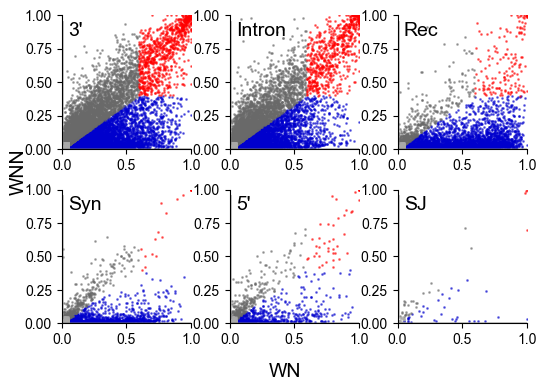

./Tables_DATA/Fig_6d.tab
./Tables_DATA/Fig_6d_Weighted_Avgs_Stats.tab


WN_ef        WNN_ef         WN_dp        WNN_dp
count  35857.000000  35857.000000  35857.000000  35857.000000
mean       0.254453      0.134910    619.906267    618.076972
std        0.241495      0.187817   1176.010783   1228.670134
min        0.010005      0.010009     10.000000     10.000000
25%        0.064516      0.023810     74.000000     79.000000
50%        0.163636      0.057778    191.000000    208.000000
75%        0.384328      0.156250    581.000000    581.000000
max        1.000000      1.000000   8618.000000  13667.000000

In [84]:
To_select_2 =  ADAR_Albertin[(ADAR_Albertin.WN_dp>=10) &(ADAR_Albertin.WNN_dp>=10) & (ADAR_Albertin.WNN_ef>.01)& (ADAR_Albertin.WN_ef>.01) & ADAR_Albertin.ID.isin(EF_Albertin[(EF_Albertin.T.max()>0.01 )].index.to_list())].ID.to_list()   ### Updated on 02/2022

To_plot = copy.copy(ADAR_Albertin[ADAR_Albertin.ID.isin(To_select_2)])
print ("# sites:", len(To_select_2))

figsize =(6,4) #12x15
plt.figure(figsize=figsize)

Features_ = To_plot.Effect.value_counts().index.to_list()

for i in range(1, len(Features_)+1):
    ax = plt.subplot(2, 3, i)
    plt.xlim(0,1)
    plt.ylim(0,1)
    for j in To_plot['Edit_type'].value_counts().index.to_list():
        Tpk  = To_plot[(To_plot['Edit_type'] ==j) & (To_plot['Effect']==Features_[i-1])]
        ax.scatter(Tpk.WN_ef,Tpk.WNN_ef, color = color_editKind_2[j], alpha=0.5, s=1)
    ax.text(0.05, .85,  str((Features_[i-1])), ha='left',fontsize=14)
    ax.axvline(0, color='grey', alpha=0.5, ymax=.95, ymin=.05)
    ax.axhline(0, color='grey', alpha=0.5)
ax.text(-1,-.4,'WN', fontsize=14)
ax.text(-3,1.2,'WNN', fontsize=14, rotation=90)

plt.savefig('Fig_6d__SELECTED.png', bbox_inches='tight', dpi=900)
plt.savefig('Fig_6d__SELECTED.pdf', bbox_inches='tight') 

plt.show()

out_table(To_plot[['ID','Edit_type','Effect','WN_ef', 'WNN_ef', 'WN_dp', 'WNN_dp']], 'Fig_6d.tab')  ### Fig_S8a is correct
Fig4d_Stats = To_plot[['ID','Edit_type','Effect','WN_ef', 'WNN_ef', 'WN_dp', 'WNN_dp']].describe()
out_table(Fig4d_Stats, 'Fig_6d_Weighted_Avgs_Stats.tab')  
Fig4d_Stats

#pd.DataFrame(To_plot[['ID','Edit_type','Effect','WN_ef', 'WNN_ef', 'WN_dp', 'WNN_dp']].describe())

In [12]:
Fig4d_Stats_WN = pd.DataFrame(To_plot[['ID','Edit_type','Effect','WN_ef', 'WNN_ef', 'WN_dp', 'WNN_dp']].groupby('Effect')['WN_ef'].describe())
out_table(Fig4d_Stats_WN, 'Fig_6d_WN_Stats.tab')  ### Fig_S6d is correct
Fig4d_Stats_WN

#pd.DataFrame(To_plot[['ID','Edit_type','Effect','WN_ef', 'WNN_ef', 'WN_dp', 'WNN_dp']].describe())

./Tables_DATA/Fig_6d_WN_Stats.tab


count      mean       std       min       25%       50%       75%  \
Effect                                                                        
3'      17525.0  0.212666  0.219884  0.010005  0.051724  0.126923  0.298507   
5'       1047.0  0.243545  0.234484  0.010163  0.063494  0.153509  0.355637   
Intron   9874.0  0.244110  0.231406  0.010033  0.071429  0.160714  0.346774   
Rec      5535.0  0.406188  0.268689  0.010027  0.156526  0.395833  0.625000   
SJ         84.0  0.243892  0.271169  0.010101  0.051160  0.105349  0.367977   
Syn      1792.0  0.258301  0.227591  0.010015  0.063039  0.188010  0.405667   

        max  
Effect       
3'      1.0  
5'      1.0  
Intron  1.0  
Rec     1.0  
SJ      1.0  
Syn     1.0

In [13]:
Fig4d_Stats_WNN = pd.DataFrame(To_plot[['ID','Edit_type','Effect','WN_ef', 'WNN_ef', 'WN_dp', 'WNN_dp']].groupby('Effect')['WNN_ef'].describe())
out_table(Fig4d_Stats_WNN, 'Fig_6d_WNN_Stats.tab')  ### Fig_6d is correct
Fig4d_Stats_WNN

./Tables_DATA/Fig_6d_WNN_Stats.tab


count      mean       std       min       25%       50%       75%  \
Effect                                                                        
3'      17525.0  0.139109  0.191182  0.010009  0.025278  0.060484  0.160622   
5'       1047.0  0.111303  0.158200  0.010101  0.020609  0.050226  0.123408   
Intron   9874.0  0.172309  0.209261  0.010017  0.035714  0.087610  0.217203   
Rec      5535.0  0.079070  0.133902  0.010014  0.016466  0.030534  0.074140   
SJ         84.0  0.138703  0.210759  0.010101  0.029785  0.060302  0.156625   
Syn      1792.0  0.073873  0.116360  0.010021  0.016667  0.030142  0.071429   

        max  
Effect       
3'      1.0  
5'      1.0  
Intron  1.0  
Rec     1.0  
SJ      1.0  
Syn     1.0

(35857, 41)


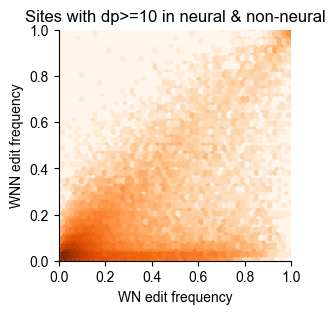

./Tables_DATA/Fig_S8a.tab
./Tables_DATA/Fig_S8a_Stats.tab


In [14]:
### Fig_4D__SELECTED


To_plot__ = ADAR_Albertin[(ADAR_Albertin.WN_dp>=10) &(ADAR_Albertin.WNN_dp>=10) & (ADAR_Albertin.WNN_ef>.01)& (ADAR_Albertin.WN_ef>.01) & ADAR_Albertin.ID.isin(EF_Albertin[(EF_Albertin.T.max()>0.01 )].index.to_list())]
print (To_plot__.shape)
x = To_plot__.WN_ef.to_list()
y = To_plot__.WNN_ef.to_list()

plt.figure(figsize=(3,3))
plt.hexbin(x,y,  gridsize=50, bins='log', cmap='Oranges')
plt.xlabel('WN edit frequency')
plt.ylabel('WNN edit frequency')
plt.title('Sites with dp>=10 in neural & non-neural')

plt.xlim(0,1); plt.ylim(0,1)
plt.savefig('Fig_S8a_DensityScat.pdf', bbox_inches='tight')#, dpi=900)
plt.savefig('Fig_S8a_DensityScat.png', bbox_inches='tight', dpi=900)
plt.show()


out_table(To_plot__[['ID','WN_ef', 'WNN_ef', 'WN_dp', 'WNN_dp']], 'Fig_S8a.tab')  ### Fig_S8a is correct
out_table(To_plot__[['ID','WN_ef', 'WNN_ef', 'WN_dp', 'WNN_dp']].describe(), 'Fig_S8a_Stats.tab')  ### Fig_S8a is correct


In [15]:

To_plot = copy.copy(ADAR_Albertin[ADAR_Albertin.ID.isin(To_select_ubiq_expr)])
print ("# sites:", len(To_select_ubiq_expr))


# sites: 95961


In [16]:
# This function obtains the frequency distribution of edit frequencies for absolute values (in log2 scale) and cummulative.

set_pub()
    
def plot_edit_freq_histograms(Effect_type):
    '''
    Plot Fig.S7c: log2(frequency) and cummulative distribution of edit frequencies.
    '''
    ### 1. Obtain the log2 values for WN edit frequencies and convert -1 missing values.
    To_plot = ((ADAR_Albertin[ADAR_Albertin.Effect==Effect_type].WN_ef*100).fillna(-1).astype(int).value_counts().sort_index()).reset_index()#.plot(kind='bar');
    To_plot['WN_log'] = To_plot.WN_ef.apply(lambda x: np.log10(x))
    To_plot_A = To_plot
    
    ### 2. Do the same ofr WNN
    To_plot = ((ADAR_Albertin[ADAR_Albertin.Effect==Effect_type].WNN_ef*100).fillna(-1).astype(int).value_counts().sort_index()).reset_index()#.plot(kind='bar');
    To_plot['WNN_log'] = To_plot.WNN_ef.apply(lambda x: np.log10(x))
    To_plot_B = To_plot
    
    ### 3. Merge tables.
    To_plot  =pd.merge(To_plot_A, To_plot_B, left_on='index', right_on='index').loc[1:]
    for i in To_plot.index.to_list():
        To_plot.loc[i,'Cum_WN_ef'] = To_plot[0:i].WN_ef.sum()/ To_plot.WN_ef.sum()
        
    for i in To_plot.index.to_list():
        To_plot.loc[i,'Cum_WNN_ef'] = To_plot[0:i].WNN_ef.sum()/ To_plot.WN_ef.sum()
        

    ### 3. Plot distributions
    plt.figure(figsize=(6,3))
    
    
    ax2 = plt.subplot(1,2,1)
    ax2.scatter(To_plot['index'], To_plot['WNN_log'] , s=10, label='Weighted Non-Neural', color='orange', alpha=0.5, marker='.')
    ax2.scatter(To_plot['index'], To_plot['WN_log'] , s=10, label='Weighted Neural',color='blue', alpha=0.5,marker='.')
    original_ticks = ax2.get_yticks()
    ax2.set_yticklabels(pd.Series(original_ticks).apply(lambda x: int(10**float(x))).to_list(), )#)


    plt.ylabel('Frequency') 
    
    ax3 = plt.subplot(1,2,2)
    ax3.scatter(To_plot['index'], To_plot['Cum_WN_ef'] , s=10, label='Neural', color='blue', alpha=0.5,marker='.')
    ax3.scatter(To_plot['index'], To_plot['Cum_WNN_ef'] , s=10, label='Non-Neural',color='orange', alpha=0.5,marker='.')
    plt.ylabel('Cummulative Frequency')
    plt.suptitle(Effect_type, fontsize=16)
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=False)
    
    plt.xlim(-1,101)
    plt.legend(bbox_to_anchor=(1,1))
    
    print (To_plot_A.shape[0], To_plot_B.shape[0])
    To_plot=To_plot.rename(columns={'index':'EditFreq'})
    out_table_noIndex(To_plot, ''.join(('Fig_S7c_',Effect_type,'.tab')).replace("'","prime"))


    return(plt)

def stats_Fig7C(Effect_type):
    sum_wn=(ADAR_Albertin[ADAR_Albertin.Effect==Effect_type].WN_ef*100).fillna(-1).astype(int).value_counts().sort_index()[1:].describe()
    sum_wnn=(ADAR_Albertin[ADAR_Albertin.Effect==Effect_type].WNN_ef*100).fillna(-1).astype(int).value_counts().sort_index()[1:].describe()
    #print (sum_wn)
    sum_wn=pd.DataFrame(sum_wn)
    sum_wnn=pd.DataFrame(sum_wnn)
    
    sum_wn.loc['Effect_type',:] = Effect_type
    sum_wnn.loc['Effect_type',:] = Effect_type
    return(Effect_type,sum_wn,sum_wnn) 

In [17]:


Stats_Fig_7c = pd.DataFrame()
for i in ADAR_Albertin.Effect.unique():
    I = stats_Fig7C(i)
    Stats_Fig_7c=Stats_Fig_7c.append(I[1].T)
    Stats_Fig_7c=Stats_Fig_7c.append(I[2].T)
    
Stats_Fig_7c=Stats_Fig_7c[['Effect_type','count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
Stats_Fig_7c.index = Stats_Fig_7c.index.rename('WeightedAverage')

out_table(Stats_Fig_7c, 'Fig_S7c_Stats.tab')

Stats_Fig_7c


./Tables_DATA/Fig_S7c_Stats.tab


Effect_type count     mean      std min   25%    50%    75%  \
WeightedAverage                                                               
WN_ef                   Rec   100   770.01  3324.91   6    71  136.5  290.5   
WNN_ef                  Rec    97  791.753  7167.63   1     3      8     36   
WN_ef                   Syn    97   425.67  1946.01   1    14     33    127   
WNN_ef                  Syn    77  535.584  4452.53   1     2      5     18   
WN_ef                    3'   101  540.366  1763.85  18    40     97    269   
WNN_ef                   3'   101  539.693  3429.56  11    26     45    128   
WN_ef                    5'    97  79.6082  243.869   1     5     14     44   
WNN_ef                   5'    84  90.6071  686.086   1  1.75      4     11   
WN_ef                Intron   101  315.584  669.054   7    40     88    302   
WNN_ef               Intron   101  306.475  1754.77  12    24     49    145   
WN_ef                    SJ    59  7.47458  21.4616   1     1      2      4   
WNN_ef                   SJ    38  11.5789  54.1503   1     1      2      3   

                   max  
WeightedAverage         
WN_ef            31174  
WNN_ef           70620  
WN_ef            17815  
WNN_ef           39091  
WN_ef            15574  
WNN_ef           34297  
WN_ef             1999  
WNN_ef            6294  
WN_ef             5482  
WNN_ef           17633  
WN_ef              156  
WNN_ef             336

101 98
./Tables_DATA/Fig_S7c_Rec.tab


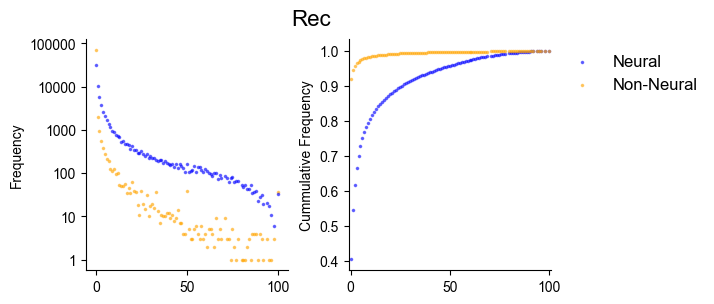

98 78
./Tables_DATA/Fig_S7c_Syn.tab


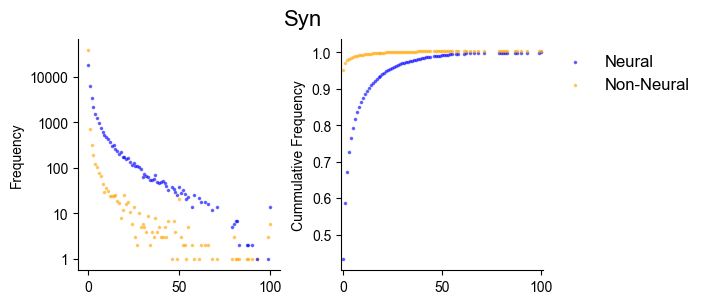

102 102
./Tables_DATA/Fig_S7c_3prime.tab


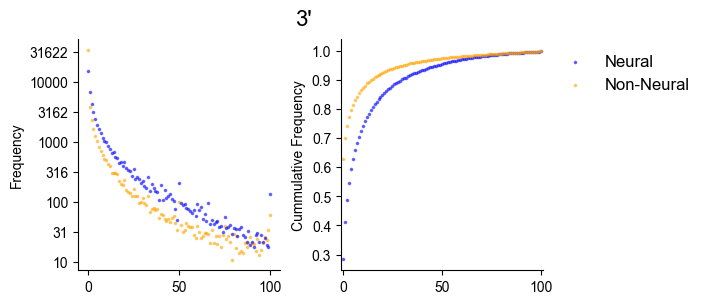

98 85
./Tables_DATA/Fig_S7c_5prime.tab


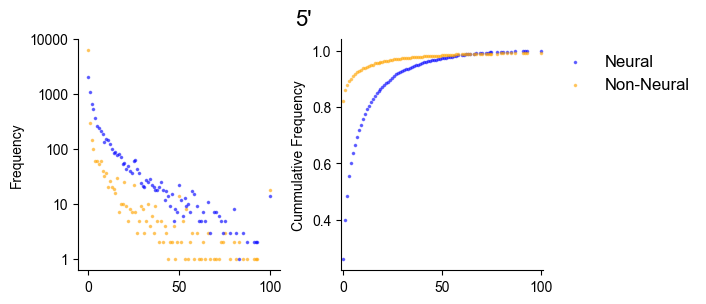

102 102
./Tables_DATA/Fig_S7c_Intron.tab


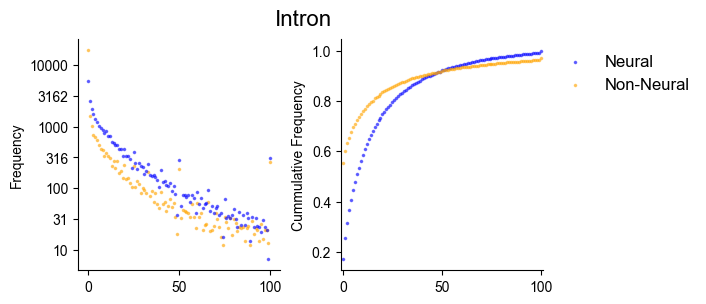

60 39
./Tables_DATA/Fig_S7c_SJ.tab


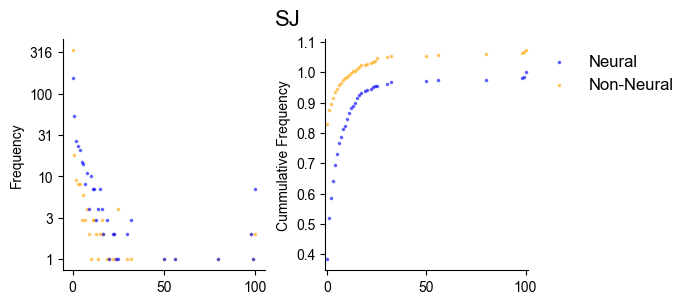

In [18]:
for i in ADAR_Albertin.Effect.unique():
    plot_edit_freq_histograms(i); 
    plt.savefig(''.join(('Fig_7c__',i,'.pdf')), bbox_inches='tight')#, dpi=300)
    plt.show()

In [19]:

To_plot1 = EF_Albertin.loc[ADAR_Albertin[(ADAR_Albertin.Effect=='Rec')].ID.to_list()].fillna(-1).sort_values(['GFL','SG','OLe'])
print (To_plot1.shape[0], 'Albertin Recoding sites')

To_plot2 = EF_Alon.loc[ADAR_Alon[(ADAR_Alon.Effect=='Rec')].ID.to_list()].fillna(-1).sort_values(['GFLr','SGr','OLr'])
print (To_plot2.shape[0], 'Alon Recoding sites')


To_plot3 = pd.merge(To_plot1, To_plot2, left_index=True, right_index=True).sort_values(['GFLr','SGr','OLr'])
print (To_plot3.shape[0], 'Alon & Albertin -  Recoding sites')


77082 Albertin Recoding sites
50320 Alon Recoding sites
43760 Alon & Albertin -  Recoding sites


### Scatterplot and correlations of edit frequencies on recoding identified in Alon and Albertin RNA-seq datasets.


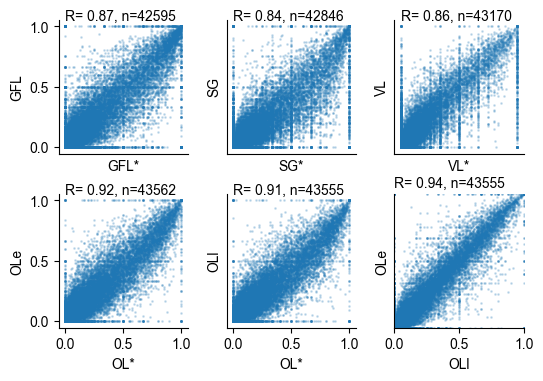

./Tables_DATA/Fig_S7b.tab


In [20]:
pairs_samples =[('GFLr', 'GFL'),  ('SGr', 'SG'), ('VLr', 'VL'), ('OLr', 'OLe'), ('OLr', 'OLl'), ('OLl', 'OLe')]

fig, axs = plt.subplots(2,3, figsize=(6,4))

for i in range(0,len(pairs_samples),1):
    x = To_plot3[pairs_samples[i][0]][(To_plot3[pairs_samples[i][0]]>=0) & (To_plot3[pairs_samples[i][1]]>=0)]
    y = To_plot3[pairs_samples[i][1]][(To_plot3[pairs_samples[i][0]]>=0) & (To_plot3[pairs_samples[i][1]]>=0)]
    correl =  np.corrcoef(x,y)[0,1]
    Pcorrel = ''.join(('R= ', str(np.round(correl,2))))
            
    axs[int(i/3), np.mod(i,3)].scatter(x, y, s=1, alpha=0.2)
    axs[int(i/3), np.mod(i,3)].text(0,1.05,''.join((Pcorrel,', n=',str(len(x)))))#, fontsize=14)
    axs[int(i/3), np.mod(i,3)].set_xlabel(pairs_samples[i][0].replace('r','*'))#,fontsize=16)
    axs[int(i/3), np.mod(i,3)].set_ylabel(pairs_samples[i][1])#,fontsize=16)
    if i<3:
        axs[int(i/3), np.mod(i,3)].set_xticks([])
    if np.mod(i,3)>0:
        axs[int(i/3), np.mod(i,3)].set_yticks([])
    plt.xlim(0,1)
    plt.ylim(0,1)
plt.savefig('Fig_S7b_Replicates.pdf',  bbox_inches='tight')
#plt.savefig('Fig_S7b_Replicates.png',  bbox_inches='tight', dpi=600)

plt.show()


To_plot3.head()
out_table(To_plot3,'Fig_S7b.tab') #S7B is correct
### Fig_S7B

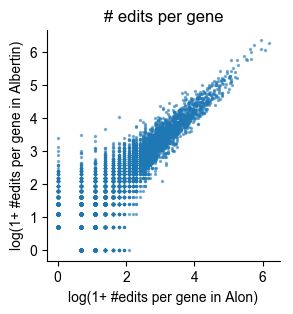

./Tables_DATA/Fig_S7a.tab
./Tables_DATA/Fig_S7a_Stats.tab


In [21]:
Coding_edits_R_C= pd.merge(ADAR_Albertin[ADAR_Albertin.Effect.isin(['Rec','Syn'])].GeneID.value_counts().reset_index(),ADAR_Alon[ADAR_Alon.Effect.isin(['Rec','Syn'])].GeneID.value_counts().reset_index(), left_on='index', right_on='index', how='outer').fillna(0)
Coding_edits_R_C = Coding_edits_R_C.rename(columns={'GeneID_x':'Albertin','GeneID_y':'Alon'})
Coding_edits_R_C = pd.merge(Coding_edits_R_C, Gene_description[['HUGO','transcriptName']], left_on='index', right_on='transcriptName')
Coding_edits_R_C = Coding_edits_R_C.fillna('')

plt.figure(figsize=(3,3))
plt.scatter(np.log(1+Coding_edits_R_C.Alon ),np.log(1+Coding_edits_R_C.Albertin), s=2, alpha=0.5)
plt.ylabel('log(1+ #edits per gene in Albertin)')
plt.xlabel('log(1+ #edits per gene in Alon)')
plt.title('# edits per gene')
plt.savefig('Fig_S7a_Replicates.pdf',  bbox_inches='tight')
#plt.savefig('Fig_S6C_Replicates.png',  bbox_inches='tight', dpi=600)


plt.show()




out_table(Coding_edits_R_C, 'Fig_S7a.tab')  ### Fig_S7a is correct
out_table(Coding_edits_R_C[['Albertin','Alon']].describe(), 'Fig_S7a_Stats.tab') ### Fig_S7a is correct
### Fig_S6B_2

### The Clustering of samples by overall edit frequency reveals that neural samples and non-neural samples segregate (with the exception of ANC and Retina)

In [22]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

def set_heatmap_parameters(cm):
    '''
    Plot parameters for heatmap
    '''
    col = cm.ax_col_dendrogram.get_position()
    cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height*0.4])
    ccol_pos = cm.ax_col_colors.get_position()
    cm.ax_col_colors.set_position([ccol_pos.x0,ccol_pos.y0,ccol_pos.width,ccol_pos.height])
    rcol_pos = cm.ax_row_colors.get_position()
    cm.ax_row_colors.set_position([rcol_pos.x0-.05,rcol_pos.y0,rcol_pos.width+.05,rcol_pos.height])
    cm.cax.set_position([0.2, .7125, .025, .08])  
    cm.cax.set_ylim(0,1)
    cm.cax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
    cm.ax_heatmap.set_ylabel('')#Edit sites')
    cm.ax_heatmap.set_xlabel('')
    return(cm)

13578 Edit sites with 4 or more reads in all samples and 5% or more edit frequency in all samples
13578 Sites with 4 or more reads in all samples and 5% or more edit frequency in all samples


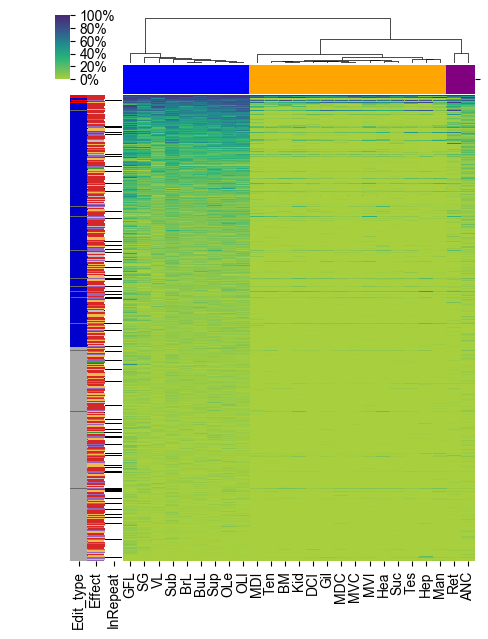

./Tables_DATA/Fig6a_data.tab


In [23]:
color_samples = dict(zip(Neural_samples+NotNeu_samples,['blue']*len(Neural_samples) + ['orange']*len(NotNeu_samples)) )
color_samples['Ret'] = 'purple'
color_samples['ANC'] = 'purple'

To_plot_sns = pd.merge(EF_Albertin[(DP_Albertin.T.min()>=4) & (EF_Albertin.T.max()>.05)], Weighted_values[['WN_ef','WNN_ef']], left_index=True, right_index=True).fillna(-1).sort_values(['WN_ef','WNN_ef'], ascending=[False,True])

linkage = hc.linkage(To_plot_sns[Neural_samples+NotNeu_samples].corr(), method='average')

print (To_plot_sns.shape[0], 'Edit sites with 4 or more reads in all samples and 5% or more edit frequency in all samples')

#To_plot_sns = pd.merge(EF_Albertin[(DP_Albertin.T.min()>=4) & (EF_Albertin.T.max()>.05)], Weighted_values[['WN_ef','WNN_ef']], left_index=True, right_index=True).fillna(-1).sort_values(['WN_ef','WNN_ef'], ascending=[False,True])
sorted_idx = To_plot_sns.index.to_list()
print (len(sorted_idx),'Sites with 4 or more reads in all samples and 5% or more edit frequency in all samples')

col_colors = To_plot_sns.columns.to_series().map(color_samples)
row_colors = pd.DataFrame([ADAR_Albertin[ADAR_Albertin.ID.isin(sorted_idx)]['Edit_type'].map(color_editKind_2) ,ADAR_Albertin[ADAR_Albertin.ID.isin(sorted_idx)]['Effect'].map(color_Kind_cb),ADAR_Albertin[ADAR_Albertin.ID.isin(sorted_idx)]['InRepeat'].map({True:'black',False:'white'})]).T
row_colors = pd.merge(ADAR_Albertin['ID'],row_colors,left_index=True, right_index=True).set_index('ID')
row_colors.head()

cm =  sns.clustermap(To_plot_sns[Neural_samples+NotNeu_samples].fillna(-1) ,  cmap=col_blind,  metric='correlation', method='average', col_linkage=linkage, row_cluster=False,  yticklabels=False ,vmin=-1, vmax=1, xticklabels=True,row_colors=row_colors, col_colors=col_colors, figsize=(6,8))
set_heatmap_parameters(cm)
#plt.savefig('Fig_6a_EdifFreq_heatmap_4orMoreReads_minEF5pct.png', bbox_inches='tight', dpi=900)

plt.savefig('Fig_6a_EdifFreq_heatmap_4orMoreReads_minEF5pct.pdf', bbox_inches='tight')

plt.show()

out_table(To_plot_sns[Neural_samples+NotNeu_samples].fillna(-1), 'Fig_6a_data.tab')


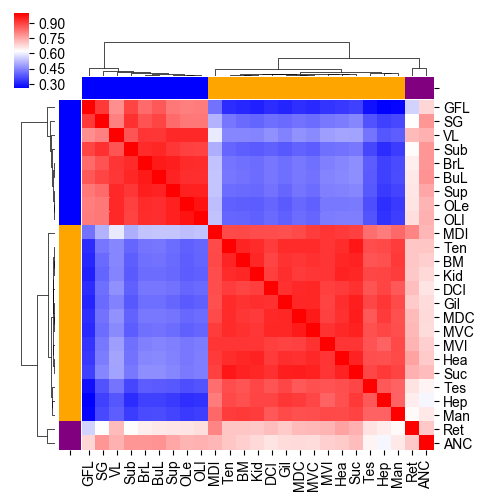

./Tables_DATA/Fig6b_data.tab


In [24]:
hm = sns.clustermap(To_plot_sns[Neural_samples+NotNeu_samples].corr(), col_linkage=linkage,   cmap='bwr', col_colors=To_plot_sns[Neural_samples+NotNeu_samples].columns.to_series().map(color_samples), row_colors=To_plot_sns[Neural_samples+NotNeu_samples].columns.to_series().map(color_samples),yticklabels=True, xticklabels=True, figsize=(6,6));
col = hm.ax_col_dendrogram.get_position()
hm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height*0.4])
row = hm.ax_row_dendrogram.get_position()
hm.ax_row_dendrogram.set_position([row.x0+.085, row.y0, row.width*.4, row.height])
hm.cax.set_position([0.2, .7125, .025, .125]) 
plt.savefig('Fig_6b_Correlation_heatmap.pdf', bbox_inches='tight')
#plt.savefig('Fig_4B_Correlation_heatmap.png', bbox_inches='tight', dpi=900)
plt.show()

### Fig_4A_ & 4B
#13578 Sites with 4 or more reads in all samples and 0.05 or more edit frequency in all samples
out_table(To_plot_sns[Neural_samples+NotNeu_samples].corr(), 'Fig_6b_data.tab')

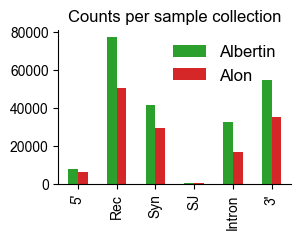

In [25]:
#Comparison of the number of edit sites identified from two different datasets: Current study and Alon et al., 2015.

Counts_Albertin = pd.DataFrame(ADAR_Albertin.Effect.value_counts()).rename(columns={'Effect':'Albertin'})
Counts_Alon = pd.DataFrame(ADAR_Alon.Effect.value_counts()).rename(columns={'Effect':'Alon'})

Effect_counts = pd.merge(Counts_Albertin, Counts_Alon, left_index=True, right_index=True).T[["5'",'Rec','Syn','SJ','Intron',"3'"]].T

Effect_counts.plot(kind='bar', color=Effect_counts.index.to_series().map(color_Kind_cb), figsize=(3,2))
plt.title('Counts per sample collection')
plt.show()


### Constitutively expressed sites:
    Sites with at least 5 or more reads in all tissue samples.

In [26]:
Feature_by_counts=dict()
Feature_by_counts_inRep=dict()
for i in Weighted_values.Edit_type.value_counts().index.to_list():
    To_plot_sns = pd.merge(EF_Albertin[EF_Albertin.index.isin(DP_Albertin[DP_Albertin.T.min()>=5].index.to_list())], Weighted_values[Weighted_values.Edit_type==i][['WN_ef','WNN_ef']], left_index=True, right_index=True).fillna(-1).sort_values(['WN_ef','WNN_ef'], ascending=[False,True])
    print (i, To_plot_sns.shape[0])
    Feature_by_counts[i] = ADAR_Albertin.loc[ADAR_Albertin.ID.isin(To_plot_sns.index.to_list())].Effect.value_counts()
    Feature_by_counts_inRep[i] = ADAR_Albertin.loc[ADAR_Albertin.ID.isin(To_plot_sns.index.to_list())].groupby('Effect').InRepeat.value_counts()


Ubiq-Low 42309
Neural 5462
Ubiq-Med 255
Ubiq-High 46


In [30]:
To_plot_hm = ADAR_Albertin[ADAR_Albertin.ID.isin(To_select)].sort_values(['Edit_type','Sum_EF'], ascending=[True,False]).set_index('ID')

To_plot_hm.Edit_type = To_plot_hm.Edit_type.fillna('')
To_plot_hm.Edit_type = pd.Categorical(To_plot_hm.Edit_type, 
                      categories=['Ubiq-High', 'Ubiq-Med','Ubiq-Low', 'Neural', '' ],
                      ordered=True)
To_plot_hm.head()

Unnamed: 0 Ref Allele Effect          GeneID        FeatureID  \
ID                                                                              
Dpe23:68954139     3817992   A      G    Rec  Dopeav2079712m  PAC4GC:38620199   
Dpe37:27038455     5536723   A      G    Rec  Dopeav2118106m  PAC4GC:38679422   
Dpe37:27034380     5536684   A      G    Rec  Dopeav2118106m  PAC4GC:38679422   
Dpe15:71934082     2545231   A      G    Rec  Dopeav2053988m  PAC4GC:38562632   
Dpe27:29268727     4267497   T      C    Rec  Dopeav2090483m  PAC4GC:38628065   

                       Biotype Rank       GVSc         GVSp  ...   gVar  \
ID                                                           ...          
Dpe23:68954139  protein_coding  3/3   c.332A>G  p.Lys111Arg  ...  False   
Dpe37:27038455  protein_coding  9/9  c.1583A>G  p.Tyr528Cys  ...  False   
Dpe37:27034380  protein_coding  7/9   c.874A>G  p.Ile292Val  ...  False   
Dpe15:71934082  protein_coding  1/1   c.527A>G  p.Asn176Ser  ...  False   
Dpe27:29268727  protein_coding  1/4    c.70A>G   p.Arg24Gly  ...  False   

                 gVAR     WN_ef    WNN_ef  WN_dp  WNN_dp  WN_ef_ratio  \
ID                                                                      
Dpe23:68954139  False  0.987495  0.383333   7117     180     0.720364   
Dpe37:27038455  False  0.976814  0.292683   1337      41     0.769450   
Dpe37:27034380  False  0.968300  0.238806   1735      67     0.802166   
Dpe15:71934082  False  0.938736  0.250000   6219      88     0.789693   
Dpe27:29268727  False  0.935439  0.136364   1425      22     0.872772   

               Edit_type    Sum_EF Category  
ID                                           
Dpe23:68954139    Neural  0.972259   Robust  
Dpe37:27038455    Neural  0.956741   Robust  
Dpe37:27034380    Neural  0.940627   Robust  
Dpe15:71934082    Neural  0.928408   Robust  
Dpe27:29268727    Neural  0.923181   Robust  

[5 rows x 40 columns]

In [31]:
To_plot_hm = To_plot_hm.sort_values(['Edit_type','Sum_EF'], ascending=[True,False])
sorted_idx = To_plot_hm.index.to_list()
print (len(sorted_idx), '# sites clustered')
row_colors = pd.DataFrame(To_plot_hm['Edit_type'].map(color_editKind_2))
col_colors = EF_Albertin[Neural_samples+NotNeu_samples].columns.to_series().map(color_samples)


197549 # sites clustered


In [32]:
Feature_by_counts=dict()
Feature_by_counts_inRep=dict()
for i in Weighted_values.Edit_type.value_counts().index.to_list():
    To_plot_sns = pd.merge(EF_Albertin, Weighted_values[Weighted_values.Edit_type==i][['WN_ef','WNN_ef']], left_index=True, right_index=True).fillna(-1).sort_values(['WN_ef','WNN_ef'], ascending=[False,True])
    print (i, To_plot_sns.shape[0])
    Feature_by_counts[i] = ADAR_Albertin.loc[ADAR_Albertin.ID.isin(To_plot_sns.index.to_list())].Effect.value_counts()
    Feature_by_counts_inRep[i] = ADAR_Albertin.loc[ADAR_Albertin.ID.isin(To_plot_sns.index.to_list())].groupby('Effect').InRepeat.value_counts()

    #sns.clustermap(To_plot_sns[Neural_samples+NotNeu_samples], yticklabels=False, row_cluster=False, vmin=-1, vmax=1, cmap=col_blind, col_linkage=linkage, col_colors= To_plot_sns.columns.to_series().map(color_samples))#, cmap='bwr')
    #plt.show()
    


Ubiq-Low 132059
Neural 62491
Ubiq-Med 13962
Ubiq-High 2371


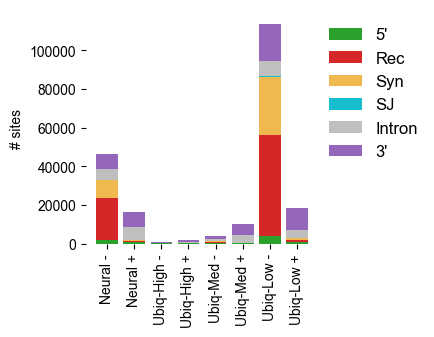

./Tables_DATA/Fig_S8b.tab


In [33]:
#Fig. S8b

To_plt_Kind  = ADAR_Albertin.groupby(['InRepeat','Effect'])['Edit_type'].value_counts().unstack().fillna(0)

To_plt_NoRep = To_plt_Kind.loc[0]#.append(To_plt_SubKind.loc[0]).loc[["5'", 'Rec', 'Syn', 'SJ', 'Intron', "3'"]]
To_plt_InRep = To_plt_Kind.loc[1]#.append(To_plt_SubKind.loc[1]).loc[["5'", 'Rec', 'Syn', 'SJ', 'Intron', "3'"]]
#To_plt_InRep = 

order_EdTypes = ['Neural -', 'Neural +',
 'Ubiq-High -','Ubiq-High +', 
 'Ubiq-Med -', 'Ubiq-Med +',
 'Ubiq-Low -', 'Ubiq-Low +']

To_plot   = To_plt_InRep
new_cols = To_plt_InRep.columns.to_series().apply(lambda x: ''.join((x,' +'))).to_dict()
To_plot_Y =  To_plot.rename(columns =new_cols)
To_plot_Y

To_plot   = To_plt_NoRep
new_cols = To_plt_NoRep.columns.to_series().apply(lambda x: ''.join((x,' -'))).to_dict()
To_plot_N =  To_plot.rename(columns =new_cols)
To_plot_N

To_plot_  = pd.merge(To_plot_Y,To_plot_N, left_index=True, right_index=True)#y=index)#.sort_index().fillna(0)
To_plot_ = To_plot_[order_EdTypes]
To_plot_

color=color_Kind_cb

To_plot = copy.copy(To_plot_).T

fig, ax = plt.subplots(figsize=(3,3))

first =True
for i in ["5'",'Rec','Syn', 'SJ',  'Intron',  "3'"]:
    i_list =np.array(To_plot[i].to_list())
    if first == True:
        prev_values = np.array(To_plot[i].to_list())
        ax.bar(To_plot.index.to_list(), i_list, label=i , color=color_Kind_cb[i])
        first=False
    else:
        ax.bar(To_plot.index.to_list(), i_list, bottom=prev_values , label=i , color=color_Kind_cb[i])#, color=color_Kind_cb[i.split('\n')[0]])
        prev_values = prev_values +np.array(To_plot[i].to_list())
        
        
for s in ['top','bottom','right','left']:
    ax.spines[s].set_visible(False)
    
plt.ylabel('# sites')
plt.title('', fontsize=12)
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
ax.legend(bbox_to_anchor=(.98,1), loc=2, frameon=False)#, fontsize=10)

ax.set_xticklabels(To_plot.index.to_list(),rotation=90)
fig_name= ''.join(('Fig_S8b_EditType_Rep_Position_all','.pdf'))

plt.savefig(fig_name, bbox_inches='tight')
plt.show()


out_table(To_plot_, 'Fig_S8b.tab')


./Tables_DATA/Fig_6e.tab


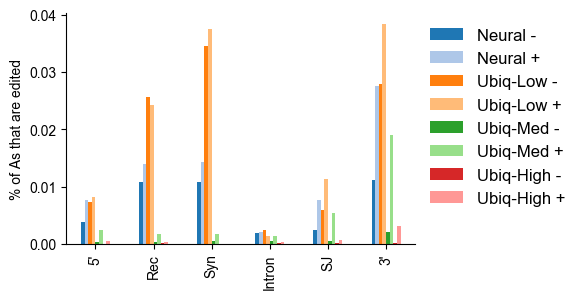

In [34]:
import matplotlib

Adenine_counts_ovrlp_genes = pd.read_csv('../Counts_edits_by_Etype_Repeat_Not_Edited.tab',sep='\t')

order_EdTypes_2 = ['Neural -', 'Neural +','Ubiq-Low -', 'Ubiq-Low +', 'Ubiq-Med -', 'Ubiq-Med +', 'Ubiq-High -', 'Ubiq-High +']

TST1 = copy.copy(To_plt_Kind.T[False])
for i in ["3'","5'","Intron","Rec","SJ","Syn"]:
    TST1[i] = TST1[i]/(TST1[i]+Adenine_counts_ovrlp_genes[Adenine_counts_ovrlp_genes.InRepeat==False][i].to_list()[0])

TST2 = copy.copy(To_plt_Kind.T[True])
for i in ["3'","5'","Intron","Rec","SJ","Syn"]:
    TST2[i] = TST2[i]/(TST2[i]+Adenine_counts_ovrlp_genes[Adenine_counts_ovrlp_genes.InRepeat==True][i].to_list()[0])

    
cmap_ = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab20").colors[:8])
To_plot_pct  = pd.merge(TST1.T,TST2.T, left_index=True, right_index=True, suffixes=[' -'," +"])
To_plot_pct[order_EdTypes_2].T[["5'",'Rec','Syn','Intron','SJ',"3'"]].T.plot(kind='bar',  cmap=cmap_,figsize=(4.5,3))#,, stacked=True) 
plt.ylabel('% of As that are edited')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1,1))
fig_name= ''.join(('Fig_6e_EditType_Rep_Position_all_NormalizedByAllAs','.pdf'))
plt.savefig(fig_name, bbox_inches='tight')
#fig_name= ''.join(('Fig_6e_EditType_Rep_Position_all_NormalizedByAllAs','.png'))
#plt.savefig(fig_name, bbox_inches='tight')
#plt.show()


out_table(To_plot_pct, 'Fig_6e.tab')

In [35]:
Edits_by_count = pd.merge(pd.DataFrame(ADAR_Albertin.Effect.value_counts()), pd.DataFrame(Adenine_counts_ovrlp_genes.sum().iloc[1:]), left_index=True, right_index=True).rename(columns={'Effect':'Edited',0:"Not edited"})
Edits_by_count['Not edited'] = Edits_by_count['Not edited'].astype(int)
Edits_by_count.loc['Total','Edited'] = Edits_by_count['Edited'].sum() 
Edits_by_count.loc['Total','Not edited'] = Edits_by_count['Not edited'].sum() 
Edits_by_count['Sum'] = Edits_by_count['Edited'] + Edits_by_count['Not edited']
Edits_by_count['Fraction edited'] = Edits_by_count['Edited']/Edits_by_count['Sum']
Edits_by_count[['Edited','Not edited', 'Sum']]=Edits_by_count[['Edited','Not edited', 'Sum']].astype(int)
Edits_by_count.sort_index()

Edited  Not edited       Sum  Fraction edited
3'       54743      965035   1019778         0.053681
5'        7762      602413    610175         0.012721
Intron   32652     6192113   6224765         0.005245
Rec      77082     2042141   2119223         0.036373
SJ         444       43249     43693         0.010162
Syn      41334      869070    910404         0.045402
Total   214017    10714021  10928038         0.019584

In [36]:
Edits_by_type = ADAR_Albertin.groupby('Edit_type').Effect.value_counts().unstack().fillna(0).T
Edits_by_type.loc['Total',:]=Edits_by_type.sum()
Edits_by_type

Edit_type   Neural  Ubiq-High  Ubiq-Low  Ubiq-Med
Effect                                           
3'         15642.0     1022.0   30882.0    6845.0
5'          2670.0       56.0    4469.0     382.0
Intron     12296.0     1049.0   11636.0    5566.0
Rec        22268.0      206.0   53596.0     658.0
SJ           120.0       10.0     274.0      33.0
Syn         9495.0       28.0   31202.0     478.0
Total      62491.0     2371.0  132059.0   13962.0

In [37]:
ADAR_Albertin.groupby(['Edit_type','Category']).Effect.value_counts().unstack()

Effect                   3'    5'  Intron    Rec   SJ    Syn
Edit_type Category                                          
Neural    Not_robust   6175  1024    3568   8303   42   4641
          Robust       9467  1646    8728  13965   78   4854
Ubiq-High Robust       1022    56    1049    206   10     28
Ubiq-Low  Not_robust  30273  4368   11099  53182  268  30971
          Robust        609   101     537    414    6    231
Ubiq-Med  Not_robust   1518    60     642    139   11    123
          Robust       5327   322    4924    519   22    355

In [38]:
ADAR_Albertin.groupby(['Category']).Effect.value_counts().unstack().T

Category  Not_robust  Robust
Effect                      
3'             38108   16635
5'              5555    2207
Intron         15914   16738
Rec            61789   15293
SJ               325     119
Syn            35806    5528

In [39]:

ADAR_Albertin.groupby(['Category','Edit_type',]).Effect.value_counts().unstack()#.T

Effect                   3'    5'  Intron    Rec   SJ    Syn
Category   Edit_type                                        
Not_robust Neural      6175  1024    3568   8303   42   4641
           Ubiq-Low   30273  4368   11099  53182  268  30971
           Ubiq-Med    1518    60     642    139   11    123
Robust     Neural      9467  1646    8728  13965   78   4854
           Ubiq-High   1022    56    1049    206   10     28
           Ubiq-Low     609   101     537    414    6    231
           Ubiq-Med    5327   322    4924    519   22    355

In [40]:
ADAR_Albertin[(ADAR_Albertin['Category']=='Robust') & (ADAR_Albertin['Effect']=='Rec')].GeneID.value_counts().shape


(5061,)

In [41]:
genes_with_robust_edits = ADAR_Albertin[(ADAR_Albertin.Category=='Robust') & (ADAR_Albertin['Effect'].isin(['Rec','Syn']))].GeneID.unique()#.shape
genes_with_not_robust_edits = ADAR_Albertin[~(ADAR_Albertin['GeneID'].isin(genes_with_robust_edits)) & (ADAR_Albertin['Effect'].isin(['Rec','Syn']))].GeneID.unique()
print (len(genes_with_not_robust_edits)) #4055 genes have no robust edits.
print (len(genes_with_robust_edits)) #5905 genes have at least onerobust edit

4055
5905


In [42]:
VeryLow_edited_sites =  EF_Albertin[EF_Albertin[Neural_samples+NotNeu_samples].T.max()<.02].index.to_list()

ADAR_Albertin['EditTreshold']='Between 2-25%'
ADAR_Albertin.loc[ADAR_Albertin.ID.isin(VeryLow_edited_sites),'EditTreshold']='Below 2%'
ADAR_Albertin.loc[ADAR_Albertin.ID.isin(robustly_edited_sites),'EditTreshold']='Robust >25%'
ADAR_Albertin.EditTreshold.value_counts()
ADAR_Albertin.groupby(['Category','EditTreshold']).Edit_type.value_counts().unstack().fillna(0)

Edit_type                  Neural  Ubiq-High  Ubiq-Low  Ubiq-Med
Category   EditTreshold                                         
Not_robust Below 2%           0.0        0.0   52010.0       0.0
           Between 2-25%  23753.0        0.0   78151.0    2493.0
Robust     Robust >25%    38738.0     2371.0    1898.0   11469.0

In [48]:
VeryLow_edited_sites_WEF =  ADAR_Albertin[ADAR_Albertin.Sum_EF<.02].ID.to_list()

ADAR_Albertin['EditTreshold_WEF']='Between 2-25%'
ADAR_Albertin.loc[ADAR_Albertin.ID.isin(VeryLow_edited_sites_WEF),'EditTreshold_WEF']='Below 2%'
ADAR_Albertin.loc[ADAR_Albertin.ID.isin(robustly_edited_sites),'EditTreshold_WEF']='Robust >25%'
ADAR_Albertin.EditTreshold_WEF.value_counts()
ADAR_Albertin.groupby(['Category','EditTreshold_WEF']).Edit_type.value_counts().unstack().fillna(0)

Edit_type                     Neural  Ubiq-High  Ubiq-Low  Ubiq-Med
Category   EditTreshold_WEF                                        
Not_robust Below 2%           1710.0        0.0  116180.0      29.0
           Between 2-25%     22043.0        0.0   13981.0    2464.0
Robust     Robust >25%       38738.0     2371.0    1898.0   11469.0

In [49]:
VeryLow_edited_sites_WN =  ADAR_Albertin[ADAR_Albertin.WN_ef<0.02].ID.to_list()

ADAR_Albertin['EditTreshold_WN']='Above 2% WN'
ADAR_Albertin.loc[ADAR_Albertin.ID.isin(VeryLow_edited_sites_WN),'EditTreshold_WN']='Below 2% WN'
ADAR_Albertin.EditTreshold_WN.value_counts()
ADAR_Albertin.groupby(['Category','EditTreshold_WN']).Edit_type.value_counts().unstack().fillna(0)

Edit_type                    Neural  Ubiq-High  Ubiq-Low  Ubiq-Med
Category   EditTreshold_WN                                        
Not_robust Above 2% WN      23753.0        0.0   32860.0    1920.0
           Below 2% WN          0.0        0.0   97301.0     573.0
Robust     Above 2% WN      38738.0     2371.0    1342.0   10443.0
           Below 2% WN          0.0        0.0     556.0    1026.0

In [50]:
VeryLow_edited_sites_WNN =  ADAR_Albertin[ADAR_Albertin.WNN_ef<0.02].ID.to_list()

ADAR_Albertin['EditTreshold_WNN']='Above 2% WNN'
ADAR_Albertin.loc[ADAR_Albertin.ID.isin(VeryLow_edited_sites_WNN),'EditTreshold_WNN']='Below 2% WNN'
ADAR_Albertin.EditTreshold_WNN.value_counts()
ADAR_Albertin.groupby(['Category','EditTreshold_WNN']).Edit_type.value_counts().unstack().fillna(0)

Edit_type                     Neural  Ubiq-High  Ubiq-Low  Ubiq-Med
Category   EditTreshold_WNN                                        
Not_robust Above 2% WNN       1837.0        0.0    3333.0    2493.0
           Below 2% WNN      21916.0        0.0  126828.0       0.0
Robust     Above 2% WNN      12118.0     2371.0     656.0   11469.0
           Below 2% WNN      26620.0        0.0    1242.0       0.0

In [51]:

ADAR_Albertin.loc[~ADAR_Albertin.cDNA_pos_len.isna(),'CDSpos'] = ADAR_Albertin.loc[~ADAR_Albertin.cDNA_pos_len.isna()].cDNA_pos_len.apply(lambda x: int(str(x).split('/')[0]))
ADAR_Albertin.loc[~ADAR_Albertin.cDNA_pos_len.isna(),'CDSpos']=ADAR_Albertin.loc[~ADAR_Albertin.cDNA_pos_len.isna(),'CDSpos'].astype('int').round(0)
ADAR_Albertin.loc[~ADAR_Albertin.cDNA_pos_len.isna()][['ID','GeneID','Effect','GVSc', 'GVSp', 'cDNA_pos_len', 'CDS_pos_len','Prot_pos_len','EditTreshold','CDSpos']].head(20)

ID          GeneID Effect       GVSc         GVSp cDNA_pos_len  \
0     Dpe01:98571  Dopeav2000002m    Rec  c.2995A>G  p.Ser999Gly    3809/4829   
1    Dpe01:102378  Dopeav2000002m    Syn  c.2718A>G  p.Gln906Gln    3532/4829   
2    Dpe01:102379  Dopeav2000002m    Rec  c.2717A>G  p.Gln906Arg    3531/4829   
3    Dpe01:144873  Dopeav2000002m    Rec  c.2233A>G  p.Asn745Asp    3047/4829   
4    Dpe01:145992  Dopeav2000002m    Rec  c.2114A>G  p.Lys705Arg    2928/4829   
5    Dpe01:156785  Dopeav2000002m    Rec  c.1928A>G  p.Asn643Ser    2742/4829   
6    Dpe01:156786  Dopeav2000002m    Rec  c.1927A>G  p.Asn643Asp    2741/4829   
7    Dpe01:156787  Dopeav2000002m    Syn  c.1926A>G  p.Leu642Leu    2740/4829   
8    Dpe01:317564  Dopeav2000002m    Rec  c.1559A>G  p.Lys520Arg    2373/4829   
9    Dpe01:317881  Dopeav2000002m    Syn  c.1242A>G  p.Ala414Ala    2056/4829   
10   Dpe01:317893  Dopeav2000002m    Syn  c.1230A>G  p.Ala410Ala    2044/4829   
11   Dpe01:318270  Dopeav2000002m    Rec   c.853A>G  p.Ser285Gly    1667/4829   
53  Dpe01:1165240  Dopeav2000027m    Rec   c.490A>G  p.Lys164Glu     811/3385   
54  Dpe01:1165280  Dopeav2000027m    Rec   c.450A>G  p.Ile150Met     771/3385   
55  Dpe01:1332189  Dopeav2000031m    Rec   c.542A>G  p.Lys181Arg      542/606   
56  Dpe01:1401106  Dopeav2000031m    Rec   c.341A>G  p.Asn114Ser      341/606   
57  Dpe01:1401107  Dopeav2000031m    Rec   c.340A>G  p.Asn114Asp      340/606   
58  Dpe01:1401169  Dopeav2000031m    Rec   c.278A>G   p.Lys93Arg      278/606   
59  Dpe01:1401170  Dopeav2000031m    Rec   c.277A>G   p.Lys93Glu      277/606   
60  Dpe01:1401171  Dopeav2000031m    Syn   c.276A>G   p.Lys92Lys      276/606   

   CDS_pos_len Prot_pos_len   EditTreshold  CDSpos  
0    2995/3054     999/1017  Between 2-25%  3809.0  
1    2718/3054     906/1017  Between 2-25%  3532.0  
2    2717/3054     906/1017  Between 2-25%  3531.0  
3    2233/3054     745/1017  Between 2-25%  3047.0  
4    2114/3054     705/1017    Robust >25%  2928.0  
5    1928/3054     643/1017  Between 2-25%  2742.0  
6    1927/3054     643/1017    Robust >25%  2741.0  
7    1926/3054     642/1017  Between 2-25%  2740.0  
8    1559/3054     520/1017  Between 2-25%  2373.0  
9    1242/3054     414/1017  Between 2-25%  2056.0  
10   1230/3054     410/1017    Robust >25%  2044.0  
11    853/3054     285/1017  Between 2-25%  1667.0  
53     490/795      164/264       Below 2%   811.0  
54     450/795      150/264       Below 2%   771.0  
55     542/606      181/201       Below 2%   542.0  
56     341/606      114/201  Between 2-25%   341.0  
57     340/606      114/201       Below 2%   340.0  
58     278/606       93/201    Robust >25%   278.0  
59     277/606       93/201    Robust >25%   277.0  
60     276/606       92/201  Between 2-25%   276.0

In [52]:
ADAR_Albertin.loc[~ADAR_Albertin.cDNA_pos_len.isna(), 'Edit_right'] = [0] + list(np.array(ADAR_Albertin.loc[~ADAR_Albertin.cDNA_pos_len.isna()].CDSpos)[1:] - np.array(ADAR_Albertin.loc[~ADAR_Albertin.cDNA_pos_len.isna()].CDSpos)[:-1] )

In [53]:
ADAR_Albertin.loc[~ADAR_Albertin.cDNA_pos_len.isna(), 'Edit_left'] =  list(np.array(ADAR_Albertin.loc[~ADAR_Albertin.cDNA_pos_len.isna()].CDSpos)[:-1] - np.array(ADAR_Albertin.loc[~ADAR_Albertin.cDNA_pos_len.isna()].CDSpos)[1:] ) + [0]
ADAR_Albertin.loc[~ADAR_Albertin.cDNA_pos_len.isna()][['ID','GeneID','Effect','GVSc', 'GVSp', 'cDNA_pos_len', 'CDS_pos_len','Prot_pos_len','EditTreshold','CDSpos','Edit_right','Edit_left']].head(20)

ID          GeneID Effect       GVSc         GVSp cDNA_pos_len  \
0     Dpe01:98571  Dopeav2000002m    Rec  c.2995A>G  p.Ser999Gly    3809/4829   
1    Dpe01:102378  Dopeav2000002m    Syn  c.2718A>G  p.Gln906Gln    3532/4829   
2    Dpe01:102379  Dopeav2000002m    Rec  c.2717A>G  p.Gln906Arg    3531/4829   
3    Dpe01:144873  Dopeav2000002m    Rec  c.2233A>G  p.Asn745Asp    3047/4829   
4    Dpe01:145992  Dopeav2000002m    Rec  c.2114A>G  p.Lys705Arg    2928/4829   
5    Dpe01:156785  Dopeav2000002m    Rec  c.1928A>G  p.Asn643Ser    2742/4829   
6    Dpe01:156786  Dopeav2000002m    Rec  c.1927A>G  p.Asn643Asp    2741/4829   
7    Dpe01:156787  Dopeav2000002m    Syn  c.1926A>G  p.Leu642Leu    2740/4829   
8    Dpe01:317564  Dopeav2000002m    Rec  c.1559A>G  p.Lys520Arg    2373/4829   
9    Dpe01:317881  Dopeav2000002m    Syn  c.1242A>G  p.Ala414Ala    2056/4829   
10   Dpe01:317893  Dopeav2000002m    Syn  c.1230A>G  p.Ala410Ala    2044/4829   
11   Dpe01:318270  Dopeav2000002m    Rec   c.853A>G  p.Ser285Gly    1667/4829   
53  Dpe01:1165240  Dopeav2000027m    Rec   c.490A>G  p.Lys164Glu     811/3385   
54  Dpe01:1165280  Dopeav2000027m    Rec   c.450A>G  p.Ile150Met     771/3385   
55  Dpe01:1332189  Dopeav2000031m    Rec   c.542A>G  p.Lys181Arg      542/606   
56  Dpe01:1401106  Dopeav2000031m    Rec   c.341A>G  p.Asn114Ser      341/606   
57  Dpe01:1401107  Dopeav2000031m    Rec   c.340A>G  p.Asn114Asp      340/606   
58  Dpe01:1401169  Dopeav2000031m    Rec   c.278A>G   p.Lys93Arg      278/606   
59  Dpe01:1401170  Dopeav2000031m    Rec   c.277A>G   p.Lys93Glu      277/606   
60  Dpe01:1401171  Dopeav2000031m    Syn   c.276A>G   p.Lys92Lys      276/606   

   CDS_pos_len Prot_pos_len   EditTreshold  CDSpos  Edit_right  Edit_left  
0    2995/3054     999/1017  Between 2-25%  3809.0         0.0      277.0  
1    2718/3054     906/1017  Between 2-25%  3532.0      -277.0        1.0  
2    2717/3054     906/1017  Between 2-25%  3531.0        -1.0      484.0  
3    2233/3054     745/1017  Between 2-25%  3047.0      -484.0      119.0  
4    2114/3054     705/1017    Robust >25%  2928.0      -119.0      186.0  
5    1928/3054     643/1017  Between 2-25%  2742.0      -186.0        1.0  
6    1927/3054     643/1017    Robust >25%  2741.0        -1.0        1.0  
7    1926/3054     642/1017  Between 2-25%  2740.0        -1.0      367.0  
8    1559/3054     520/1017  Between 2-25%  2373.0      -367.0      317.0  
9    1242/3054     414/1017  Between 2-25%  2056.0      -317.0       12.0  
10   1230/3054     410/1017    Robust >25%  2044.0       -12.0      377.0  
11    853/3054     285/1017  Between 2-25%  1667.0      -377.0      856.0  
53     490/795      164/264       Below 2%   811.0      -856.0       40.0  
54     450/795      150/264       Below 2%   771.0       -40.0      229.0  
55     542/606      181/201       Below 2%   542.0      -229.0      201.0  
56     341/606      114/201  Between 2-25%   341.0      -201.0        1.0  
57     340/606      114/201       Below 2%   340.0        -1.0       62.0  
58     278/606       93/201    Robust >25%   278.0       -62.0        1.0  
59     277/606       93/201    Robust >25%   277.0        -1.0        1.0  
60     276/606       92/201  Between 2-25%   276.0        -1.0       12.0

In [54]:
gID_ = 'Dopeav2000002m'
min_dist=dict()

min_dist[gID_]=dict()

Robust_sites_ = ADAR_Albertin.loc[(~ADAR_Albertin.cDNA_pos_len.isna()) & (ADAR_Albertin.GeneID==gID_) & ~(ADAR_Albertin.Category=='Robust')]
Not_robust_sites_ = ADAR_Albertin.loc[(~ADAR_Albertin.cDNA_pos_len.isna()) & (ADAR_Albertin.GeneID==gID_) & (ADAR_Albertin.Category=='Robust')]

for idx_0 in Robust_sites_.index.to_list():
    CDSpos_notRub =ADAR_Albertin.loc[idx_0].CDSpos
    edit_freqLabel = ADAR_Albertin.loc[idx_0].EditTreshold_WEF
    for idx_ in  Not_robust_sites_.index.to_list():
        CDSpos_Rub=ADAR_Albertin.loc[idx_].CDSpos
        distance_ = abs(CDSpos_notRub-CDSpos_Rub)
        if i in min_dist.keys():
            min_dist[gID_][edit_freqLabel,CDSpos_notRub] = min(min_dist[CDSpos_notRub],int(distance_))
        else:
            min_dist[gID_][edit_freqLabel,CDSpos_notRub] = distance_
min_dist


{'Dopeav2000002m': {('Between 2-25%', 3809.0): 1765.0,
  ('Below 2%', 3532.0): 1488.0,
  ('Below 2%', 3531.0): 1487.0,
  ('Below 2%', 3047.0): 1003.0,
  ('Between 2-25%', 2742.0): 698.0,
  ('Between 2-25%', 2740.0): 696.0,
  ('Between 2-25%', 2373.0): 329.0,
  ('Between 2-25%', 2056.0): 12.0,
  ('Between 2-25%', 1667.0): 377.0}}

In [55]:
ADAR_Albertin.groupby(['Effect','InRepeat']).Category.value_counts().unstack()

Category         Not_robust  Robust
Effect InRepeat                    
3'     False          23168    5761
       True           14940   10874
5'     False           4522    1392
       True            1033     815
Intron False           9839    5760
       True            6075   10978
Rec    False          60149   14746
       True            1640     547
SJ     False            274      89
       True              51      30
Syn    False          34805    5339
       True            1001     189

In [56]:
ADAR_Albertin.groupby(['Effect','Category']).InRepeat.value_counts().unstack()

InRepeat           False  True 
Effect Category                
3'     Not_robust  23168  14940
       Robust       5761  10874
5'     Not_robust   4522   1033
       Robust       1392    815
Intron Not_robust   9839   6075
       Robust       5760  10978
Rec    Not_robust  60149   1640
       Robust      14746    547
SJ     Not_robust    274     51
       Robust         89     30
Syn    Not_robust  34805   1001
       Robust       5339    189

In [57]:
out_table(ADAR_Albertin[ADAR_Albertin.columns.to_list()[1:]],'Source_Editing_Albertin.tab')

./Tables_DATA/Source_Editing_Albertin.tab


In [59]:
GFF = pd.read_csv(genome_annotation_file , sep='\t', comment='#', names=['Chr','An','Feature','Start','End','X','Strand','Frame','Descriptor'])
GFF['Longest_PACID'] = ''
GFF.loc[GFF.Descriptor.str.contains('longest=1'),'Longest_PACID'] = GFF[GFF.Descriptor.str.contains('longest=1')].Descriptor.apply(lambda x: x.split(';')[0].replace('ID=',''))
list_longest_trasncripts = GFF[~(GFF['Longest_PACID'] == '')]['Longest_PACID'].to_list()
GFF['FeatureID'] =''
GFF.loc[~(GFF.Feature.isin(['gene','mRNA'])),'FeatureID'] = GFF.loc[~(GFF.Feature.isin(['gene','mRNA']))].Descriptor.apply(lambda x: x.split(';')[0].replace('ID=','').split('.')[0])
GFF= GFF[GFF.FeatureID.isin(list_longest_trasncripts)]
GFF['length'] = GFF.End - GFF.Start

GFF_to_save = GFF[GFF.Feature.isin(['CDS','five_prime_UTR','three_prime_UTR']) & (GFF.FeatureID.isin(ADAR_Albertin.FeatureID.unique())) ][['Chr','Start','End','Feature','FeatureID','Strand','Descriptor','length']]
GFF_to_save.Start = GFF_to_save.Start-1
GFF_to_save.to_csv('Edited_genes.gff', index=False, sep='\t')#.head()

#bedtools nuc -bed Edited_genes.gff -fi ../../../snpEff/data/genomes/Squid_v2.fa -s >Edited_genes_nuc_ct.bed



In [60]:
print (len(GFF.FeatureID.unique()))
print (len(ADAR_Albertin.GeneID.unique()))
print (len(ADAR_Albertin[~(ADAR_Albertin.GVSp.isnull())].GeneID.unique()))
print (ADAR_Albertin[~(ADAR_Albertin.GVSp.isnull())].Effect.value_counts())
#Of the 24649 total genes in the squid genome, 11,841 are edited, of which 9960 (84%) are edited on their coding region.

24649
11841
9960
Rec    77082
Syn    41334
Name: Effect, dtype: int64


### Are recoding sites more likely to have higher edit frequency than synonymous sites?


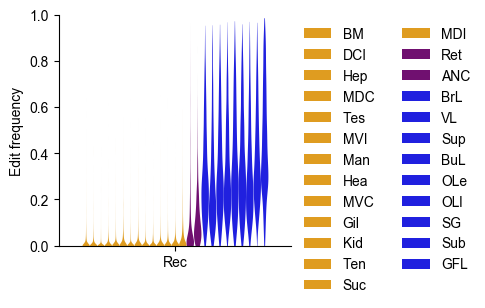

./Tables_DATA/Fig_6f.tab
./Tables_DATA/Fig_6f_stats_Rec.tab
./Tables_DATA/Fig_6f_stats_Syn.tab


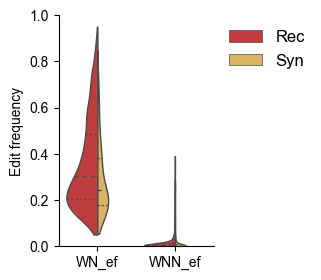

./Tables_DATA/Fig_6g.tab
./Tables_DATA/Fig_6g_stats_Rec.tab


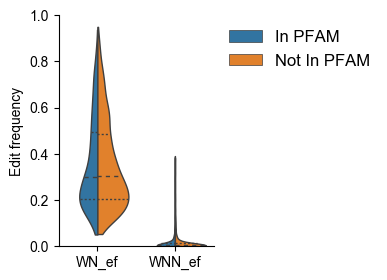

./Tables_DATA/Fig_6h.tab
./Tables_DATA/Fig_6h_stats_Rec.tab


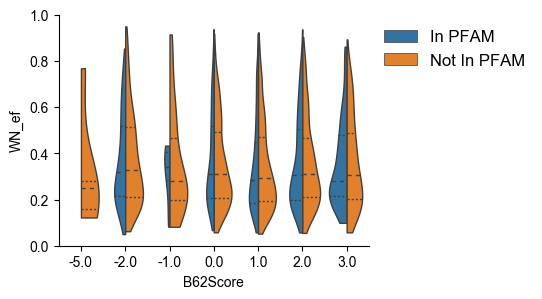

./Tables_DATA/Fig_6i.tab
./Tables_DATA/Fig_6i_stats_Rec.tab


In [44]:
Tp_2_2 = pd.merge(ADAR_Albertin[(ADAR_Albertin.ID.isin(EF_Albertin[EF_Albertin.T.max()>.25].index.to_list()))&(ADAR_Albertin.Edit_type=='Neural') &((ADAR_Albertin.Effect=='Rec') | (ADAR_Albertin.Effect=='Syn'))][['ID','Effect','B62Score','Edit_type','WN_ef','WNN_ef','PFAM']], EF_Albertin.loc[To_select_ubiq_expr], left_on='ID', right_index=True)


### Fig_4f_nerual_sites_at_least_25max
#Edit freqeuncy of Neural sites in coding regions with a minimal edit frequeny of 25% in at least one sample.
To_plot_sns = pd.melt(Tp_2_2, value_vars=NotNeu_samples+Neural_samples, id_vars=['Effect'])


plt.figure(figsize=(3,3))
sns.violinplot(x='Effect' , y = 'value' , hue='variable', data =To_plot_sns[To_plot_sns.Effect=='Rec'], linewidth=0,scale='count',cut=0,scale_hue=True, palette=color_samples)
plt.legend(bbox_to_anchor=(1,1), ncol=2,frameon=False, fontsize=10)
#fig_name= ''.join(('/global/cscratch1/sd/sofiamr/SQUID_2/OutFigs/','Nov062020_Violin_RecSyn_bySample','.pdf'))
#fig_name= ''.join(('/global/cscratch1/sd/sofiamr/SQUID_2/OutFigs/','Nov062020_Violin_RecSyn_bySample','.pdf'))
plt.ylim(0,1)
plt.ylabel('Edit frequency')
plt.xlabel('')
plt.savefig('Fig_6f_Neural_sites_coding_above_p25.pdf', bbox_inches='tight')
#print fig_name
plt.show()

out_table(To_plot_sns,'Fig_6f.tab')
out_table(To_plot_sns.groupby(['Effect','variable']).value.describe().loc['Rec'],'Fig_6f_stats_Rec.tab')
out_table(To_plot_sns.groupby(['Effect','variable']).value.describe().loc['Syn'],'Fig_6f_stats_Syn.tab')


To_plot_sns = pd.melt(Tp_2_2, value_vars=['WN_ef','WNN_ef'], id_vars=['Effect'])
plt.figure(figsize=(2,3))
sns.violinplot(hue='Effect' , y = 'value' , x='variable', data =To_plot_sns, linewidth=1,scale='count',cut=0,inner="quartile",scale_hue=True, split=True, palette=color_Kind_cb)
plt.legend(bbox_to_anchor=(1,1), ncol=1,frameon=False)
#fig_name= ''.join(('/global/cscratch1/sd/sofiamr/SQUID_2/OutFigs/','Nov062020_Violin_RecSyn_bySample','.pdf'))
#plt.savefig(fig_name)
#print fig_name
plt.legend(bbox_to_anchor=(1,1), ncol=1,frameon=False, loc=2)
plt.ylim(0,1)
plt.savefig('Fig_6g_Neural_sites_coding_above_p25_Rec_Vs_Syn.pdf', bbox_inches='tight')
plt.ylabel('Edit frequency')
plt.xlabel('')
plt.show()

out_table(To_plot_sns,'Fig_6g.tab')
out_table(To_plot_sns.groupby('Effect').value.describe(),'Fig_6g_stats_Rec.tab')


### Fig_4g_nerual_sites_at_least_25max

To_plot_sns = pd.melt(Tp_2_2[Tp_2_2.Effect=='Rec'], value_vars=['WN_ef','WNN_ef'], id_vars=['PFAM'])
To_plot_sns['PFAM'] = To_plot_sns.PFAM.apply(lambda x: 'In PFAM' if x==True else 'Not In PFAM')

plt.figure(figsize=(2,3))
sns.violinplot(hue='PFAM' , y = 'value' , x='variable', data =To_plot_sns, linewidth=1,scale='count',cut=0,inner="quartile",scale_hue=True, split=True)#, palette=color_Kind_cb)
plt.legend(bbox_to_anchor=(1,1), ncol=1,frameon=False)
#fig_name= ''.join(('/global/cscratch1/sd/sofiamr/SQUID_2/OutFigs/','Nov062020_Violin_RecSyn_bySample','.pdf'))
#plt.savefig(fig_name)
#print fig_name
plt.legend(bbox_to_anchor=(1,1), ncol=1,frameon=False, loc=2)
plt.ylim(0,1)
plt.xlabel('')
plt.ylabel('Edit frequency')
plt.savefig('Fig_6h_Neural_sites_coding_above_p25_PFAM.pdf', bbox_inches='tight')
plt.show()


out_table(To_plot_sns,'Fig_6h.tab')
out_table(To_plot_sns.groupby(['PFAM','variable']).value.describe(),'Fig_6h_stats_Rec.tab')
### Fig_4h_nerual_sites_at_least_25max



To_plot_sns = pd.melt(Tp_2_2[Tp_2_2.Effect=='Rec'], value_vars=['WN_ef'], id_vars=['B62Score','PFAM'])
To_plot_sns['PFAM'] = To_plot_sns.PFAM.apply(lambda x: 'In PFAM' if x==True else 'Not In PFAM')


plt.figure(figsize=(4,3))
sns.violinplot(x='B62Score' , y = 'value' ,hue='PFAM', data =To_plot_sns, linewidth=1,scale='count',cut=0,inner="quartile",scale_hue=True,split=True)#, palette=color_Kind_cb)
plt.legend(bbox_to_anchor=(1,1), ncol=1,frameon=False, loc=2)

plt.ylim(0,1)
plt.ylabel('WN_ef')
plt.legend(bbox_to_anchor=(1,1), ncol=1,frameon=False, loc=2)
plt.savefig('Fig_6i_Neural_sites_coding_above_p25_PFAM_by_Score_Recoding.pdf', bbox_inches='tight')
plt.show()

out_table(To_plot_sns,'Fig_6i.tab')
out_table(To_plot_sns.groupby(['PFAM','B62Score']).value.describe(),'Fig_6i_stats_Rec.tab')

### Fig_4i_nerual_sites_at_least_25max ___SELECTD. Substantial rna editing >25%

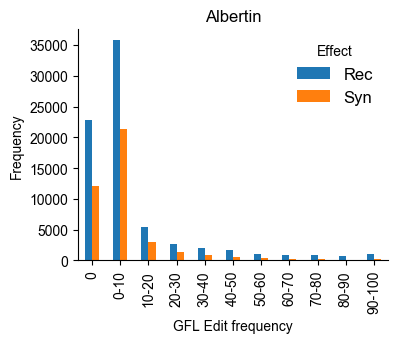

./Tables_DATA/Fig_S9a.tab


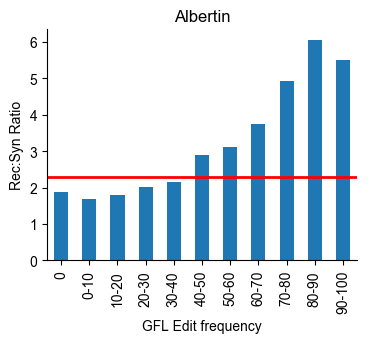

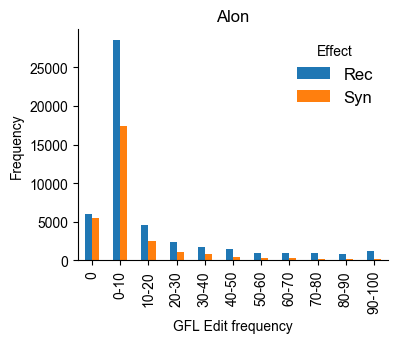

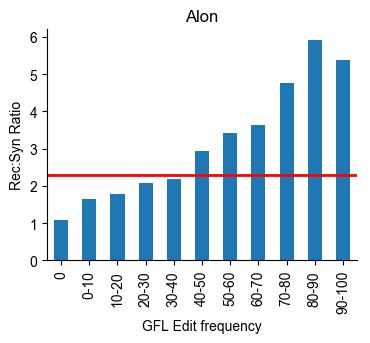

In [45]:
ranges = dict()
for i in range(10,110,10):
    range_ = '-'.join((str(np.around(i-10,0)),str(int(i))))
    ranges[i/10] = range_
ranges[0] = 0
#print (ranges)

    
To_dot_plot = pd.merge(ADAR_Albertin[(ADAR_Albertin.Effect=='Rec') | (ADAR_Albertin.Effect=='Syn')][['ID','Effect','Prot','B62Score']], EF_Albertin[EF_Albertin.GFL>=0]['GFL'], left_on='ID', right_index=True)
To_dot_plot['round'] = To_dot_plot.GFL.apply(lambda x: int(np.ceil(x*10)))
Rec_syn_Albertin = To_dot_plot.groupby('round').Effect.value_counts().unstack()
Rec_syn_Albertin = Rec_syn_Albertin.rename(index=ranges)
Rec_syn_Albertin.plot(kind='bar', figsize=(4,3))
plt.title('Albertin')
plt.ylabel('Frequency')
plt.xlabel('GFL Edit frequency')
plt.savefig('Fig_S9a_Rec_syn_Albertin.png', bbox_inches='tight', dpi=900)
plt.savefig('Fig_S9a_Rec_syn_Albertin.pdf', bbox_inches='tight')#, dpi=900)
plt.show()


out_table(Rec_syn_Albertin,'Fig_S9a.tab')


(Rec_syn_Albertin.Rec/Rec_syn_Albertin.Syn).plot(kind='bar', figsize=(4,3))
plt.title('Albertin')
plt.ylabel('Rec:Syn Ratio')
plt.xlabel('GFL Edit frequency')
plt.axhline(2.3, color='red')
plt.savefig('Fig_S9a_Rec_syn_ratio_Albertin.png', bbox_inches='tight', dpi=900)
plt.savefig('Fig_S9a_Rec_syn_ratio_Albertin.pdf', bbox_inches='tight')#, dpi=900)


plt.show()
### Fig_S7C


To_dot_plot = pd.merge(ADAR_Alon[(ADAR_Alon.Effect=='Rec') | (ADAR_Alon.Effect=='Syn')][['ID','Effect','Prot','B62Score']], EF_Alon[EF_Alon.GFLr>=0]['GFLr'], left_on='ID', right_index=True)
To_dot_plot['round'] = To_dot_plot.GFLr.apply(lambda x: int(np.ceil(x*10)))
Rec_syn_Alon = To_dot_plot.groupby('round').Effect.value_counts().unstack()
Rec_syn_Alon = Rec_syn_Alon.rename(index=ranges)
Rec_syn_Alon.plot(kind='bar', figsize=(4,3))
plt.title('Alon')
plt.ylabel('Frequency')
plt.xlabel('GFL Edit frequency')
#plt.savefig('Fig_S6_Rec_syn_Alon.png', bbox_inches='tight', dpi=900)
#plt.savefig('Fig_S6_Rec_syn_Alon.pdf', bbox_inches='tight')#, dpi=900)

#out_table(Rec_syn_Alon,'Fig_9b.tab')


plt.show()

(Rec_syn_Alon.Rec/Rec_syn_Alon.Syn).plot(kind='bar', figsize=(4,3))
plt.title('Alon')
plt.ylabel('Rec:Syn Ratio')
plt.xlabel('GFL Edit frequency')
plt.axhline(2.3, color='red')
#plt.savefig('Fig_S6_Rec_syn_ratio_Alon.png', bbox_inches='tight', dpi=900)
#plt.savefig('Fig_S6_Rec_syn_ratio_Alon.pdf', bbox_inches='tight')#, dpi=900)


plt.show()

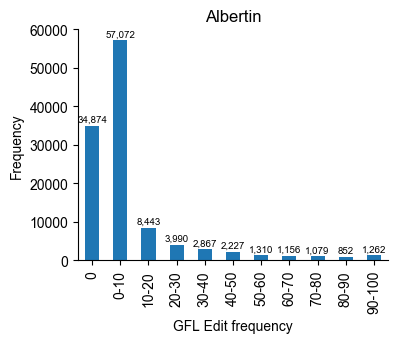

In [46]:
counter=0
To_dot_plot = pd.merge(ADAR_Albertin[(ADAR_Albertin.Effect=='Rec') | (ADAR_Albertin.Effect=='Syn')][['ID','Effect','Prot','B62Score']], EF_Albertin[EF_Albertin.GFL>=0]['GFL'], left_on='ID', right_index=True)
To_dot_plot['round'] = To_dot_plot.GFL.apply(lambda x: int(np.ceil(x*10)))
Counts_Albertin = To_dot_plot['round'].value_counts().sort_index()#.unstack()
Counts_Albertin = Counts_Albertin.rename(index=ranges)
Counts_Albertin.plot(kind='bar', figsize=(4,3))
plt.title('Albertin')
plt.ylabel('Frequency')
plt.xlabel('GFL Edit frequency')
for i in Counts_Albertin.index.to_list():
    #plt.text(counter,Counts_Albertin.loc[i]+1000,'{:n}'.format(Counts_Albertin.loc[i]), ha='center', fontsize=9)
    plt.text(counter,Counts_Albertin.loc[i]+1000,'{:,}'.format(Counts_Albertin.loc[i]), ha='center', fontsize=7)
    counter=counter+1
#plt.savefig('Fig_S6_Counts_Albertin.png', bbox_inches='tight', dpi=900)
#plt.savefig('Fig_S6_Counts_Albertin.pdf', bbox_inches='tight')#, dpi=900)
plt.show()

### Are recoding sites more likely to fall in PFAM domains?


./Tables_DATA/Fig_S9b.tab


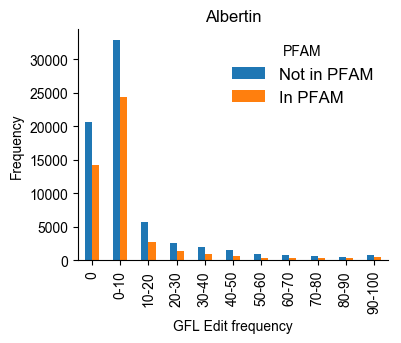

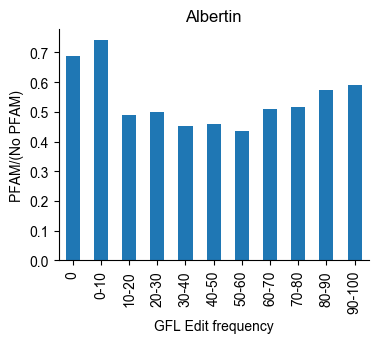

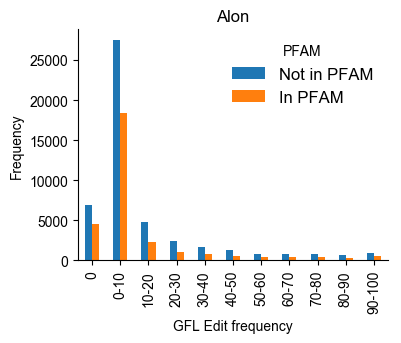

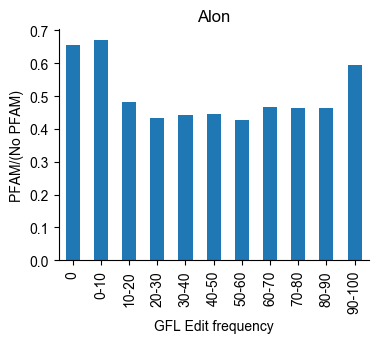

In [47]:
To_dot_plot = pd.merge(ADAR_Albertin[(ADAR_Albertin.Effect=='Rec') | (ADAR_Albertin.Effect=='Syn')][['ID','Effect','Prot','B62Score','PFAM']], EF_Albertin[EF_Albertin.GFL>=0]['GFL'], left_on='ID', right_index=True)
To_dot_plot['round'] = To_dot_plot.GFL.apply(lambda x: int(np.ceil(x*10)))
PFAM_TF_Albertin = To_dot_plot.groupby('round').PFAM.value_counts().unstack()
PFAM_TF_Albertin = PFAM_TF_Albertin.rename(columns={True:'In PFAM',False:'Not in PFAM'})#
PFAM_TF_Albertin = PFAM_TF_Albertin.rename(index=ranges)
PFAM_TF_Albertin.plot(kind='bar', figsize=(4,3))
plt.title('Albertin')
plt.ylabel('Frequency')
plt.xlabel('GFL Edit frequency')
plt.savefig('Fig_S9b_PFAM_Albertin.png', bbox_inches='tight', dpi=900)
plt.savefig('Fig_S9b_PFAM_Albertin.pdf', bbox_inches='tight')#, dpi=900)

out_table(PFAM_TF_Albertin,'Fig_S9b.tab')


plt.show()

(PFAM_TF_Albertin['In PFAM']/PFAM_TF_Albertin['Not in PFAM']).plot(kind='bar', figsize=(4,3))
plt.title('Albertin')
plt.ylabel('PFAM/(No PFAM)')
plt.xlabel('GFL Edit frequency')
plt.savefig('Fig_S9b_PFAM_ratio_Albertin.png', bbox_inches='tight', dpi=900)
plt.savefig('Fig_S9b_PFAM_ratio_Albertin.pdf', bbox_inches='tight')#, dpi=900)

plt.show()


To_dot_plot = pd.merge(ADAR_Alon[(ADAR_Alon.Effect=='Rec') | (ADAR_Alon.Effect=='Syn')][['ID','Effect','Prot','B62Score','PFAM']], EF_Alon[EF_Alon.GFLr>=0]['GFLr'], left_on='ID', right_index=True)
To_dot_plot['round'] = To_dot_plot.GFLr.apply(lambda x: int(np.ceil(x*10)))
PFAM_TF_Alon = To_dot_plot.groupby('round').PFAM.value_counts().unstack()
PFAM_TF_Alon = PFAM_TF_Alon.rename(columns={True:'In PFAM',False:'Not in PFAM'})#
PFAM_TF_Alon = PFAM_TF_Alon.rename(index=ranges)
PFAM_TF_Alon.plot(kind='bar', figsize=(4,3))
plt.title('Alon')
plt.ylabel('Frequency')
plt.xlabel('GFL Edit frequency')
#plt.savefig('Fig_S6_PFAM_Alon.png', bbox_inches='tight', dpi=900)
#plt.savefig('Fig_S6_PFAM_Alon.pdf', bbox_inches='tight')#, dpi=900)


plt.show()

(PFAM_TF_Alon['In PFAM']/PFAM_TF_Alon['Not in PFAM']).plot(kind='bar', figsize=(4,3))
plt.title('Alon')
plt.ylabel('PFAM/(No PFAM)')
plt.xlabel('GFL Edit frequency')
#plt.savefig('Fig_S6_PFAM_ratio_Alon.png', bbox_inches='tight', dpi=900)
#plt.savefig('Fig_S6_PFAM_ratio_Alon.pdf', bbox_inches='tight')#, dpi=900)


plt.show()



### Are recoding sites more likely to fall in transmembrane regions?

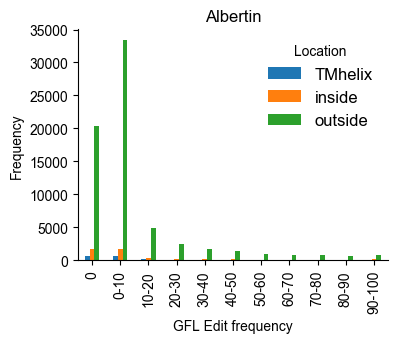

./Tables_DATA/Fig_S9c.tab


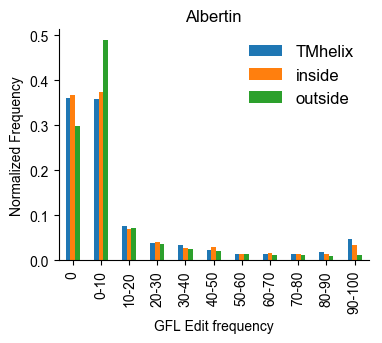

In [48]:
#| (ADAR_Albertin.Effect=='Syn')
To_dot_plot = pd.merge(ADAR_Albertin[(ADAR_Albertin.Effect=='Rec') ][['ID','Location','Effect','Prot','B62Score','PFAM']], EF_Albertin[EF_Albertin.GFL>=0]['GFL'], left_on='ID', right_index=True)
To_dot_plot['round'] = To_dot_plot.GFL.apply(lambda x: int(np.ceil(x*10)))
TM_Albertin = To_dot_plot.groupby('round').Location.value_counts().unstack()
TM_Albertin = TM_Albertin.rename(index=ranges)
TM_Albertin.plot(kind='bar', figsize=(4,3))
plt.title('Albertin')
plt.ylabel('Frequency')
plt.xlabel('GFL Edit frequency')
plt.savefig('Fig_S9c_TMEM_Albertin.png', bbox_inches='tight', dpi=900)
plt.savefig('Fig_S9c_TMEM_Albertin.pdf', bbox_inches='tight')#, dpi=900)
plt.show()
out_table(TM_Albertin,'Fig_S9c.tab')


(TM_Albertin/To_dot_plot.Location.value_counts()).plot(kind='bar', figsize=(4,3))
plt.title('Albertin')
plt.ylabel('Normalized Frequency')
plt.xlabel('GFL Edit frequency')
plt.savefig('Fig_S9c_TMEM_normed_Albertin.png', bbox_inches='tight', dpi=900)
plt.savefig('Fig_S9c_TMEM_normed_Albertin.pdf', bbox_inches='tight')#, dpi=900)

plt.show()



### Is there an association between the edit frequency and the amino acid substitution score?

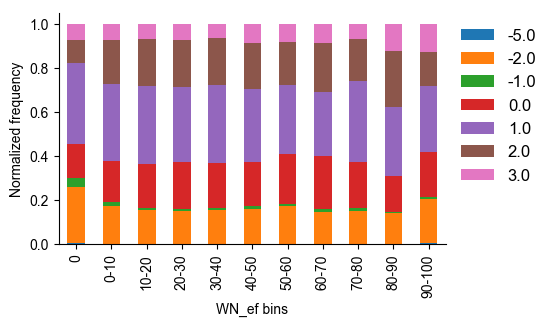

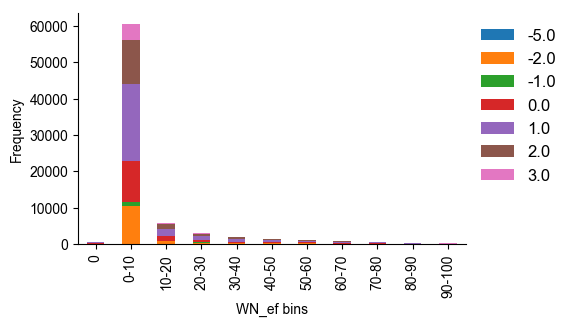

./Tables_DATA/Fig_S9d_byBlosum62Score.tab


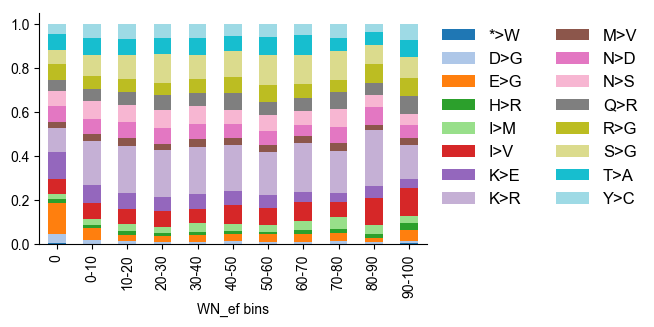

./Tables_DATA/Fig_S9d_byAminoAcid.tab


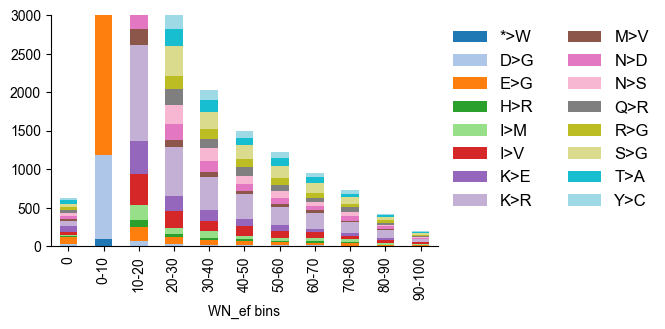

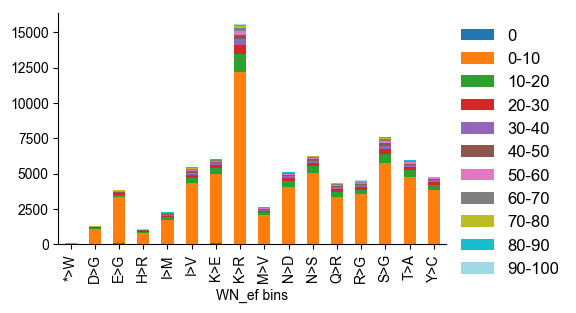

In [66]:
#Is there a correlation between level of RNA editing and type of aminoacid change?
#To_dot_plot = pd.merge(ADAR_Albertin[ADAR_Albertin.Effect=='Rec'][['ID','Prot','B62Score']], EF_Albertin[EF_Albertin.GFL>=0]['GFL'], left_on='ID', right_index=True)

To_dot_plot = ADAR_Albertin[(ADAR_Albertin.Effect=='Rec')& (ADAR_Albertin.WN_ef>=0)][['ID','Prot','B62Score','WN_ef']]#, EF_Albertin[EF_Albertin.GFL>=0]['GFL'], left_on='ID', right_index=True)

To_dot_plot['round'] = To_dot_plot.WN_ef.apply(lambda x: int(np.ceil(x*10)))
To_dot_plot['round'] = To_dot_plot['round'].apply(lambda x: ranges[x])

#####
#####

To_dot_plot2 =To_dot_plot.groupby('round').B62Score.value_counts().unstack().fillna(0)
(To_dot_plot2.T/To_dot_plot2.T.sum()).T.plot(kind='bar', stacked=True, figsize=(5,3));

plt.ylabel('Normalized frequency')
plt.xlabel('WN_ef bins')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.savefig('Fig_S9d_Score_Norm.pdf', bbox_inches='tight')
plt.show()

#####
#####


To_dot_plot2 =To_dot_plot.groupby('round').B62Score.value_counts().unstack().fillna(0)
(To_dot_plot2).plot(kind='bar', stacked=True, figsize=(5,3));

plt.ylabel('Frequency')
plt.xlabel('WN_ef bins')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.savefig('Fig_S9d_Score_Abs.pdf', bbox_inches='tight')
plt.show()
out_table(To_dot_plot2,'Fig_S9d_byBlosum62Score.tab')

#####
#####


To_dot_plot2 =To_dot_plot.groupby('round').Prot.value_counts().unstack().fillna(0)
(To_dot_plot2.T/To_dot_plot2.T.sum()).T.plot(kind='bar', stacked=True, figsize=(5,3), cmap='tab20');
plt.xlabel('WN_ef bins')
plt.legend(bbox_to_anchor=(1,1), ncol=2, loc=2)
plt.savefig('Fig_S9d_AminAcid_Norm.pdf', bbox_inches='tight')
plt.show()
out_table(To_dot_plot2,'Fig_S9d_byAminoAcid.tab')

#####
#####


To_dot_plot2 =To_dot_plot.groupby('round').Prot.value_counts().unstack().fillna(0)
(To_dot_plot2).plot(kind='bar', stacked=True, figsize=(5,3), cmap='tab20');
plt.ylim(0,3000);
plt.xlabel('WN_ef bins')
plt.legend(bbox_to_anchor=(1,1), ncol=2, loc=2)
plt.show()

#####
#####


To_dot_plot2 =To_dot_plot.groupby('round').Prot.value_counts().unstack().fillna(0)
(To_dot_plot2.T).plot(kind='bar', stacked=True, figsize=(5,3), cmap='tab20');

plt.xlabel('WN_ef bins')
plt.legend(bbox_to_anchor=(1,1))
#plt.savefig('Fig_S9d_AminAcid_Norm_Transposed.pdf', bbox_inches='tight')
plt.show()




### Do low edits co-occur with high edits? or are high edits only present in specific genes?

## RNA editing profile of genes:

Dopeav2061683m: DYNC1H1 - Dyneins, heavy chain


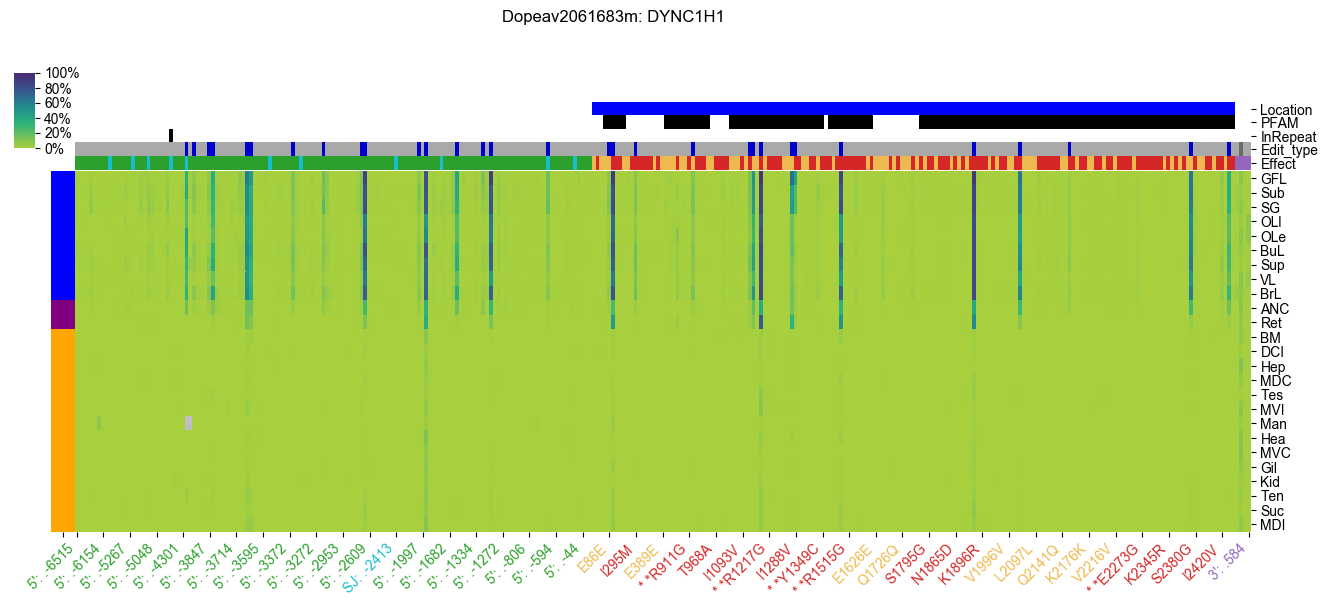

In [49]:
def draw_EF_genes_test(gene_id, ADAR_Albertin, Neural_samples, NotNeu_samples, linkage='', fig_name=''):
    
    KOG_d = ', '.join(Gene_description[Gene_description.transcriptName==gene_id]['KOG description'])
    HUGO_n = ', '.join(Gene_description[Gene_description.transcriptName==gene_id]['HUGO'])
    
    idxs_ = ADAR_Albertin[(ADAR_Albertin.GeneID==gene_id) & ~(ADAR_Albertin.Effect=='Intron')].ID.to_list()
    For_clustermap = EF_Albertin.loc[idxs_][DP_Albertin.loc[idxs_]>=4][Neural_samples+NotNeu_samples].T.fillna(-1)
    
    if ADAR_Albertin[ADAR_Albertin.ID.isin(idxs_)].Ref.unique()[0] =='T':
        For_clustermap = For_clustermap.T[::-1].T
        
    row_colors=For_clustermap.index.to_series().map(color_samples)
    #col_colors=ADAR_Albertin[ADAR_Albertin.ID.isin(For_clustermap.columns.to_list())][['ID','Effect','PFAM','Location','InRepeat']].set_index('ID').Effect.map(color_Kind_cb)
    Edit_info = ADAR_Albertin[ADAR_Albertin.ID.isin(idxs_)][['ID','Effect','PFAM','Location','InRepeat','Edit_type']].set_index('ID')
    
    col_colors = pd.DataFrame([Edit_info['Location'].map({'outside':'blue','inside':'green','TMhelix':'red'}),Edit_info['PFAM'].map({True:'black',False:'white'}), Edit_info['InRepeat'].map({True:'black',False:'white'}),  Edit_info['Edit_type'].map(color_editKind_2), Edit_info['Effect'].map(color_Kind_cb)] ).T
    
    if linkage =='':
        if len(idxs_) <= 75:
            cm = sns.clustermap(For_clustermap, col_cluster=False, row_cluster=False, cmap=col_blind, row_colors=row_colors,figsize=(12,6),yticklabels=1,xticklabels=1,col_colors=col_colors, vmin=-1, vmax=1) 
        else:
            cm = sns.clustermap(For_clustermap, col_cluster=False, row_cluster=False, cmap=col_blind, row_colors=row_colors,figsize=(12,6),yticklabels=1,col_colors=col_colors, vmin=-1, vmax=1) 
        
    else:
        if len(idxs_) <= 70:
            cm = sns.clustermap(For_clustermap, col_cluster=False, row_linkage=linkage, cmap=col_blind, row_colors=row_colors,figsize=(12,6),yticklabels=1,xticklabels=1,vmin=-1, vmax=1, col_colors=col_colors)
        else:
            cm = sns.clustermap(For_clustermap, col_cluster=False, row_linkage=linkage, cmap=col_blind, row_colors=row_colors,figsize=(12,6),yticklabels=1,vmin=-1, vmax=1, col_colors=col_colors)
       
    idxs_ = For_clustermap.T.index.to_list()
    x_ticks_Prot = ADAR_Albertin[ADAR_Albertin.ID.isin(idxs_)].Prot
    x_ticks_Effect = ADAR_Albertin[ADAR_Albertin.ID.isin(idxs_)].Effect
    x_ticks_Penalty = ADAR_Albertin[ADAR_Albertin.ID.isin(idxs_)].B62Score
    
    list_ticknames= []
    
    for tick_label in cm.ax_heatmap.axes.get_xticklabels():
        tick_id = np.array(idxs_)[int(tick_label.get_position()[0])]
        x_ticks_Effect = ADAR_Albertin[ADAR_Albertin.ID==tick_id].Effect.to_list()[0]
        if x_ticks_Effect in ['Rec','Syn']:
            tick_name = ADAR_Albertin[ADAR_Albertin.ID==tick_id].Prot.to_list()[0].replace('M>X','M>V').replace('>',str(int(ADAR_Albertin[ADAR_Albertin.ID==tick_id].Prot_pos.to_list()[0])))
            x_ticks_penalty = ADAR_Albertin[ADAR_Albertin.ID==tick_id].B62Score.to_list()[0]
        else:
            tick_name = ': '.join((ADAR_Albertin[ADAR_Albertin.ID==tick_id].Effect.to_list()[0],str(ADAR_Albertin[ADAR_Albertin.ID==tick_id].GVSc.to_list()[0].replace('A>G','').replace('*','').replace('c',''))))#.to_list()[0].split('/')[0]) ))
        tick_label.set_color(color_Kind_cb[x_ticks_Effect])
    
        if x_ticks_Effect in ['Rec','Syn']:
            if x_ticks_penalty <0:
                list_ticknames.append(''.join((abs(int(x_ticks_penalty))*' *',tick_name)))
            else:
                list_ticknames.append(tick_name)
        else:
            list_ticknames.append(tick_name)
    cm.ax_heatmap.axes.set_xticklabels(list_ticknames, rotation=45, ha='right')
    title=': '.join((gene_id,str(ADAR_Albertin[ADAR_Albertin.ID.isin(idxs_)].HUGO.unique()[0])))
    
    print (' - '.join((title, KOG_d)))
    
    
    row = cm.ax_row_dendrogram.get_position()
    dend_width=0.03
    row_color_width = 0.02
    cm.ax_row_dendrogram.set_position([0, row.y0, dend_width, row.height])
    
    rcol_pos = cm.ax_row_colors.get_position()
    cm.ax_row_colors.set_position([dend_width+0.001,rcol_pos.y0,row_color_width,rcol_pos.height])

    ccol_pos = cm.ax_col_colors.get_position()
    cm.ax_col_colors.set_position([dend_width+row_color_width+0.001,ccol_pos.y0,0.98,ccol_pos.height*3])

    hm = cm.ax_heatmap.get_position()
    cm.ax_heatmap.set_position([dend_width+row_color_width+0.001, hm.y0, 0.98, hm.height])
    cm.cax.set_ylim(0,1)
    cm.cax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
    cm.cax.set_position([0.00, .75, .0175, .125]) #color code  #, orientation='horizontal'
    
    cm.ax_heatmap.set_ylabel('')
    cm.ax_heatmap.set_xlabel('')
    plt.suptitle(title)
    if len(fig_name)>0:
        fig_name_ = ''.join(('Fig_S_EditProf_',title.replace(':','_').replace(' ','')))
        #plt.savefig(fig_name_, bbox_inches='tight')
        plt.savefig(''.join((fig_name_,'.pdf')), bbox_inches='tight')
    plt.show()
    
    
draw_EF_genes_test('Dopeav2061683m', ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')

Dopeav2005419m: ADAR - tRNA-specific adenosine deaminase 1


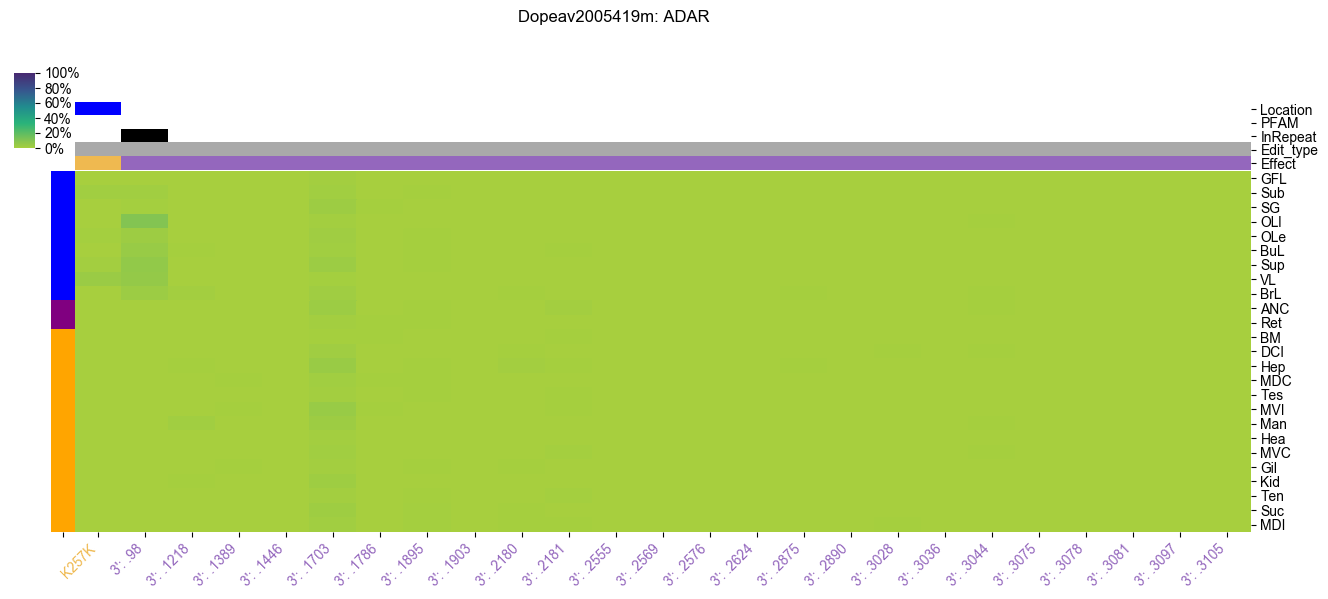

Dopeav2016222m: ADAR - tRNA-specific adenosine deaminase 1


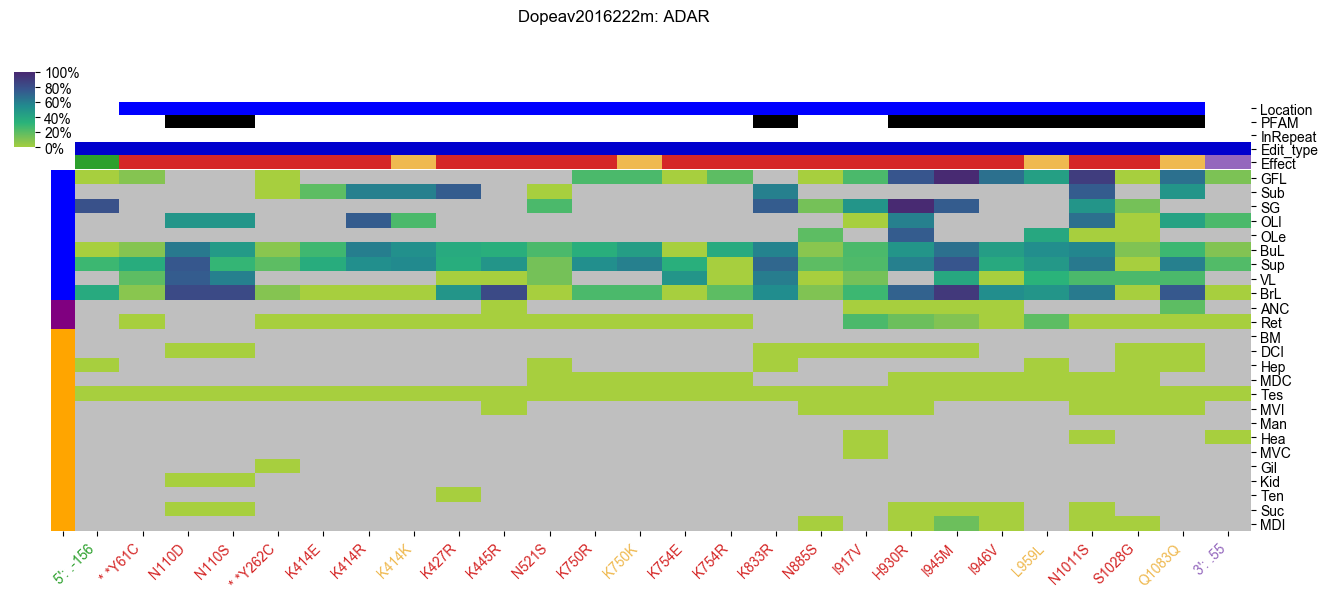

Dopeav2118252m: ADARB1 - tRNA-specific adenosine deaminase 1


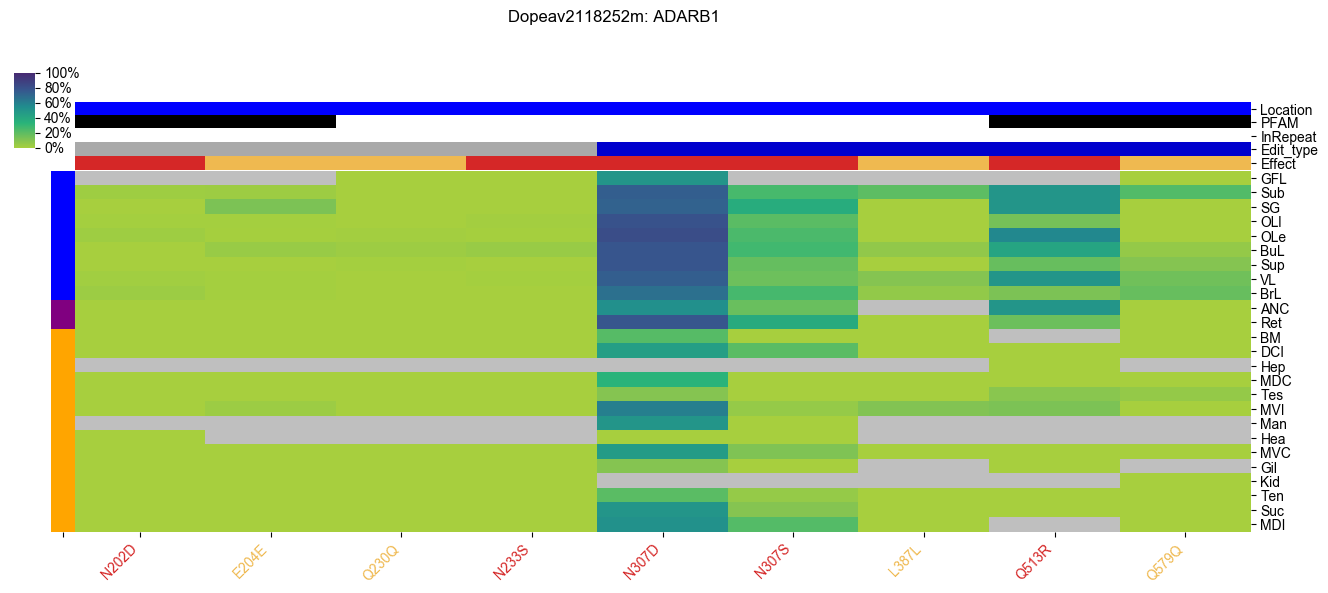

In [50]:
for i in Gene_description[Gene_description.HUGO.str.startswith('ADAR')].transcriptName.to_list():
    if i in ADAR_Albertin.GeneID.unique():
        draw_EF_genes_test(i, ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')

Dopeav2051811m: PCDHA2 - 


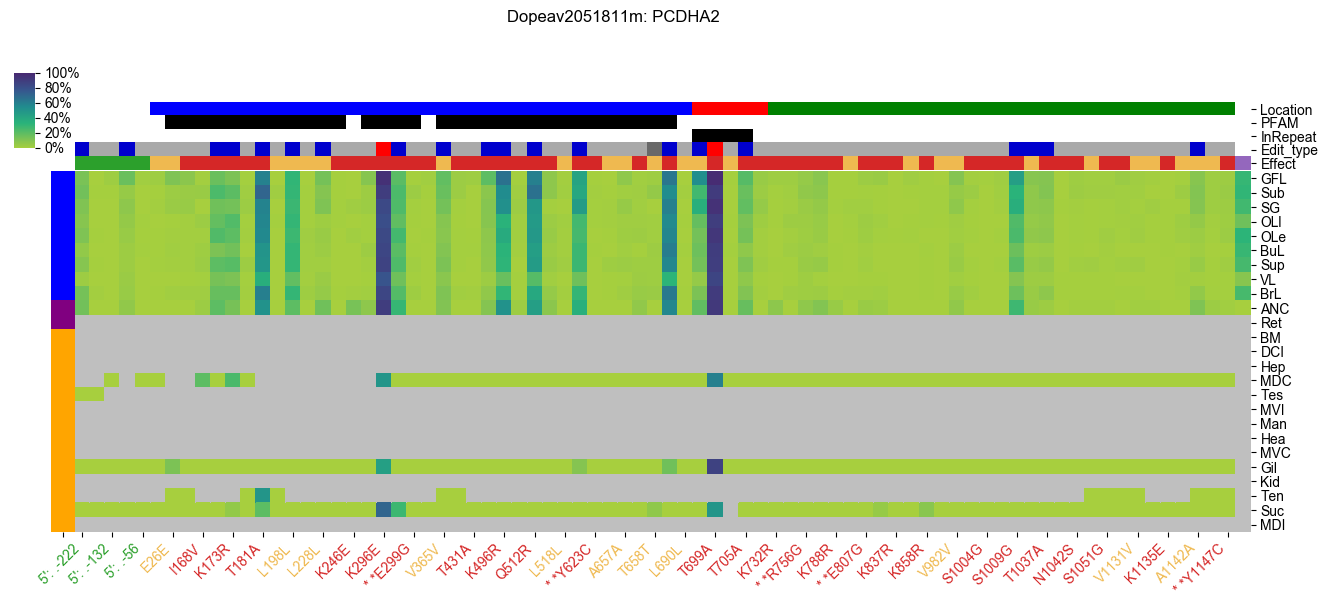

In [69]:
draw_EF_genes_test('Dopeav2051811m',ADAR_Albertin, Neural_samples[::-1], NotNeu_samples)

## Examples of ubiquitously expressed genes with differential RNA editing profiles

Dopeav2047480m: ATP1B1 - 


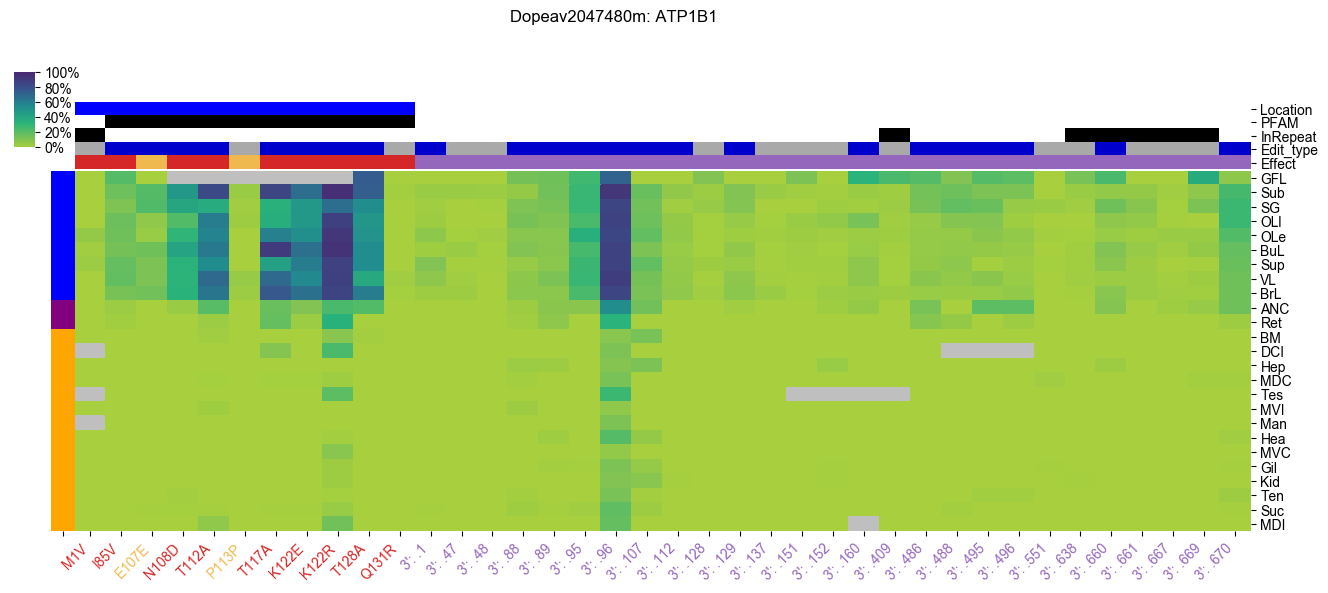

Dopeav2078512m: GRIK2 - Glutamate-gated AMPA-type ion channel receptor subunit GluR2 and related subunits


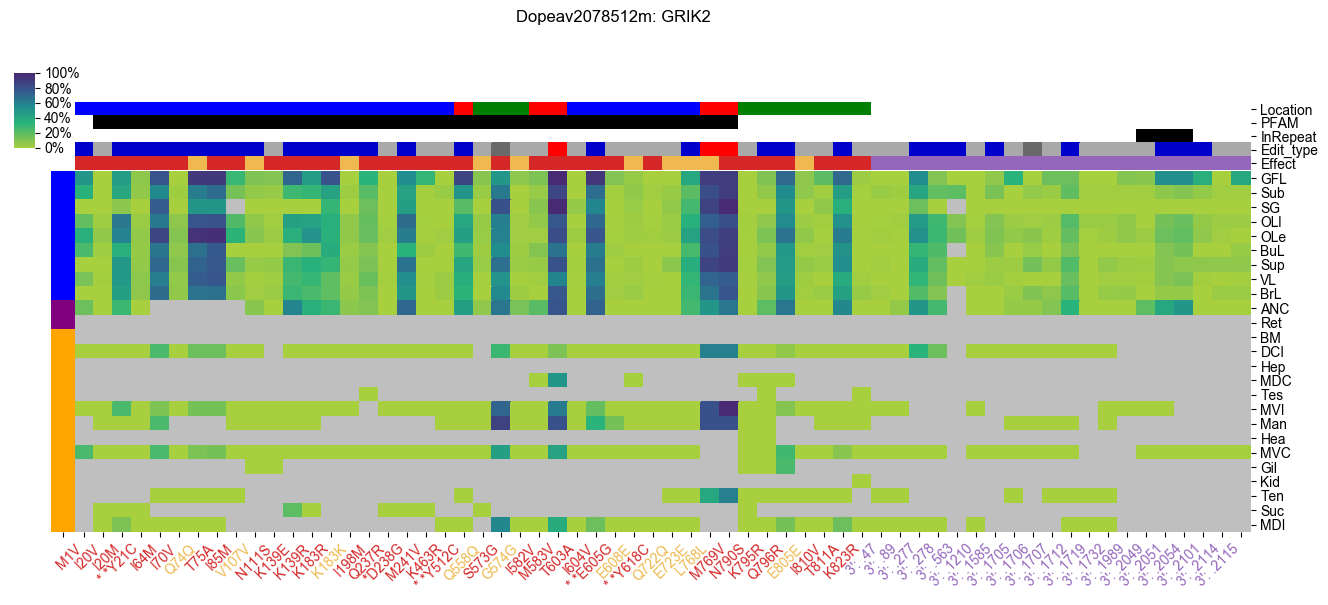

In [71]:
draw_EF_genes_test('Dopeav2047480m', ADAR_Albertin,Neural_samples[::-1], NotNeu_samples)
### Fig_4J_atp1b1
draw_EF_genes_test('Dopeav2078512m', ADAR_Albertin,Neural_samples[::-1], NotNeu_samples)
### Fig_4K_grik2

Dopeav2016222m: ADAR - tRNA-specific adenosine deaminase 1


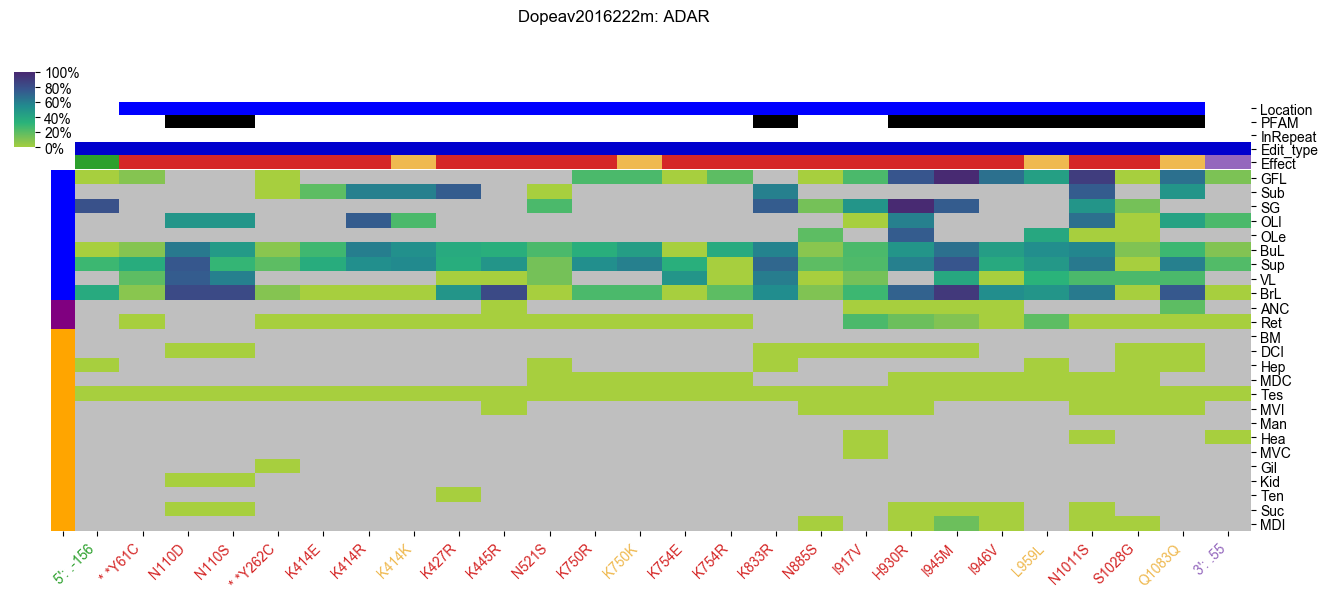

Dopeav2047480m: ATP1B1 - 


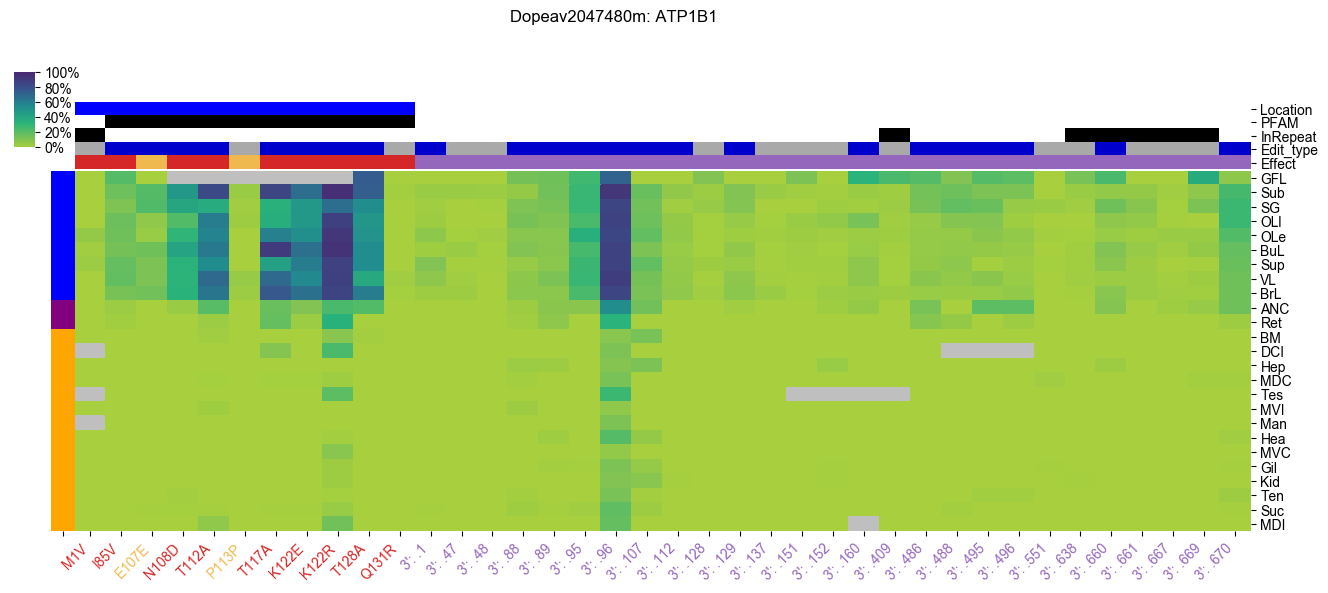

Dopeav2078512m: GRIK2 - Glutamate-gated AMPA-type ion channel receptor subunit GluR2 and related subunits


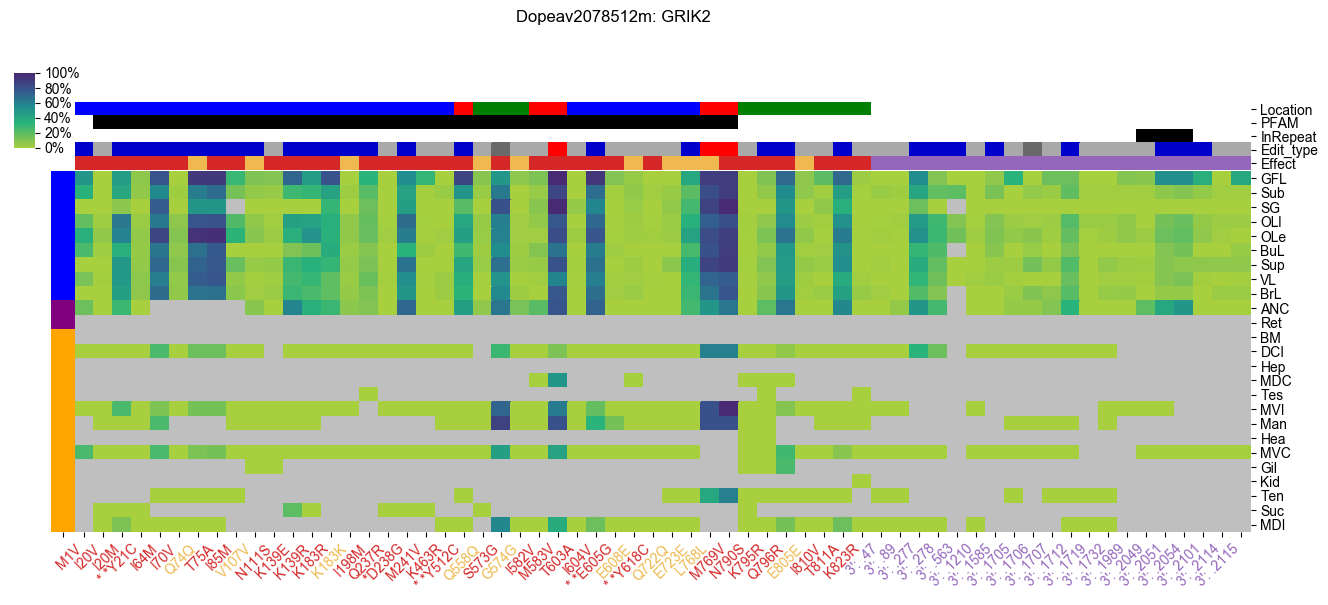

Dopeav2061683m: DYNC1H1 - Dyneins, heavy chain


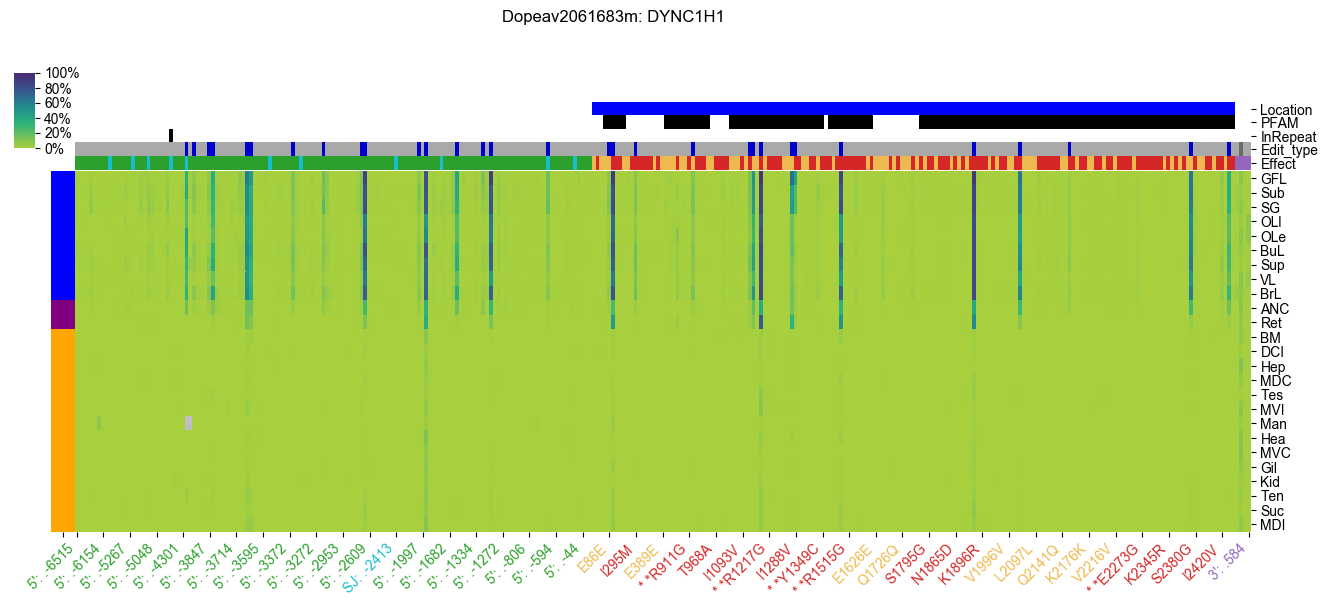

In [72]:
#ADAR_Albertin[ADAR_Albertin.GeneID=='Dopeav2016222m']#.HUGO
draw_EF_genes_test('Dopeav2016222m', ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')

draw_EF_genes_test('Dopeav2047480m', ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')
### Fig_4J_atp1b1
draw_EF_genes_test('Dopeav2078512m', ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')
### Fig_4K_grik2
draw_EF_genes_test('Dopeav2061683m', ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')
### Fig_4K_grik2





Dopeav2044320m: ELAVL4 - RNA-binding protein ELAV/HU (RRM superfamily)


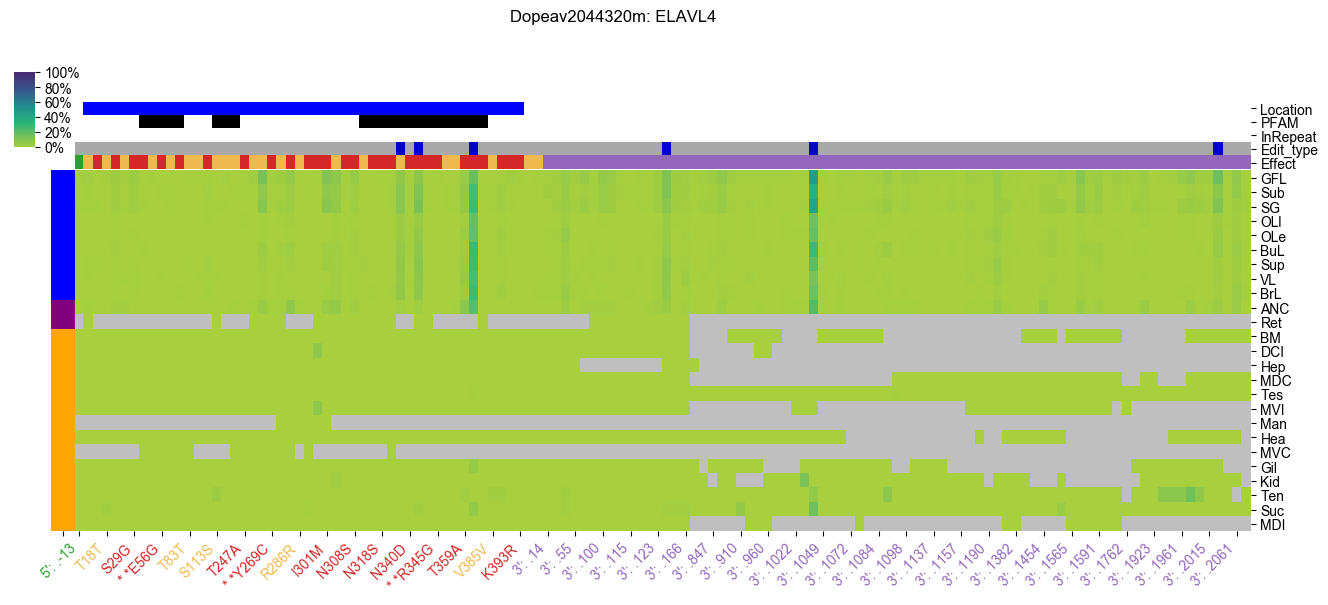

Dopeav2097670m: ELAVL1 - RNA-binding protein ELAV/HU (RRM superfamily)


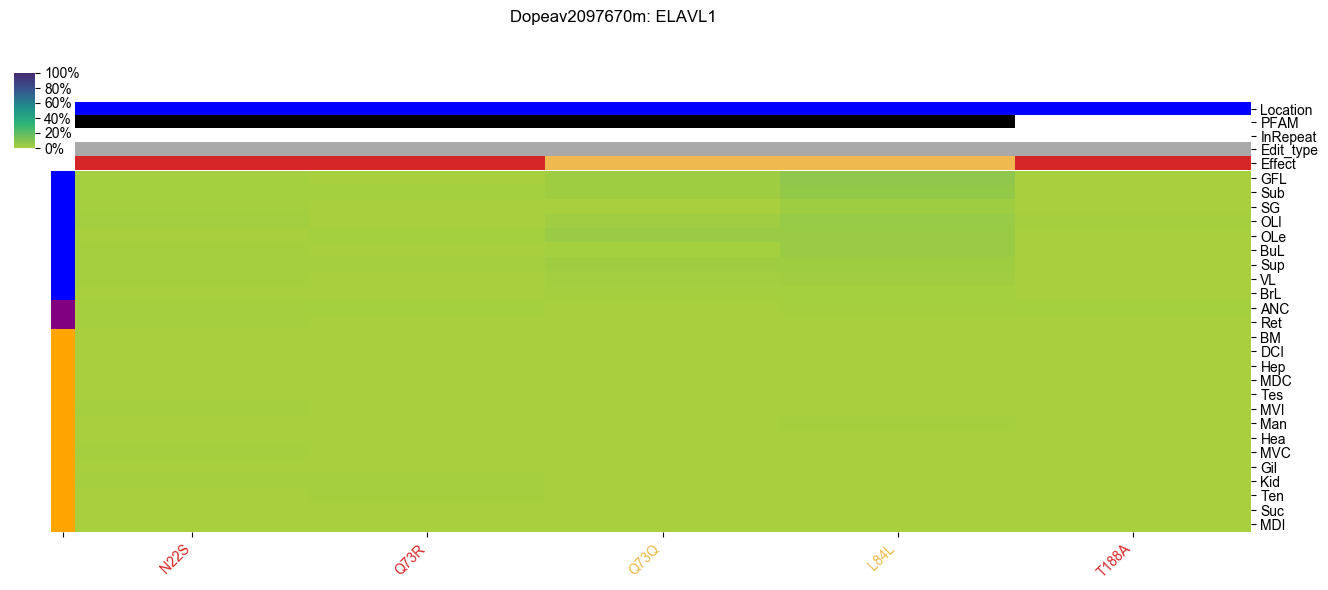

Dopeav2097666m: ELAVL1 - RNA-binding protein ELAV/HU (RRM superfamily)


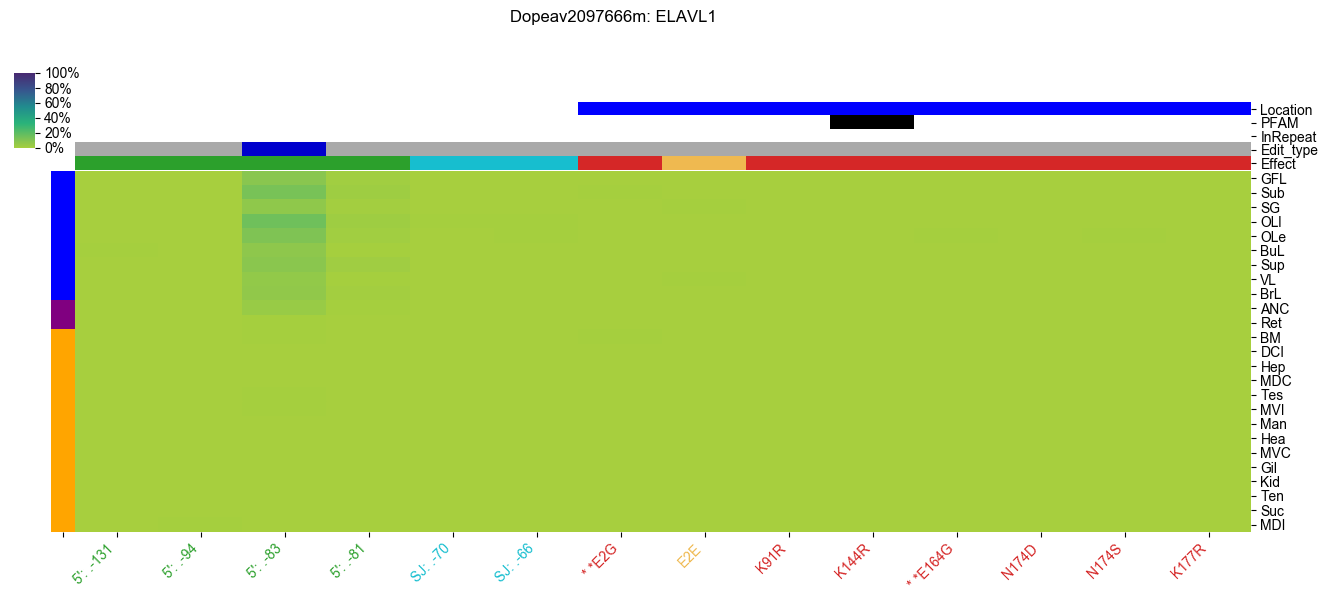

Dopeav2032549m: CELF2 - RNA-binding protein CUGBP1/BRUNO (RRM superfamily)


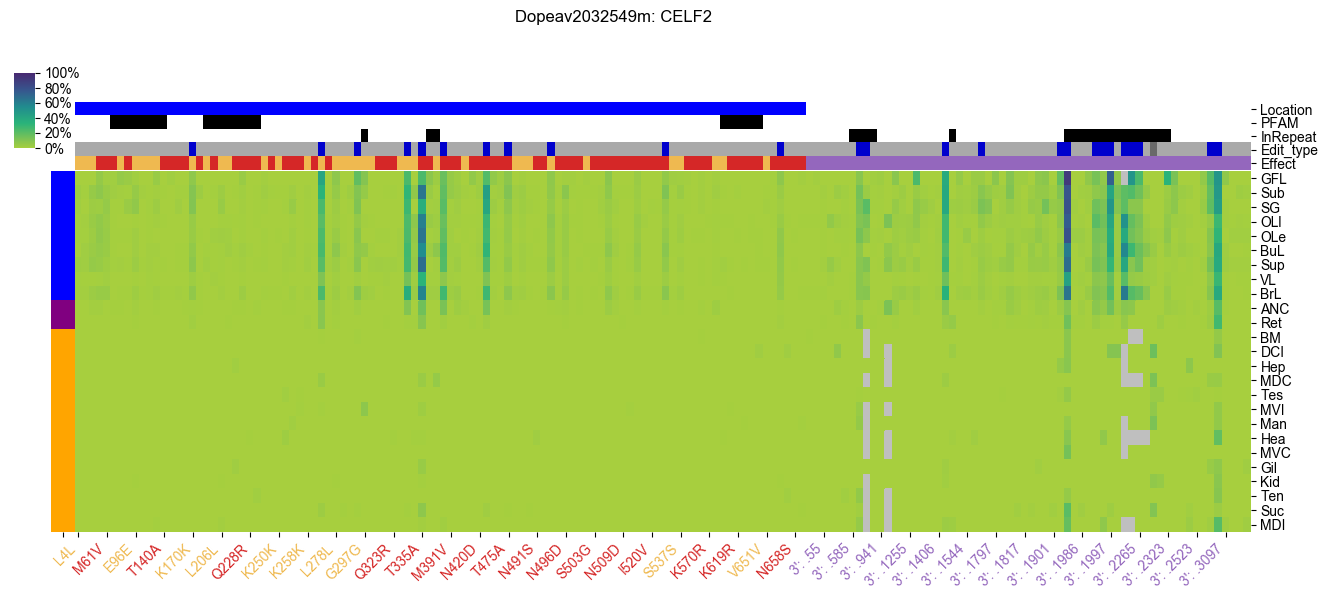

Dopeav2072076m: CELF4 - 


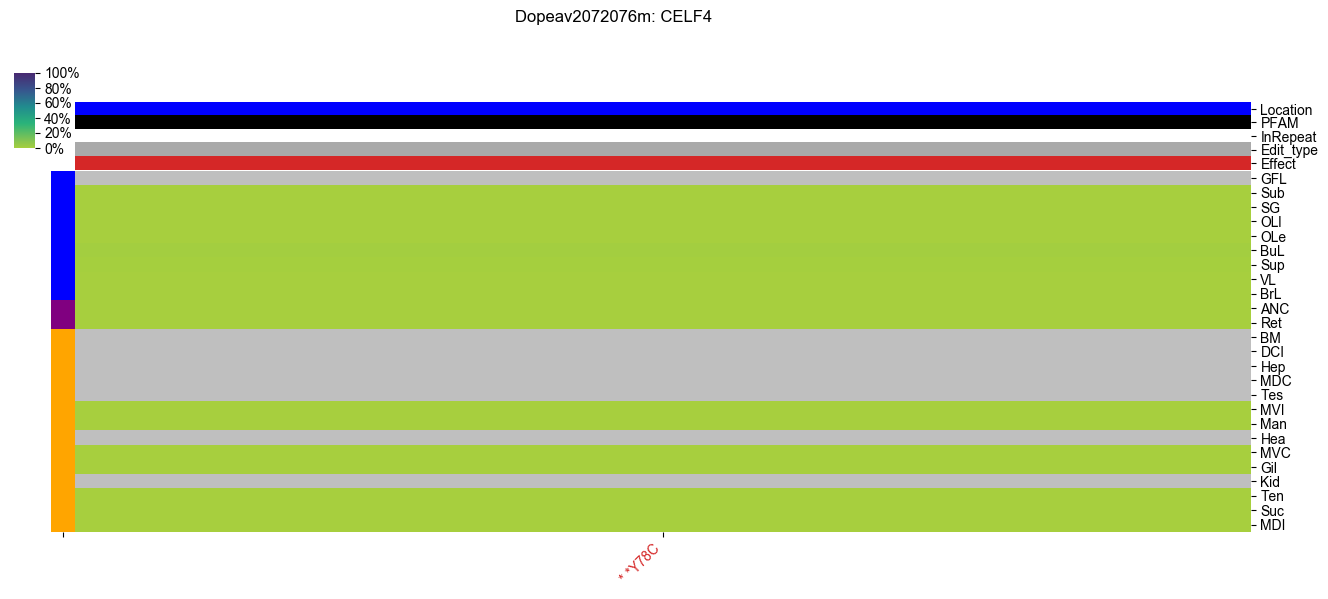

Dopeav2072123m: CELF3 - RNA-binding protein ETR-3 (RRM superfamily)


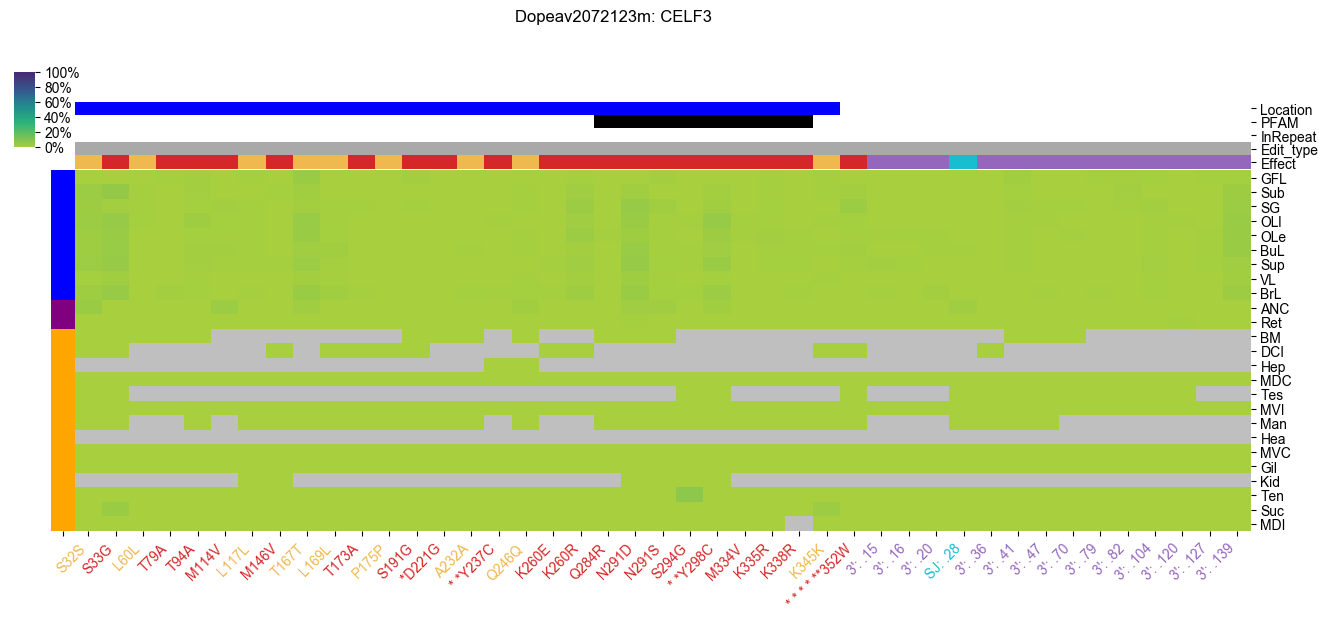

Dopeav2072116m: CELF4 - 


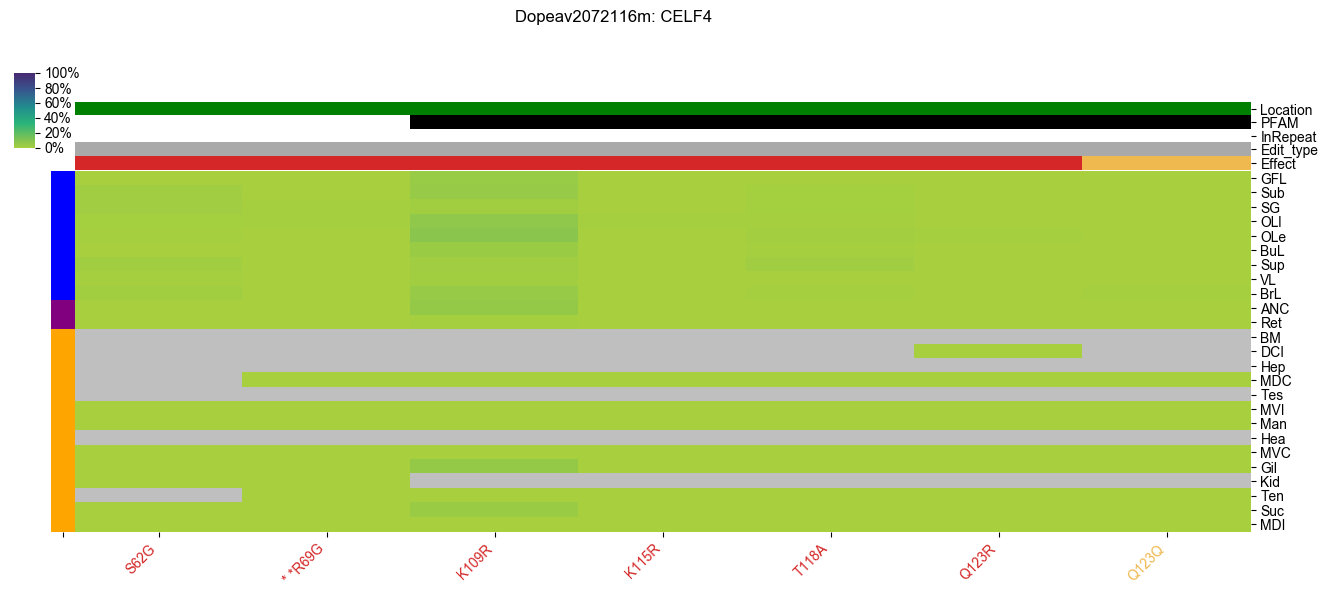

In [73]:
for gene_id in Gene_description[Gene_description.HUGO.str.startswith('ELAV')].transcriptName.to_list():
    if gene_id in ADAR_Albertin.GeneID.to_list():
        draw_EF_genes_test(gene_id, ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')

for gene_id in Gene_description[Gene_description.HUGO.str.startswith('CELF')].transcriptName.to_list():
    if gene_id in ADAR_Albertin.GeneID.to_list():
        draw_EF_genes_test(gene_id, ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')



Dopeav2001438m: EIF3H - Translation initiation factor 3, subunit h (eIF-3h)


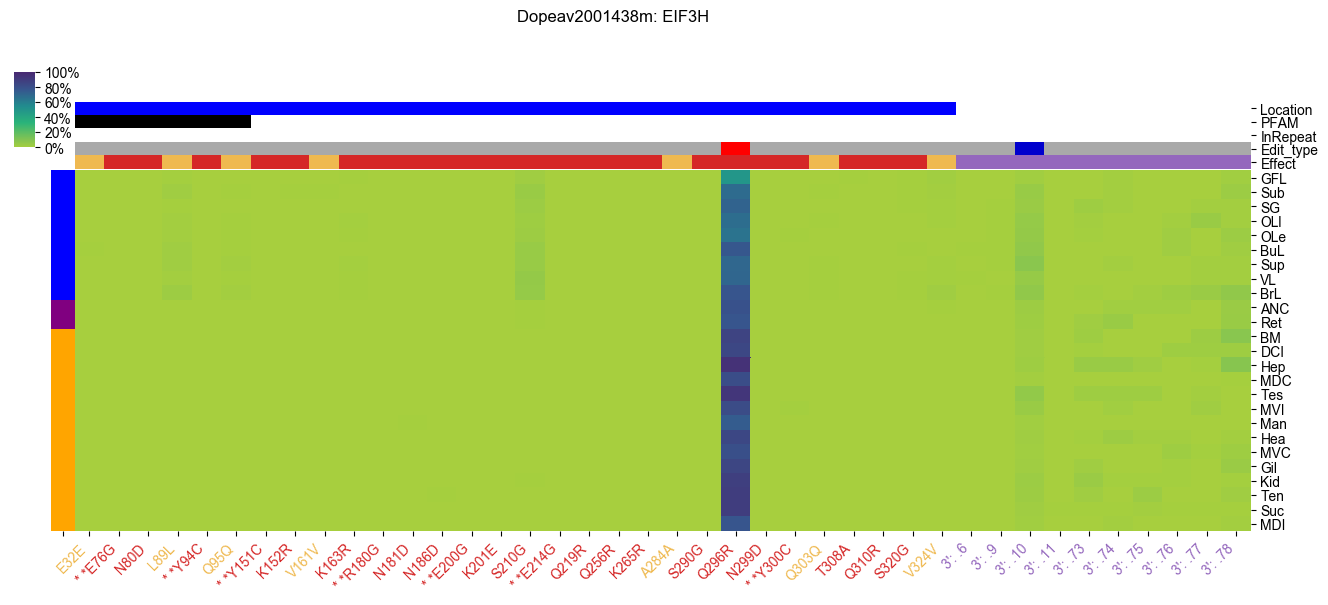

Dopeav2083898m: MYH10 - Myosin class II heavy chain


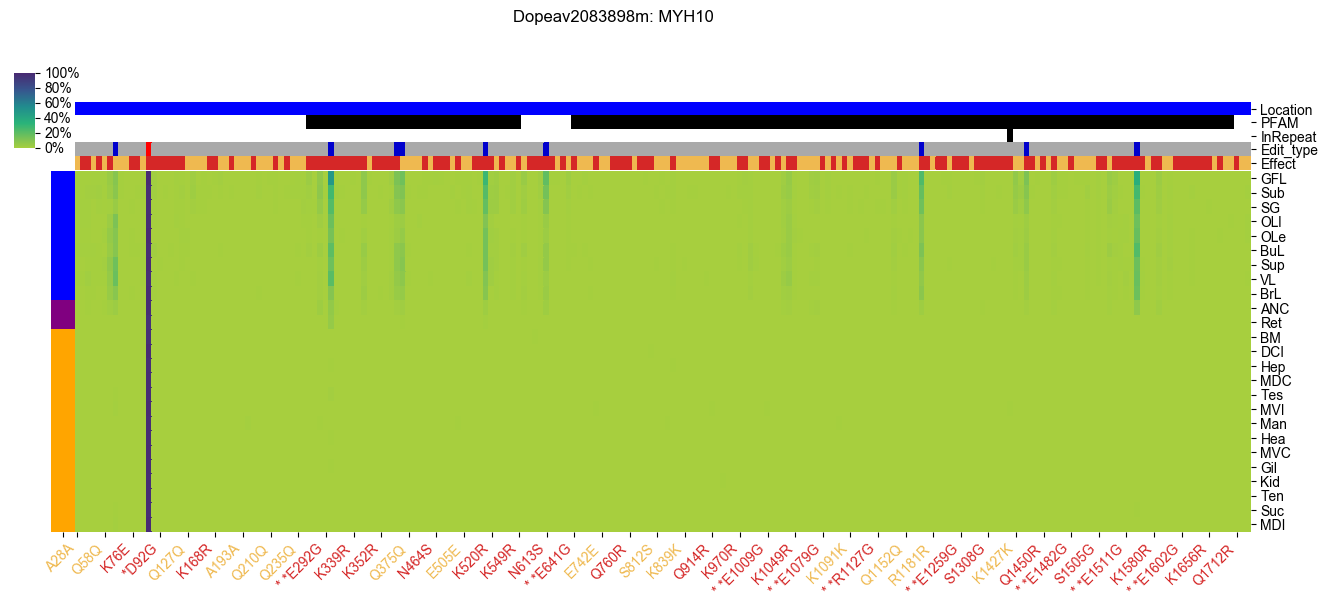

Dopeav2047152m: KCNA1 - Voltage-gated shaker-like K+ channel KCNA


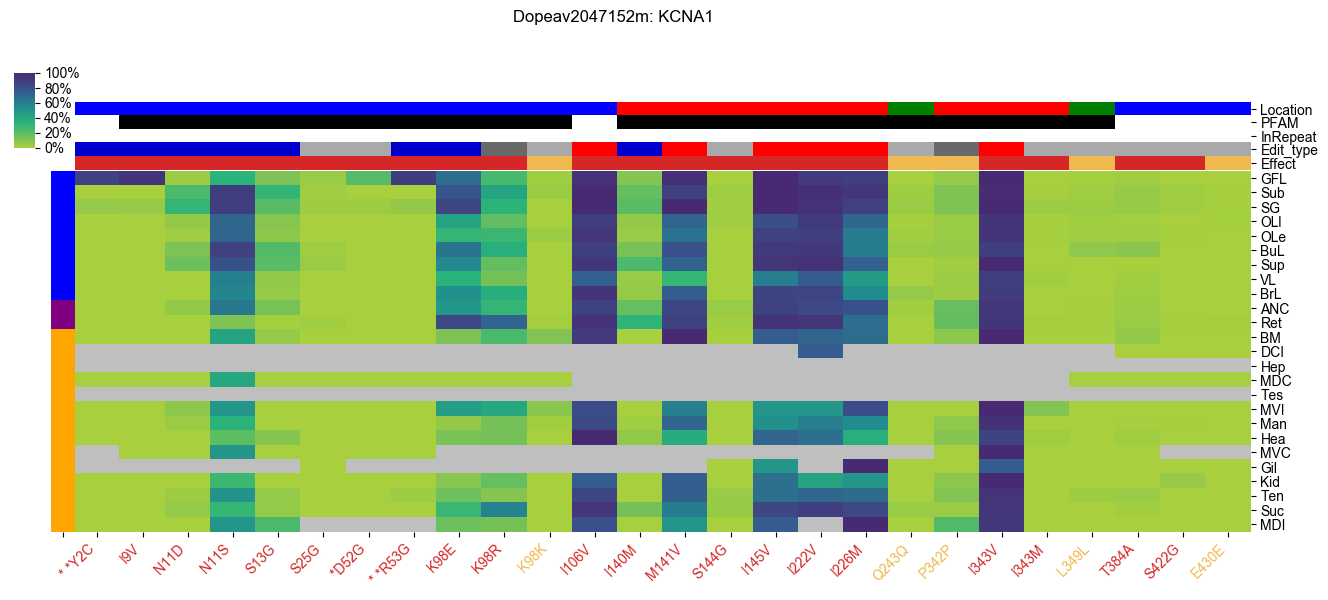

Dopeav2108578m: MYCBP2 - Inhibitor of type V adenylyl cyclases/Neuronal presynaptic protein Highwire/PAM/RPM-1


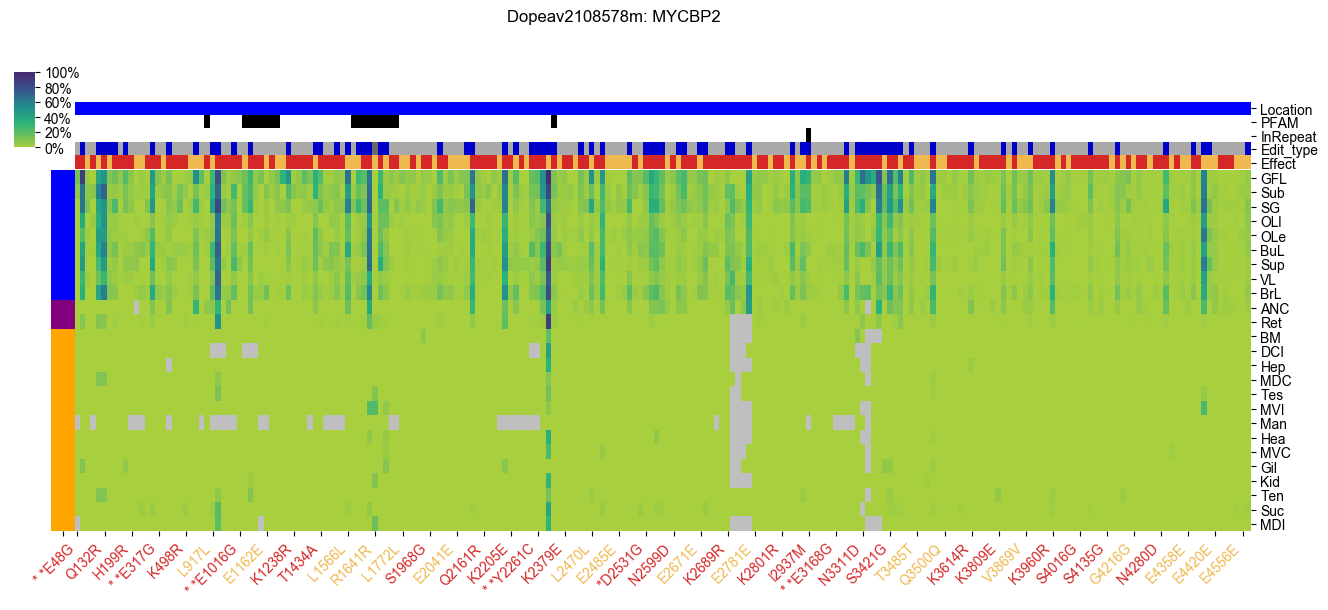

Dopeav2011285m: TNK2 - ACK and related non-receptor tyrosine kinases


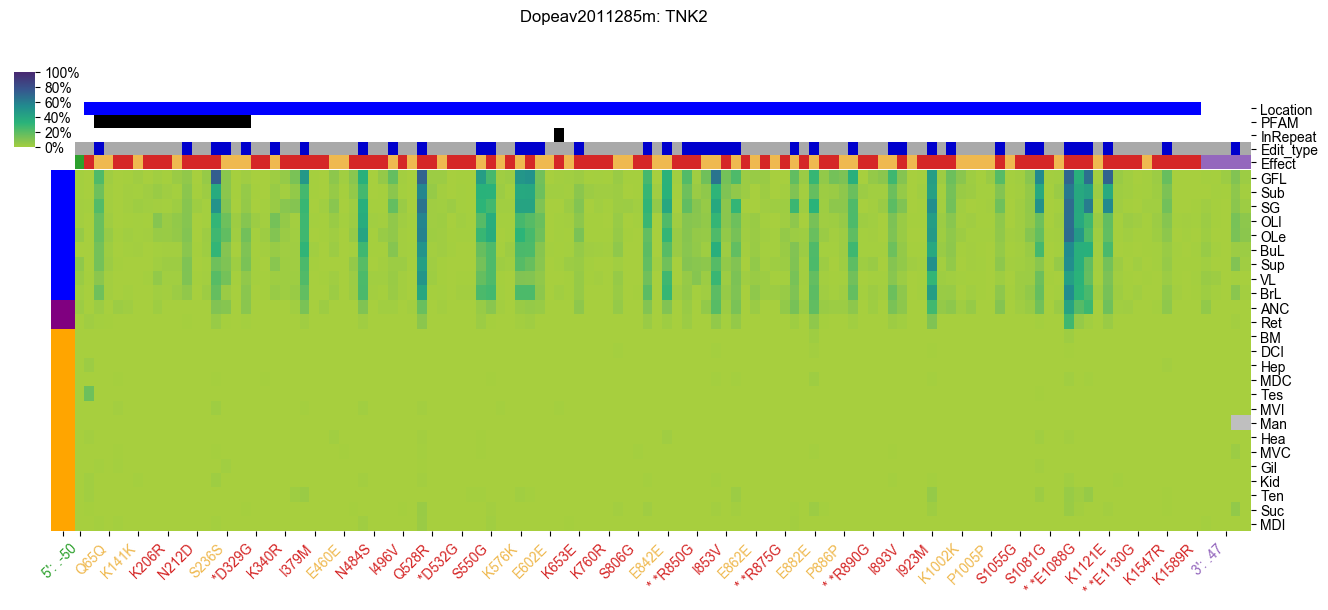

Dopeav2040483m: ARHGAP32 - 


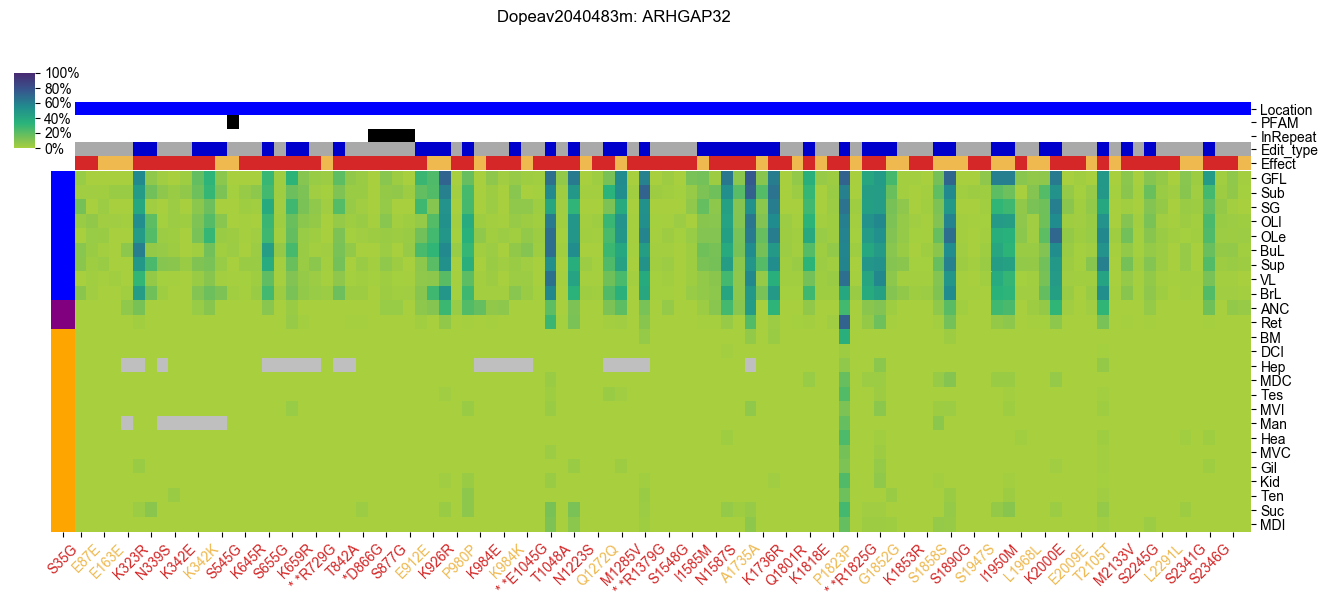

Dopeav2112640m: SPG11 - 


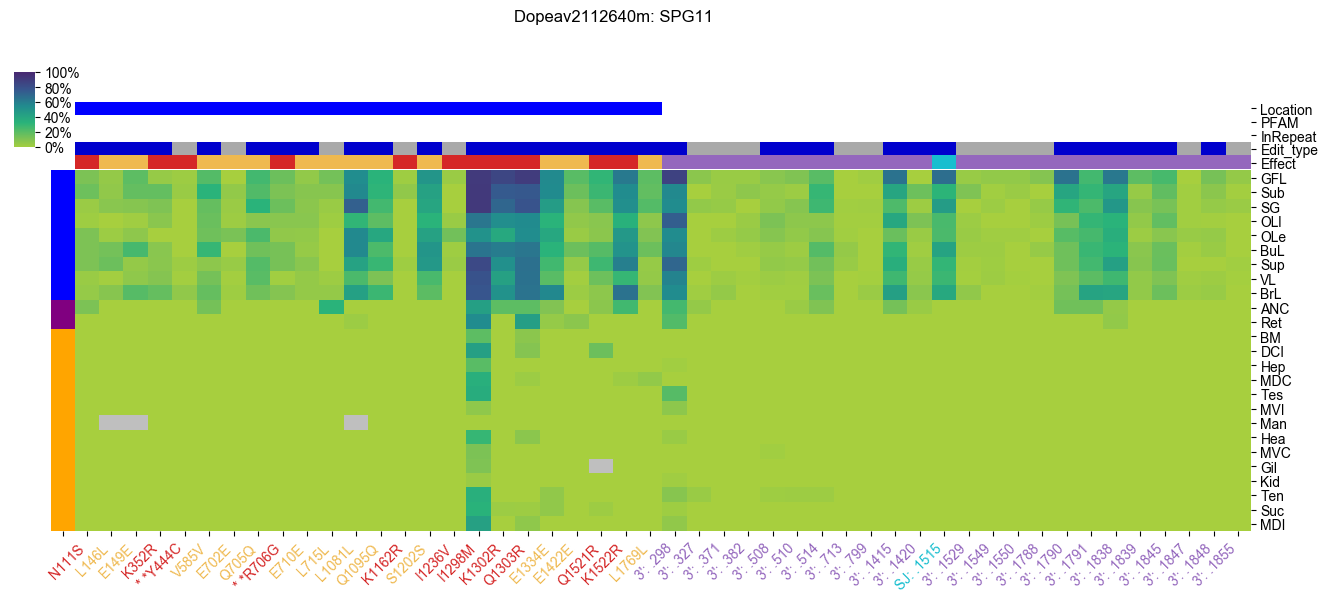

Dopeav2061683m: DYNC1H1 - Dyneins, heavy chain


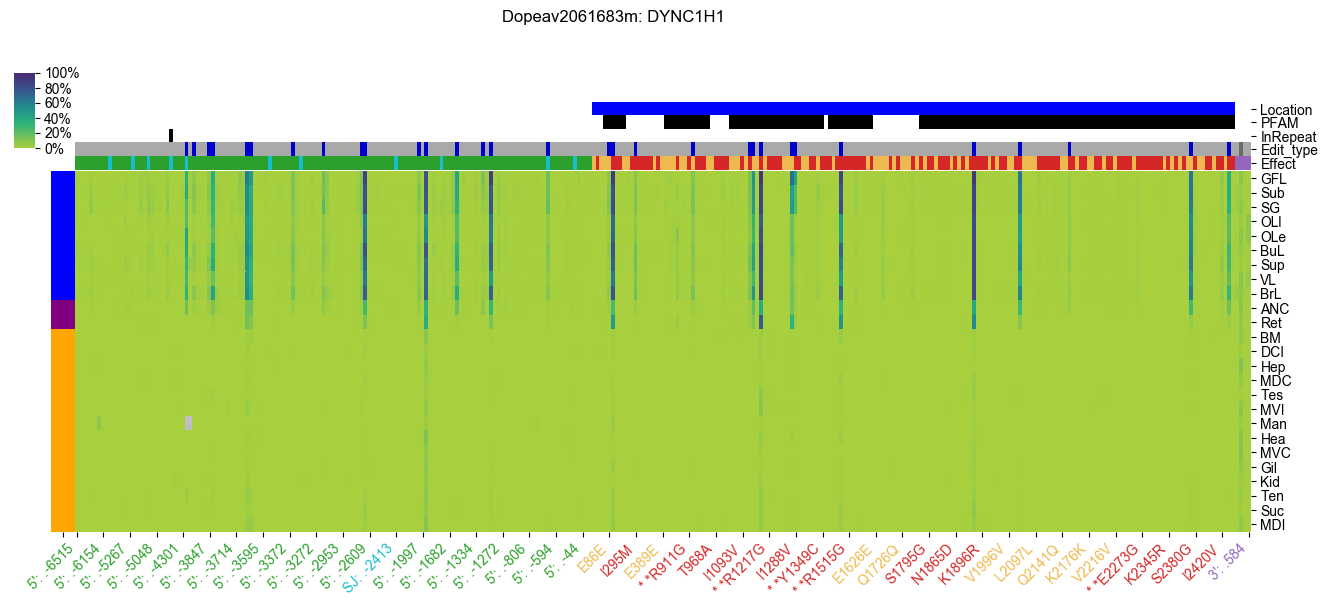

Dopeav2047480m: ATP1B1 - 


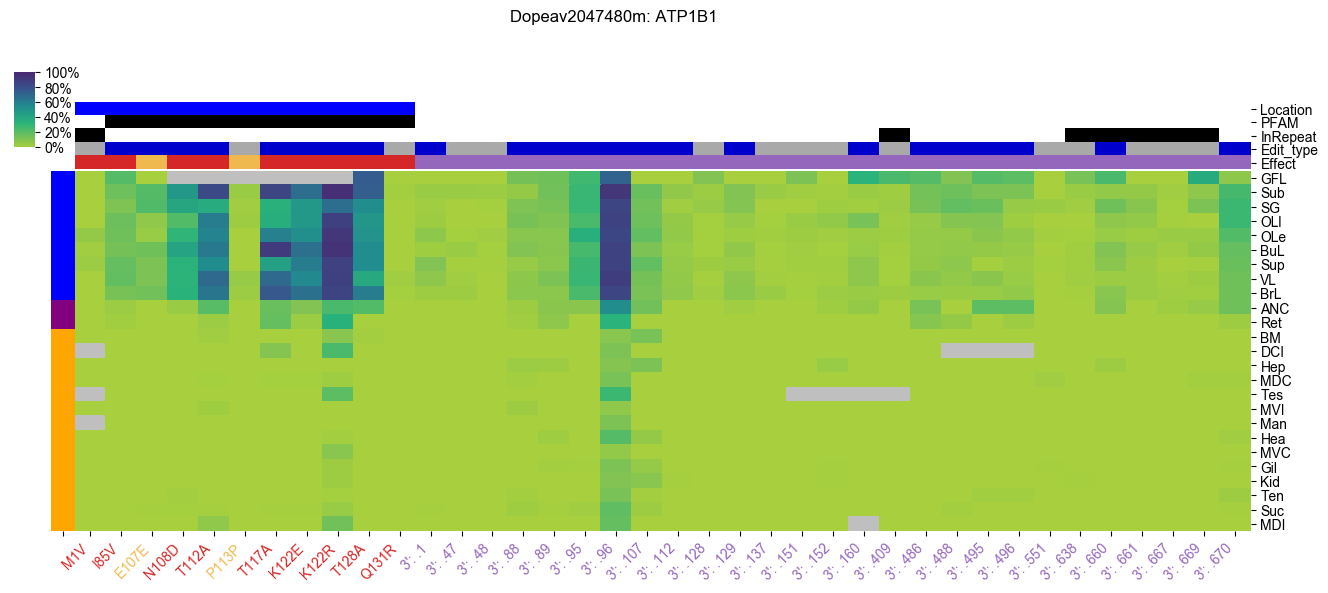

In [74]:
for gene_id in ['Dopeav2001438m','Dopeav2083898m','Dopeav2047152m','Dopeav2108578m','Dopeav2011285m','Dopeav2040483m','Dopeav2112640m','Dopeav2061683m','Dopeav2047480m']:
    draw_EF_genes_test(gene_id, ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')



Dopeav2009339m: CHRNA4 - Acetylcholine receptor


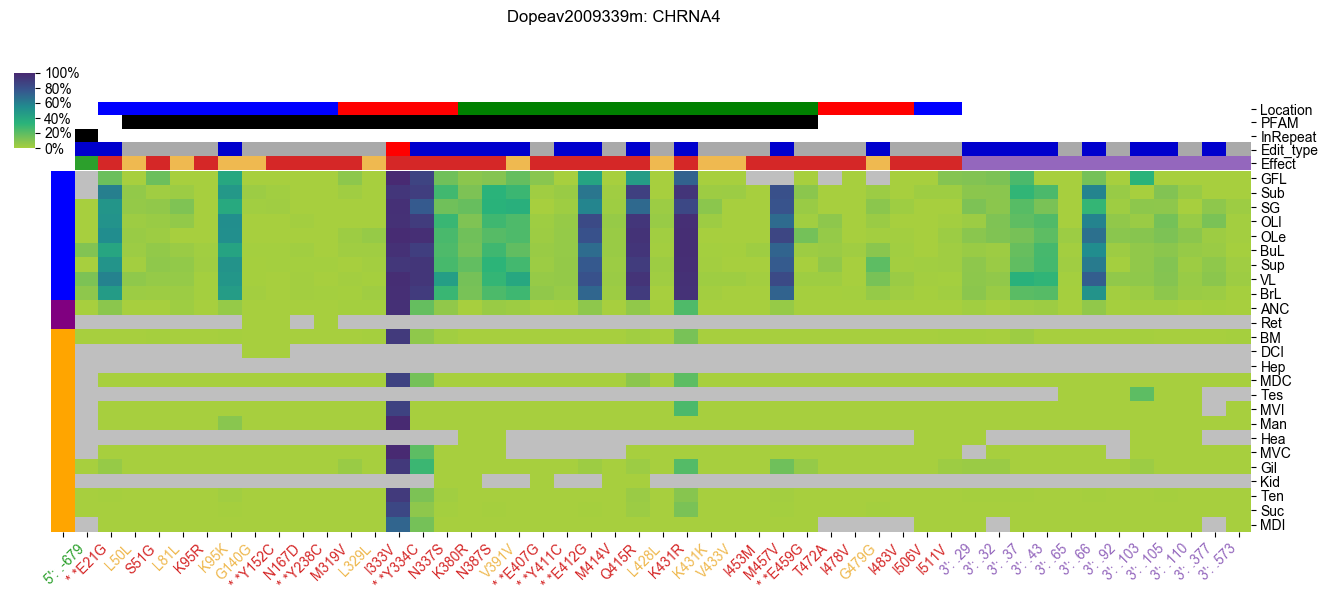

Dopeav2022545m: TUBB2B - Beta tubulin


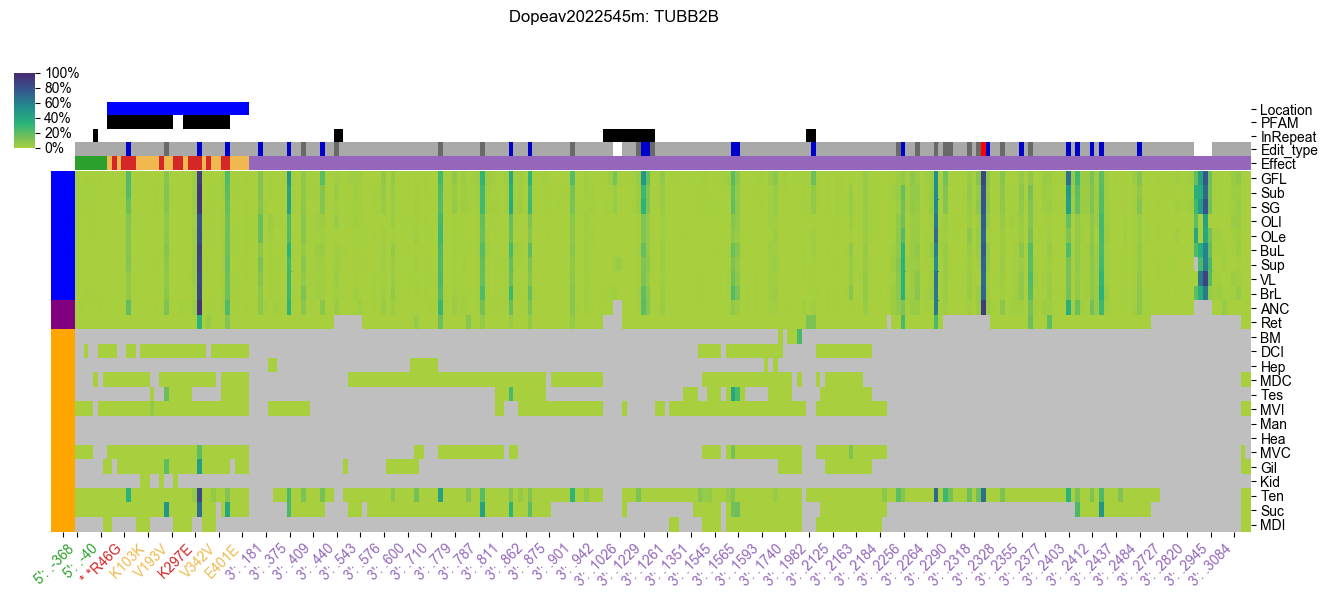

Dopeav2035157m: TUBB4B - Beta tubulin


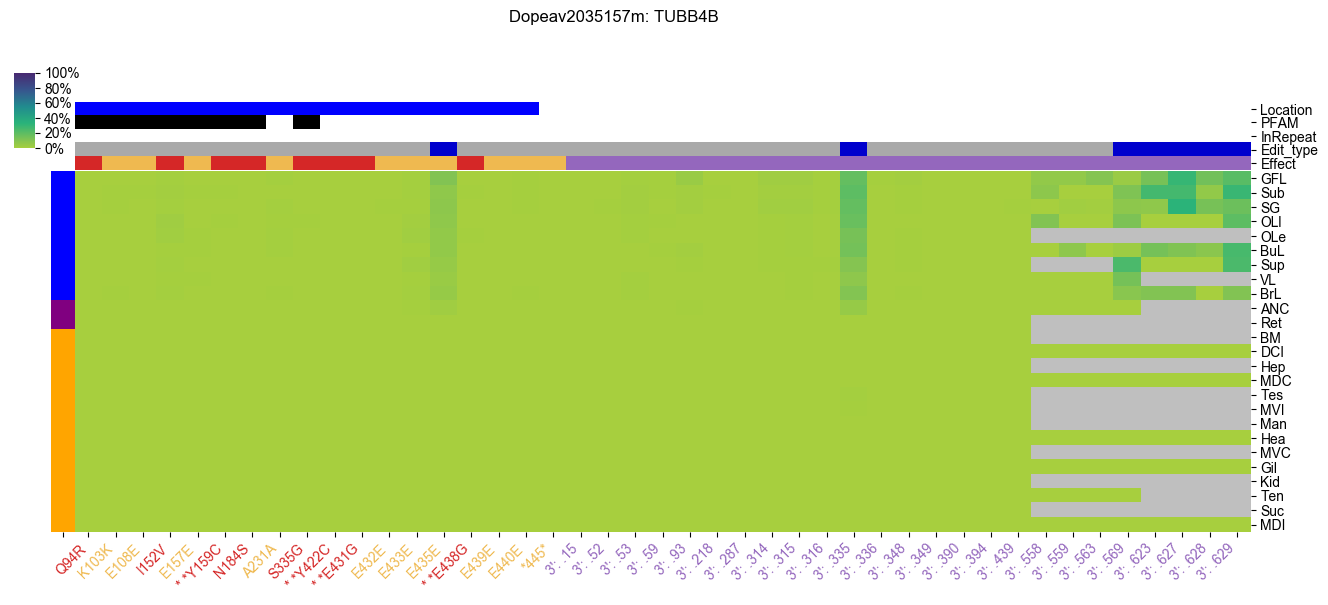

Dopeav2090381m: TUBB2B - Beta tubulin


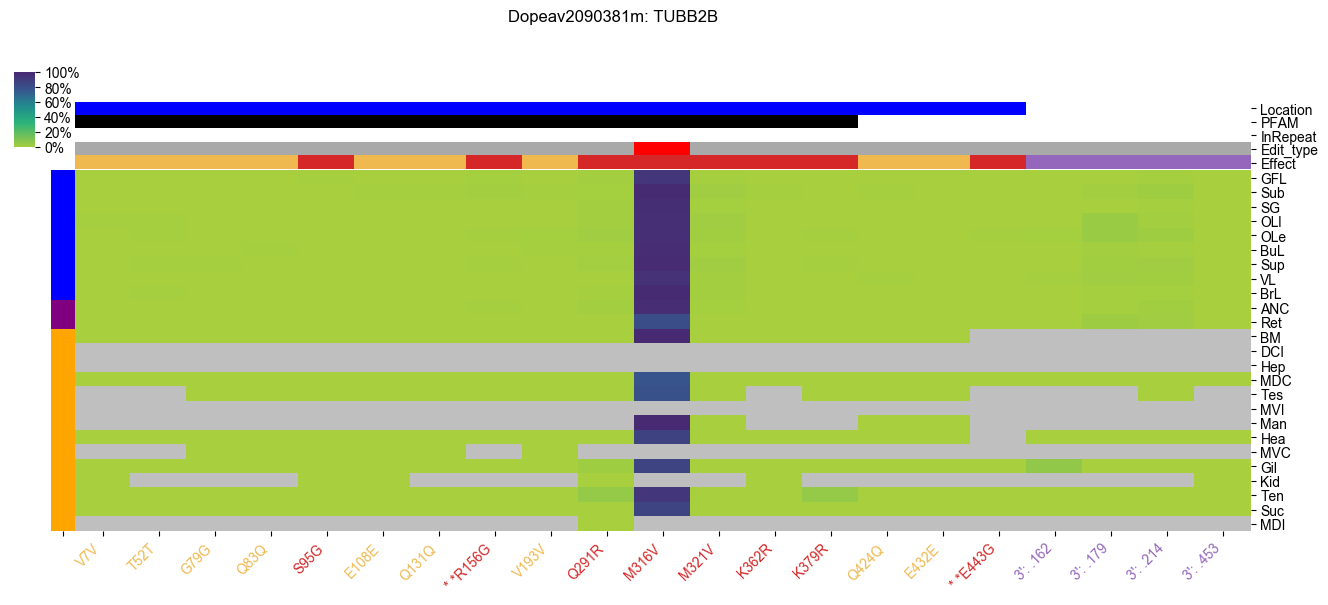

Dopeav2091687m: TUBB4B - Beta tubulin


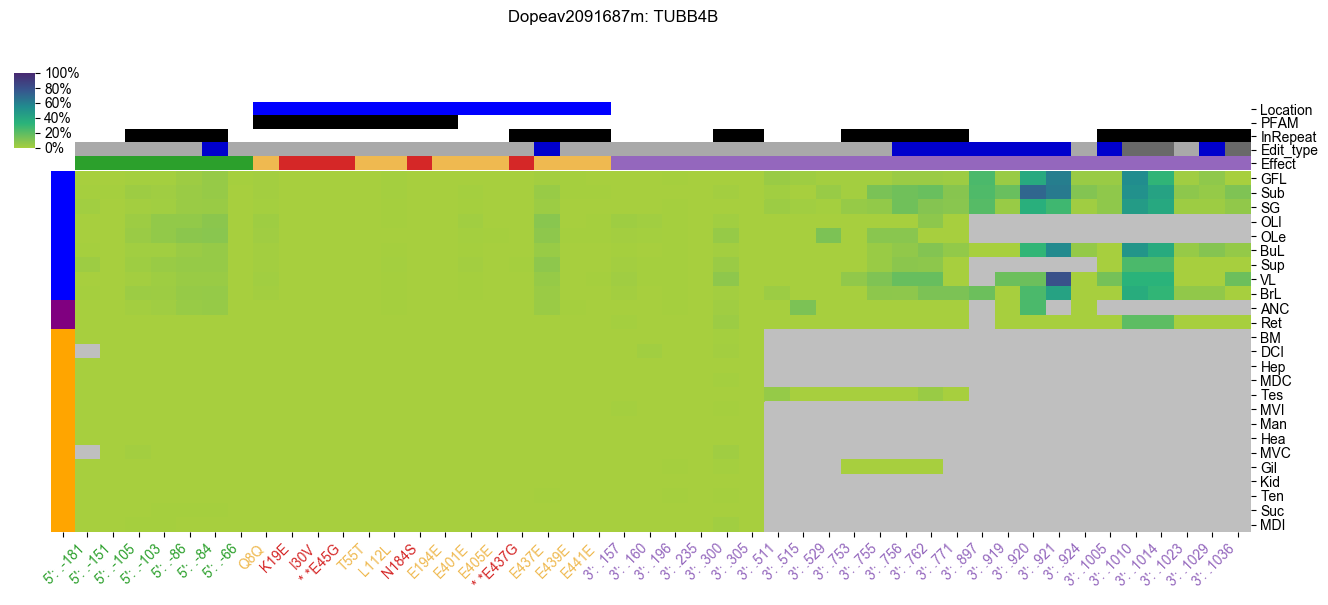

Dopeav2032892m: AP3M1 - Clathrin-associated protein medium chain


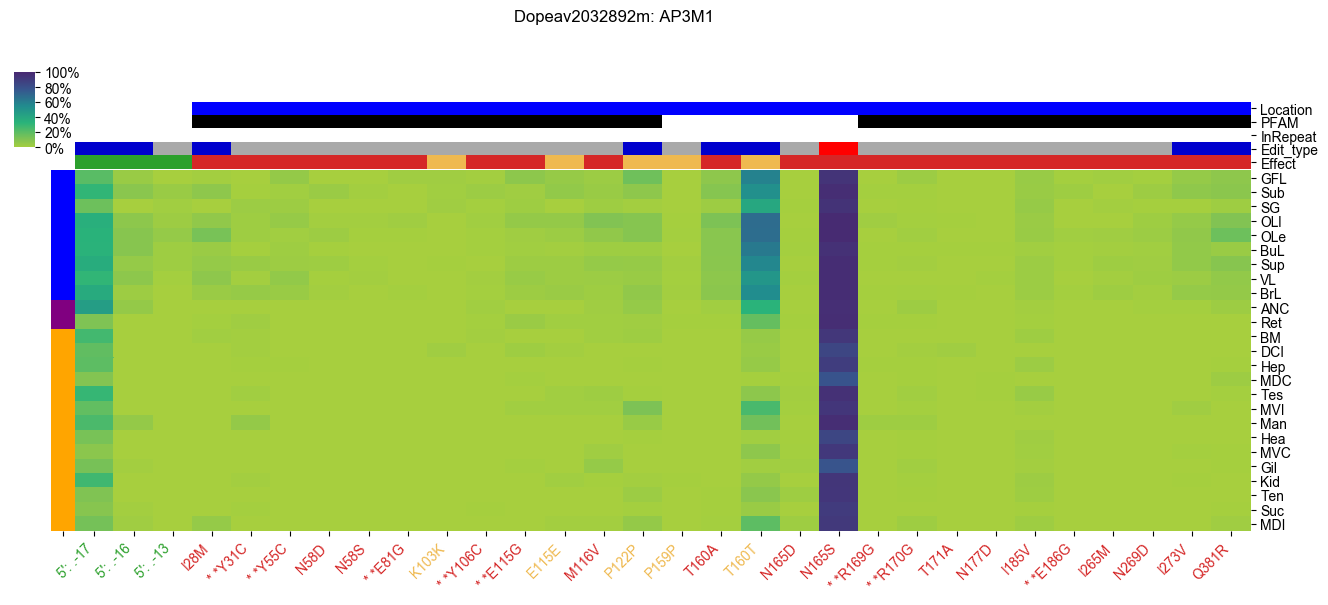

In [75]:

draw_EF_genes_test('Dopeav2009339m', ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')

for gene_id in ADAR_Albertin[ADAR_Albertin.GeneID.isin(Gene_description[Gene_description.HUGO.str.contains('TUBB')].transcriptName.unique())].GeneID.unique():
    draw_EF_genes_test(gene_id, ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')


draw_EF_genes_test('Dopeav2032892m', ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')





### Ubiq-expressed sites sorted by the weighted neural edit frequency:



In [76]:
To_select = ADAR_Albertin[ (ADAR_Albertin.ID.isin(DP_Albertin[DP_Albertin.T.max()>=5].index.to_list()))].ID.unique()#.to_list()
# previously on V2 analysis: ('sites_with_min_depth_5reads:', 63254)
# Now: 217055
print (len(To_select))



214017


In [78]:
ADAR_Albertin.shape

(214017, 48)

## Clustering of edit sites by Gaussian Mixture model
1. Identify ideal number of groups using AIC and BIC criteria.
2. Rename groups by ovreall edit frequency. 

### Identification of genes whose expression correlate with RNA editing profile

In [51]:
Genes_by_kind = dict()
Genes_by_kind['RNA_binding_genes'] = Gene_description[Gene_description['PFAM description'].str.contains('RNA binding')].transcriptName.to_list()
Genes_by_kind['Deaminases'] = Gene_description[Gene_description['PFAM description'].str.contains('deaminase')].transcriptName.to_list()
Genes_by_kind['ADARS'] = Gene_description[Gene_description['HUGO'].str.contains('ADAR')].transcriptName.to_list()
Genes_by_kind['DSR'] = Gene_description[(Gene_description['PFAM description'].str.contains('stranded RNA', case=False)) | (Gene_description['PFAM description'].str.contains('double-stranded', case=False))].transcriptName.to_list()
Genes_by_kind['RNA'] = Gene_description[Gene_description['PFAM description'].str.contains('RNA', case=False)].transcriptName.to_list()
Genes_by_kind['transport'] = Gene_description[Gene_description['PFAM description'].str.contains('transport', case=False)].transcriptName.to_list()




In [52]:
# Load tophat mRNA counts

Tophat = pd.read_csv(Tophat_tpm_file, sep='\t', index_col=0)
Tophat = Tophat[Tophat.columns.to_list()[5:]]
Tophat = Tophat.rename(columns=Tophat.columns.to_series().apply(lambda x: x.replace('_tophat.md.bam','')).to_dict())
Tophat = Tophat.rename(index=Tophat.index.to_series().apply(lambda x: x.replace('.g','')).to_dict())
Tophat.head()

ANC         BM        Blo        BrL        BuL  \
Geneid                                                                  
Dopeav2000002m   8.416878   9.422058   0.197944  14.948124   5.076805   
Dopeav2000027m  51.064615  27.275085  50.352474  80.111946  72.356910   
Dopeav2000031m   0.876366   0.000000   0.000000   0.141574   0.000000   
Dopeav2000035m   3.202892   3.139753   5.687945   6.854660   6.509813   
Dopeav2000039m   2.824481   2.215042   7.797401   7.051129   4.759907   

                      DCI         GFL         Gil        Hea        Hep  ...  \
Geneid                                                                   ...   
Dopeav2000002m   0.113807    0.893585   25.107553   0.502835   0.780117  ...   
Dopeav2000027m  47.583596  123.857982   52.831488  80.682881  63.565207  ...   
Dopeav2000031m   0.262385  403.660620  151.200832   0.000000   0.343364  ...   
Dopeav2000035m   5.409457    6.840581    5.441128   7.475840   4.558418  ...   
Dopeav2000039m   3.089451    1.755867    4.294852   4.551164   1.967365  ...   

                      OLl        PSG        Ret          SG        Sub  \
Geneid                                                                   
Dopeav2000002m   2.965006   0.792844   0.082310    5.499378   6.400169   
Dopeav2000027m  70.369993  39.014083  80.140456   88.375159  81.950735   
Dopeav2000031m   0.139508   0.000000   0.000000  103.638020   0.539373   
Dopeav2000035m   7.386493   3.425925   6.039754    5.658787   6.844680   
Dopeav2000039m  10.665115   3.848963   6.418735    2.021620   4.328540   

                      Suc        Sup        Ten        Tes         VL  
Geneid                                                                 
Dopeav2000002m  20.740017  10.803657   3.357802   2.573710   5.432940  
Dopeav2000027m  79.774109  75.800829  59.765610  23.924010  80.259783  
Dopeav2000031m   0.245033   0.000000   0.000000  11.593816   0.000000  
Dopeav2000035m   8.228184   7.241151   5.365405   7.841494   5.780091  
Dopeav2000039m   7.634042   6.638687   2.640577   6.221211  12.453463  

[5 rows x 28 columns]

In [53]:
Mean_expression_tophat = pd.DataFrame()
Mean_expression_tophat['Neural_mean'] = Tophat[Neural_samples[2:]].T.mean()
Mean_expression_tophat['NotNeural_mean'] = Tophat[NotNeu_samples].T.mean()
Mean_expression_tophat['Neural_stdev'] = Tophat[Neural_samples[2:]].T.std()
Mean_expression_tophat['NotNeural_stdev'] = Tophat[NotNeu_samples].T.std()
Mean_expression_tophat['Vs'] = Mean_expression_tophat.Neural_mean-Mean_expression_tophat.Neural_stdev + Mean_expression_tophat.NotNeural_mean+Mean_expression_tophat.NotNeural_stdev

Mean_expression_tophat['2Fold_N_vs_NN'] = False
Mean_expression_tophat.loc[Mean_expression_tophat['Neural_mean']>2*Mean_expression_tophat['NotNeural_mean'],'2Fold_N_vs_NN'] = True
print (Mean_expression_tophat[Mean_expression_tophat['2Fold_N_vs_NN']==True].shape[0])

Mean_expression_tophat['3Fold_N_vs_NN'] = False
Mean_expression_tophat.loc[Mean_expression_tophat['Neural_mean']>3*Mean_expression_tophat['NotNeural_mean'],'3Fold_N_vs_NN'] = True
print (Mean_expression_tophat[Mean_expression_tophat['3Fold_N_vs_NN']==True].shape[0])

Differential_RNAassociated = Mean_expression_tophat[(Mean_expression_tophat['3Fold_N_vs_NN']==True) & (Mean_expression_tophat.index.isin(Genes_by_kind['RNA'])) ].index.to_list() #& (Mean_expression_tophat['Vs']>0)


To_rename = Gene_description[Gene_description.transcriptName.isin(Differential_RNAassociated)|Gene_description.HUGO.str.contains('ADAR')][['transcriptName','HUGO']]
To_rename['ID'] = To_rename.transcriptName + '_' + To_rename.HUGO
To_rename =To_rename.set_index('transcriptName')
To_rename_dict = To_rename['ID'].to_dict()
To_rename_dict['Dopeav2005419m'] = 'Dopeav2005419m_ADAR-like'
To_rename_dict['Dopeav2016222m'] = 'Dopeav2016222m_ADAR1'
To_rename_dict['Dopeav2017526m'] = 'Dopeav2017526m_ADAR2'
To_rename_dict['Dopeav2118252m'] = 'Dopeav2118252m_ADAR2'


7891
5000


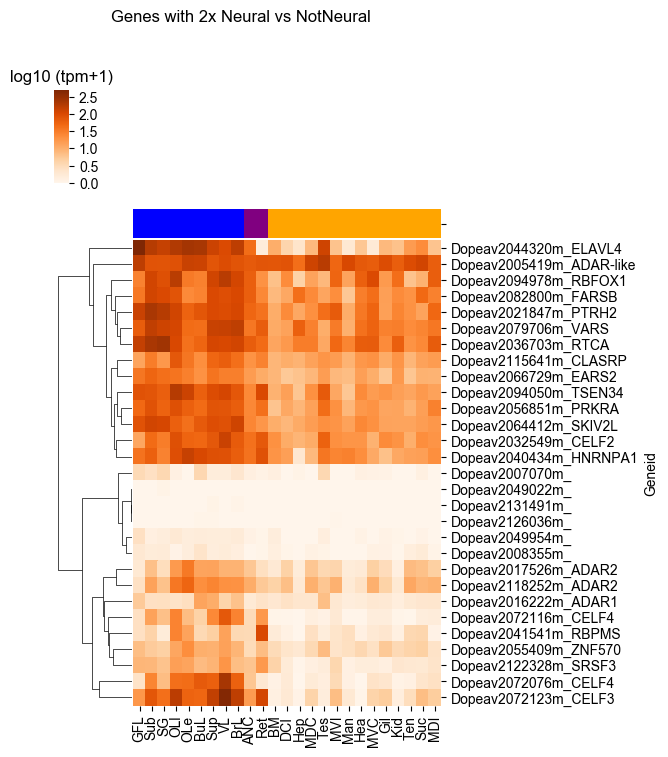

./Tables_DATA/Fig_7b_log10tpm.tab


transcriptName    HUGO  \
626   Dopeav2082800m   FARSB   
3484  Dopeav2055409m  ZNF570   
4369  Dopeav2041541m   RBPMS   
4584  Dopeav2044320m  ELAVL4   
4969  Dopeav2032549m   CELF2   

                                       PFAM description  \
626               tRNA synthetase B5 domain|B3/4 domain   
3484  Zinc finger, C2H2 type|Zinc finger, C2H2 type|...   
4369  RNA recognition motif. (a.k.a. RRM, RBD, or RN...   
4584  RNA recognition motif. (a.k.a. RRM, RBD, or RN...   
4969  RNA recognition motif. (a.k.a. RRM, RBD, or RN...   

                                        KOG description  \
626                                                       
3484                                                      
4369         RNA binding protein (contains RRM repeats)   
4584      RNA-binding protein ELAV/HU (RRM superfamily)   
4969  RNA-binding protein CUGBP1/BRUNO (RRM superfam...   

                   EC description  \
626   Phenylalanine--tRNA ligase.   
3484                                
4369                                
4584                                
4969                                

                                         GO description  \
626   phenylalanine-tRNA ligase activity|magnesium i...   
3484                                                      
4369                               nucleic acid binding   
4584                               nucleic acid binding   
4969                               nucleic acid binding   

                      SPROT  \
626    sp|Q9WUA2|SYFB_MOUSE   
3484  sp|Q96NI8|ZN570_HUMAN   
4369    sp|Q01617|CPO_DROME   
4584  sp|Q7SZT7|ELAV4_XENLA   
4969  sp|Q7ZXE2|CELF2_XENLA   

                                                cephOrt  Neural_mean  \
626   apl162195_c0_seq1.p1,bim134350_c0_seq1.p1,nau2...    77.454916   
3484  apl149546_c0_seq1.p1,nau177097_c0_seq6.p1,nau2...     9.658868   
4369  apl143206_c0_seq1.p1,oct167918_c0_seq6.p1,sep2...     7.443391   
4584  apl162191_c1_seq4.p1,bim160278_c0_seq12.p1,nau...   214.914353   
4969  apl159016_c0_seq10.p1,bim166323_c2_seq6.p1,nau...    62.870355   

      NotNeural_mean  Neural_stdev  NotNeural_stdev          Vs  \
626        23.594525     38.407621        13.976904   76.618723   
3484        2.601775      5.464929         1.537708    8.333421   
4369        1.051759      8.692525         0.918959    0.721584   
4584       15.492157    124.287228        32.970730  139.090013   
4969       18.776336     35.826708        12.425506   58.245489   

      2Fold_N_vs_NN  3Fold_N_vs_NN  
626            True           True  
3484           True           True  
4369           True           True  
4584           True           True  
4969           True           True

In [54]:
To_plot_tophat = Tophat.loc[To_rename_dict.keys(),Neural_samples[::-1]+ NotNeu_samples]
To_plot_tophat = To_plot_tophat.rename(index=To_rename_dict)

sns.clustermap(np.log10(To_plot_tophat+1), col_cluster=False, cmap='Oranges', col_colors=col_colors,col_linkage=linkage, figsize=(5,8), xticklabels=True, yticklabels=True)#, z_score=0)
plt.suptitle('Genes with 2x Neural vs NotNeural')
plt.title('log10 (tpm+1)')
plt.savefig('Fig_S7b_Differential_Final.pdf', bbox_inches='tight')

plt.show()

out_table(np.log10(To_plot_tophat+1),'Fig_7b_log10tpm.tab')
pd.merge(Gene_description[Gene_description.transcriptName.isin(Differential_RNAassociated)][['transcriptName','HUGO','PFAM description','KOG description','EC description','GO description','SPROT','cephOrt']], Mean_expression_tophat.loc[To_rename_dict.keys()], left_on='transcriptName', right_index=True).head()

Dopeav2082800m: FARSB - 


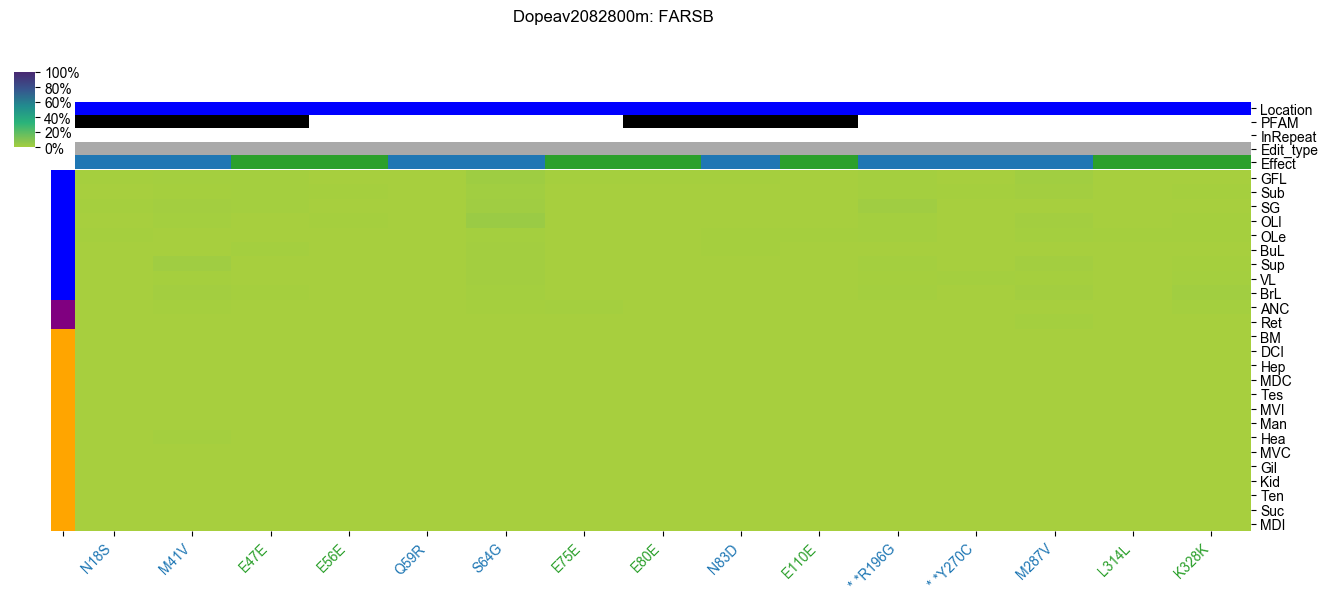

Dopeav2041541m: RBPMS - RNA binding protein (contains RRM repeats)


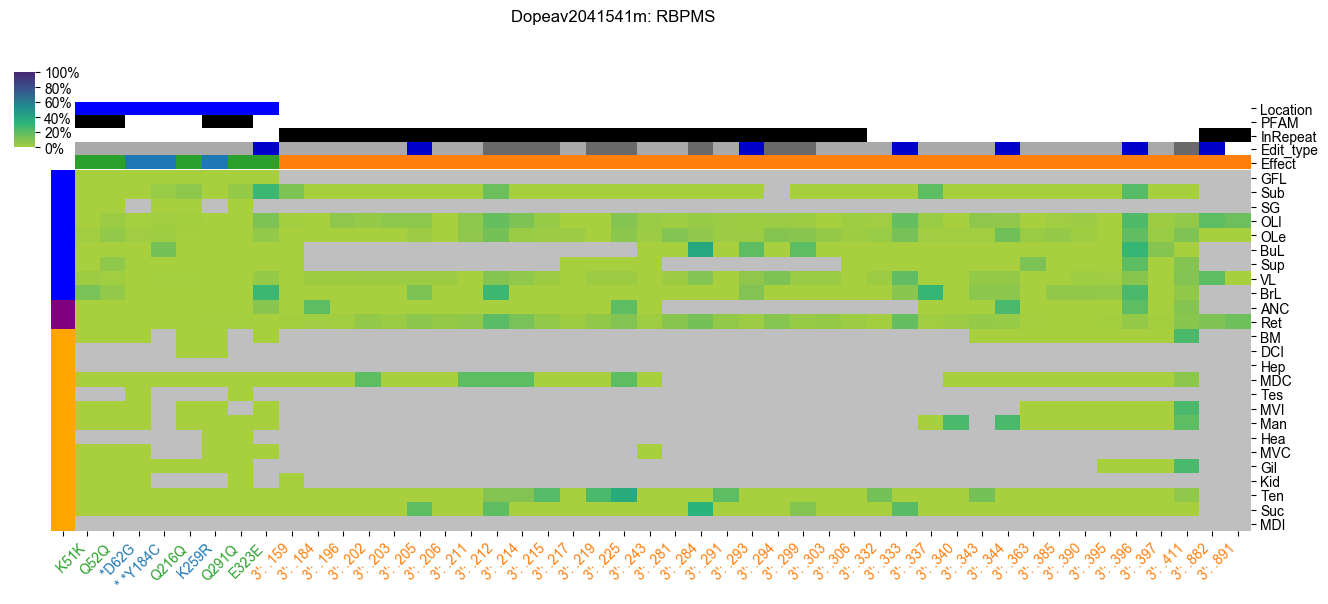

Dopeav2044320m: ELAVL4 - RNA-binding protein ELAV/HU (RRM superfamily)


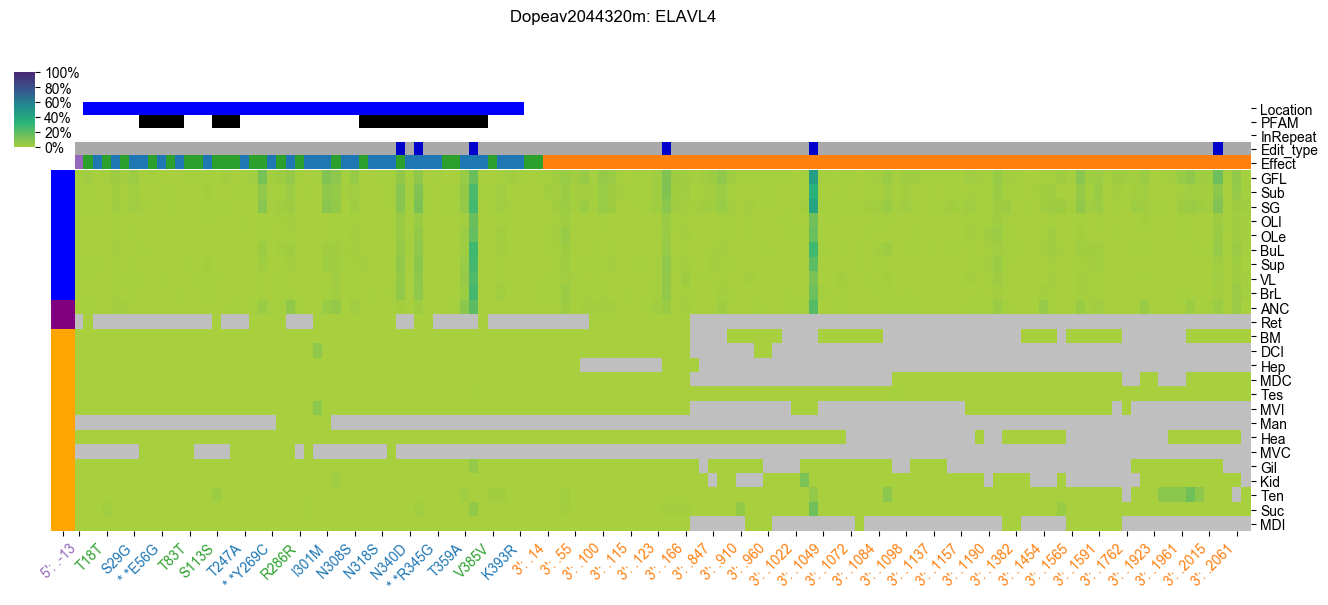

Dopeav2032549m: CELF2 - RNA-binding protein CUGBP1/BRUNO (RRM superfamily)


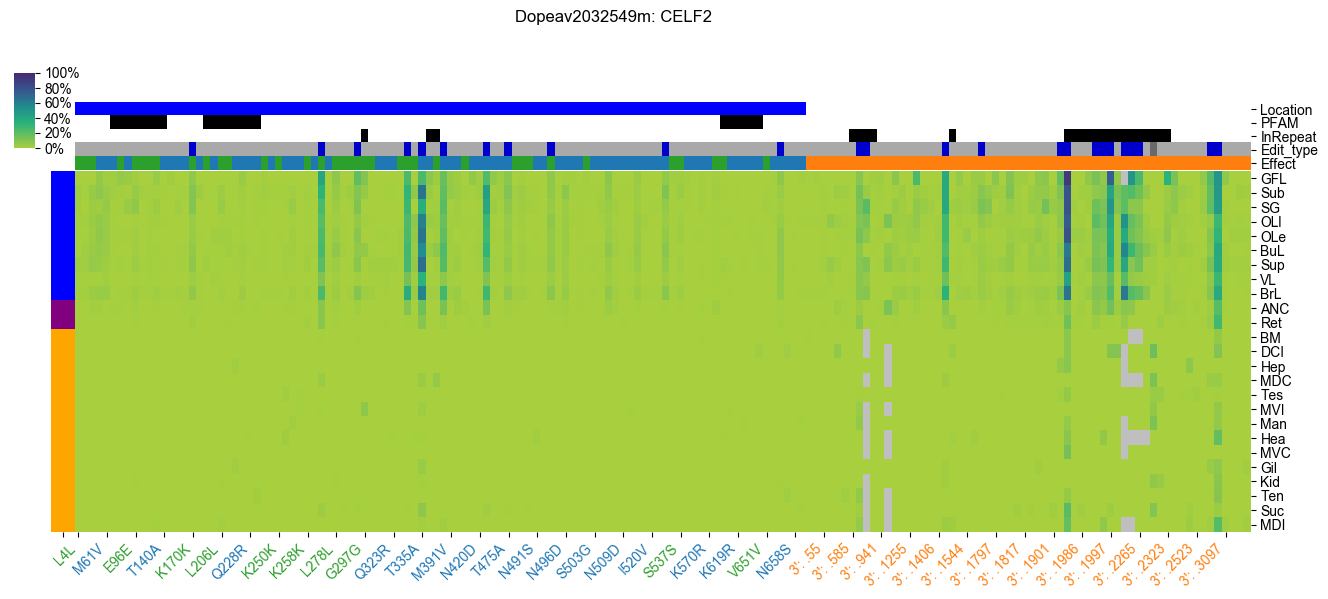

Dopeav2115641m: CLASRP - SWAP mRNA splicing regulator


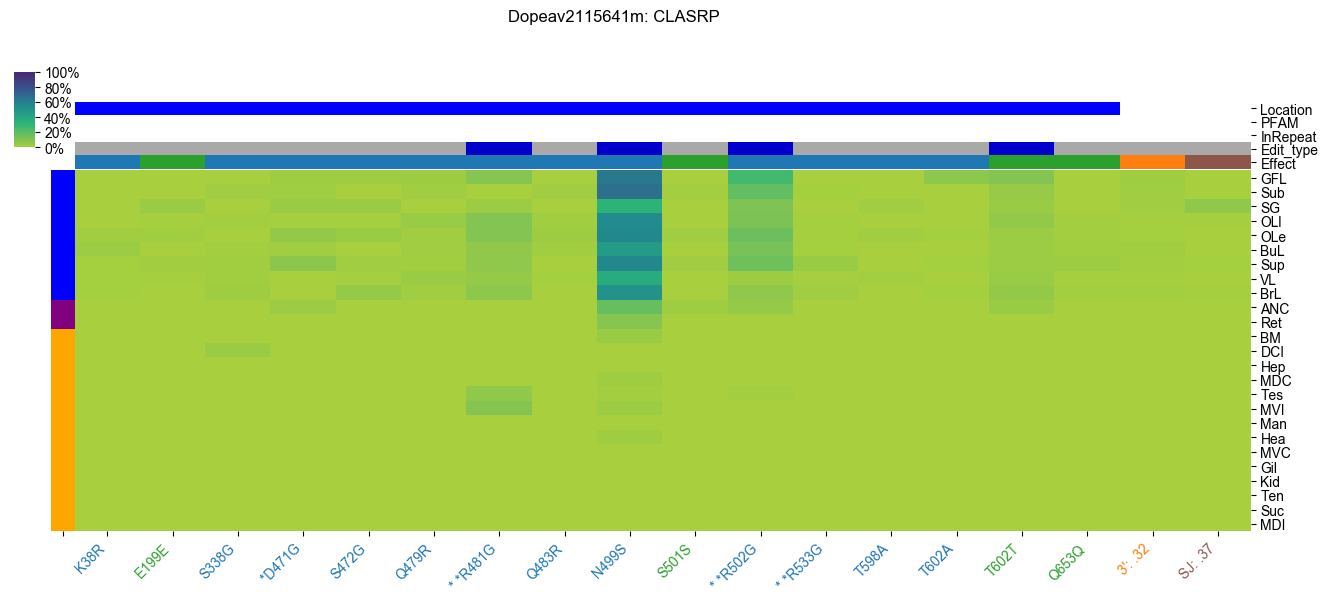

Dopeav2056851m: PRKRA - Staufen and related double-stranded-RNA-binding proteins


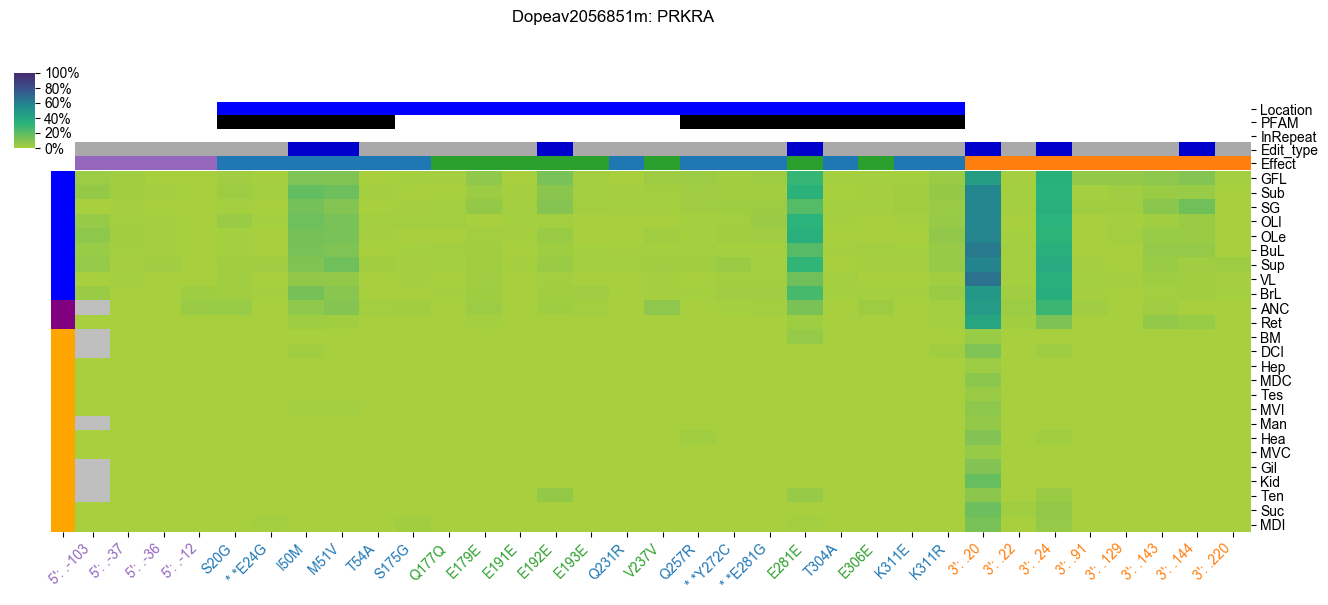

Dopeav2064412m: SKIV2L - Cytoplasmic exosomal RNA helicase SKI2, DEAD-box superfamily


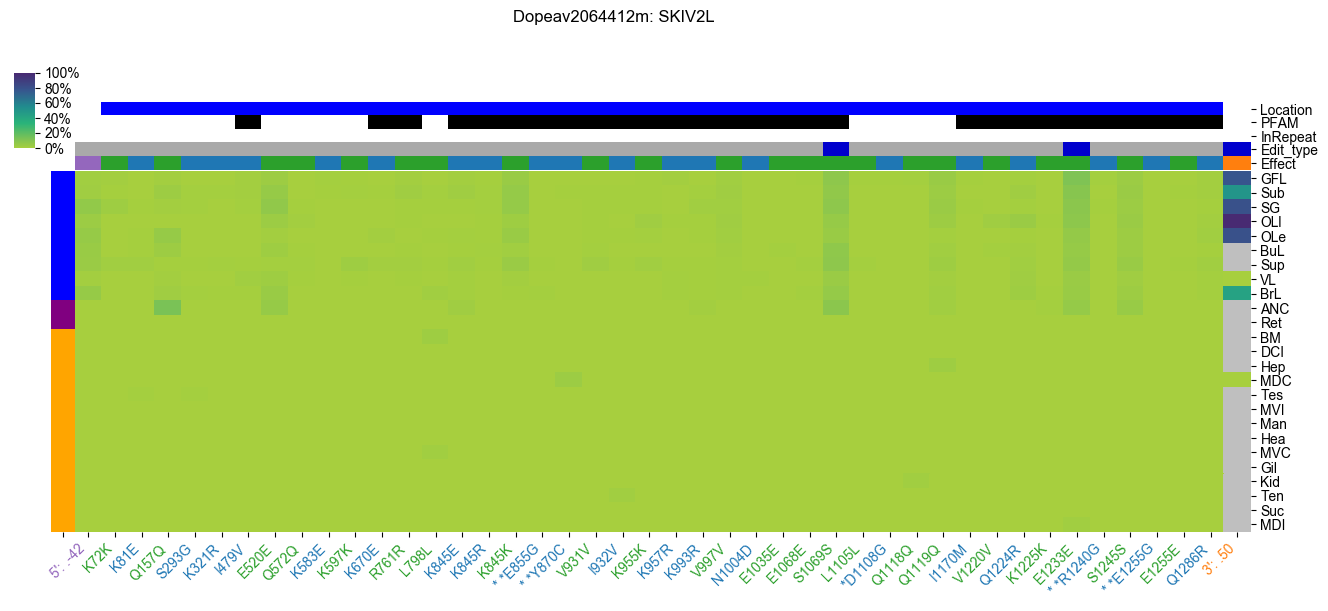

Dopeav2079706m: VARS - Valyl-tRNA synthetase


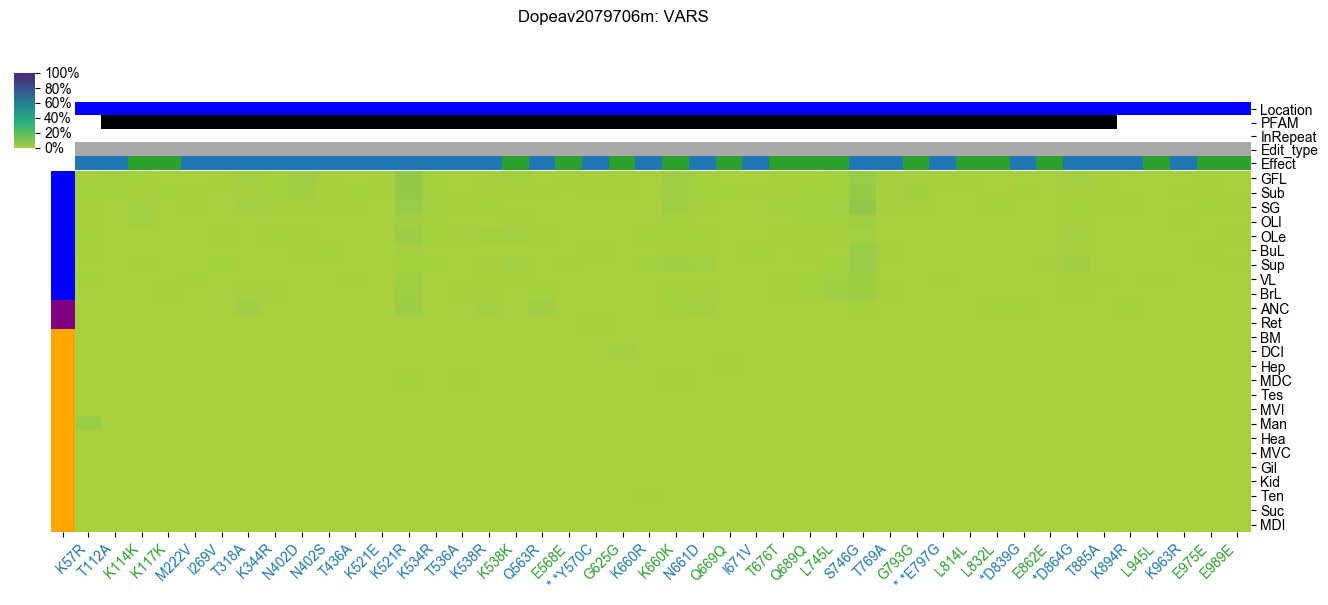

Dopeav2094978m: RBFOX1 - 


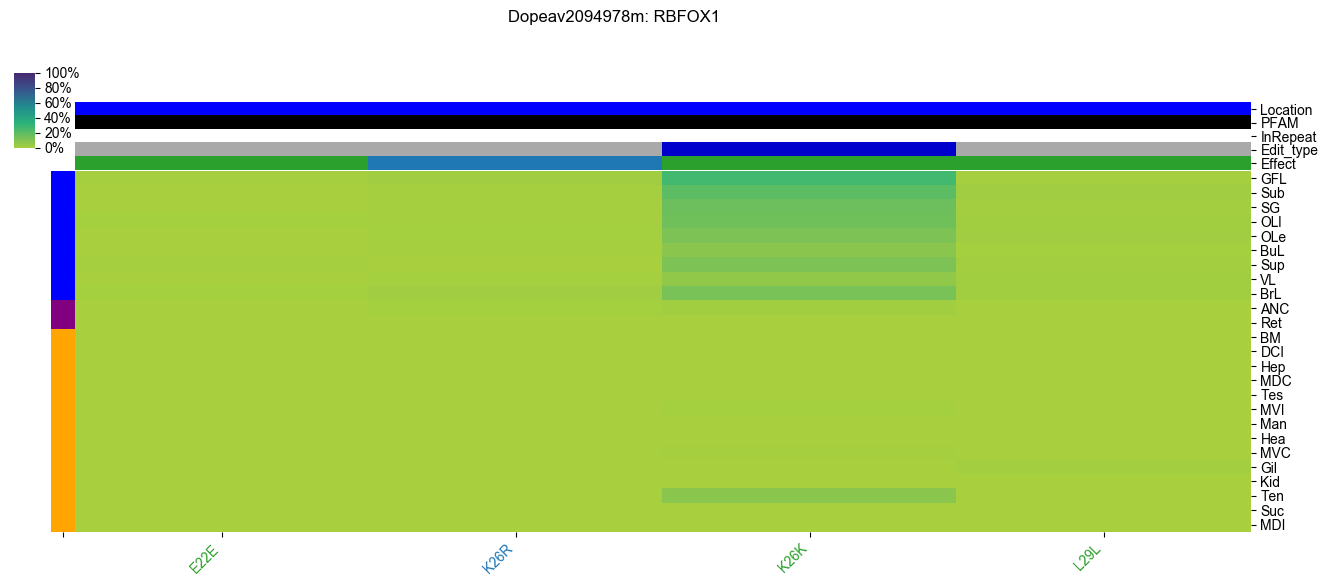

Dopeav2094050m: TSEN34 - 


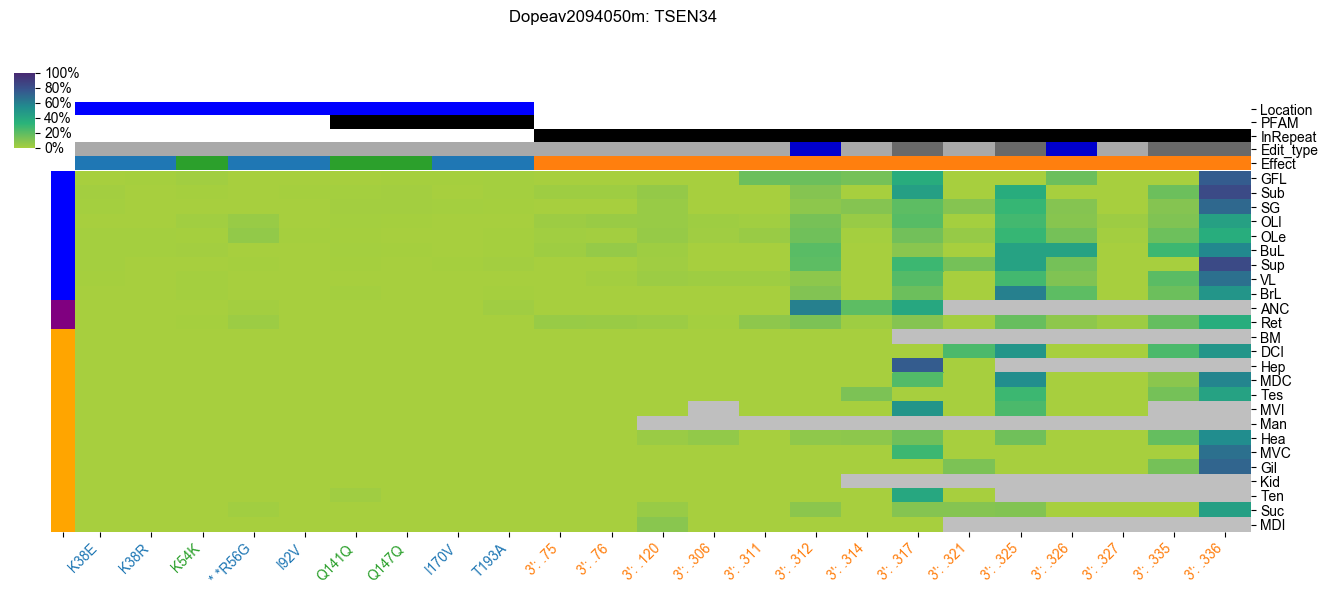

Dopeav2036703m: RTCA - RNA 3'-terminal phosphate cyclase


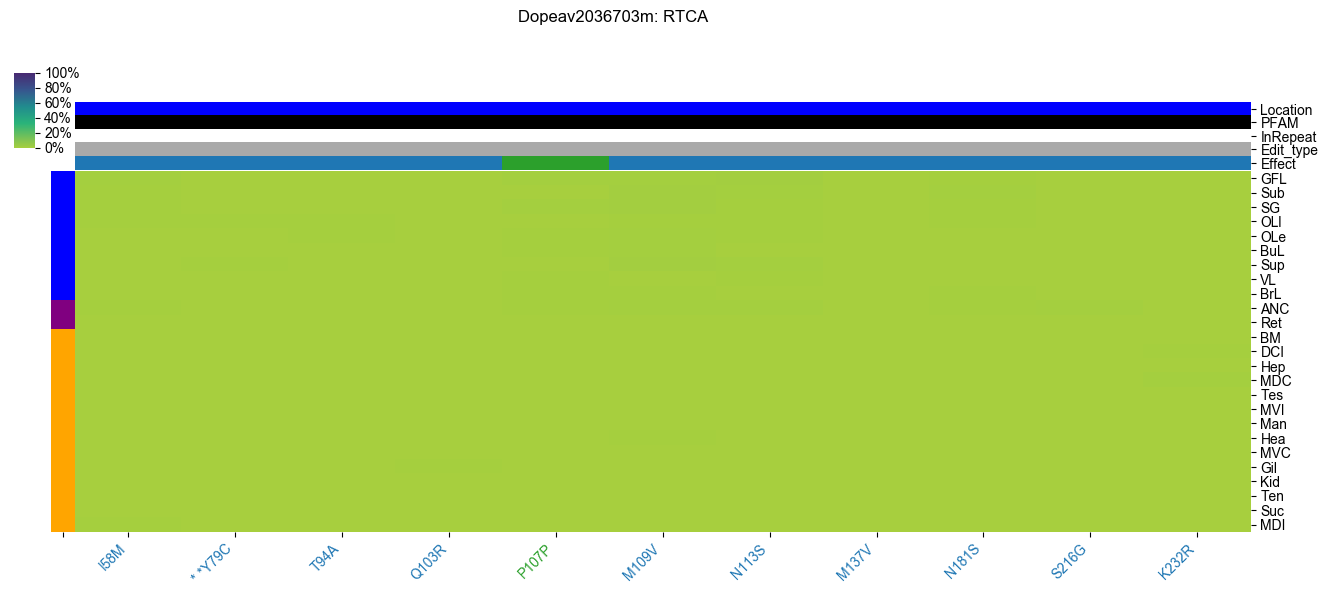

Dopeav2005419m: ADAR - tRNA-specific adenosine deaminase 1


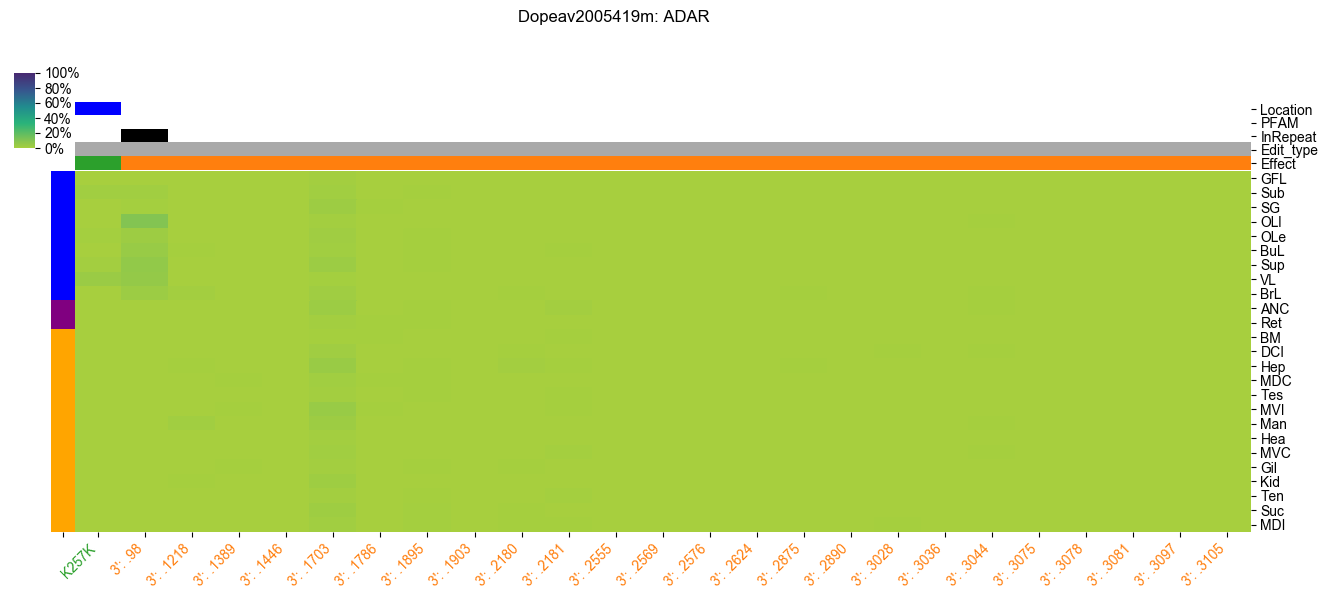

Dopeav2066729m: EARS2 - Glutamyl-tRNA synthetase (mitochondrial)


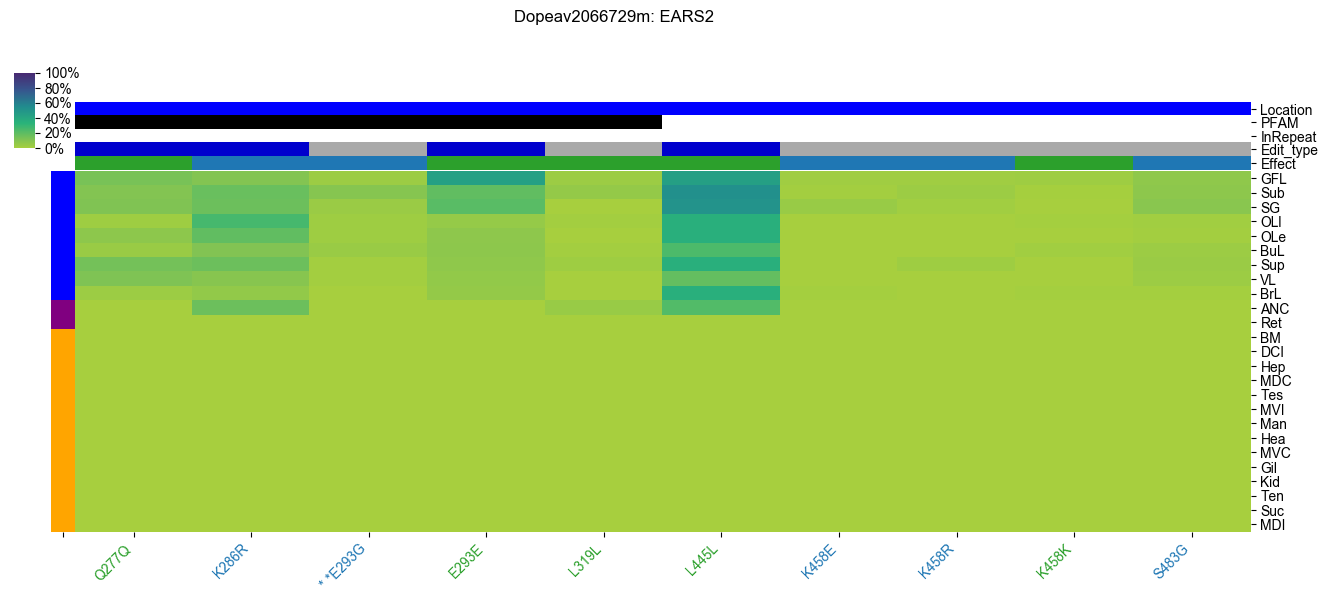

Dopeav2040434m: HNRNPA1 - RNA-binding protein musashi/mRNA cleavage and polyadenylation factor I complex, subunit HRP1


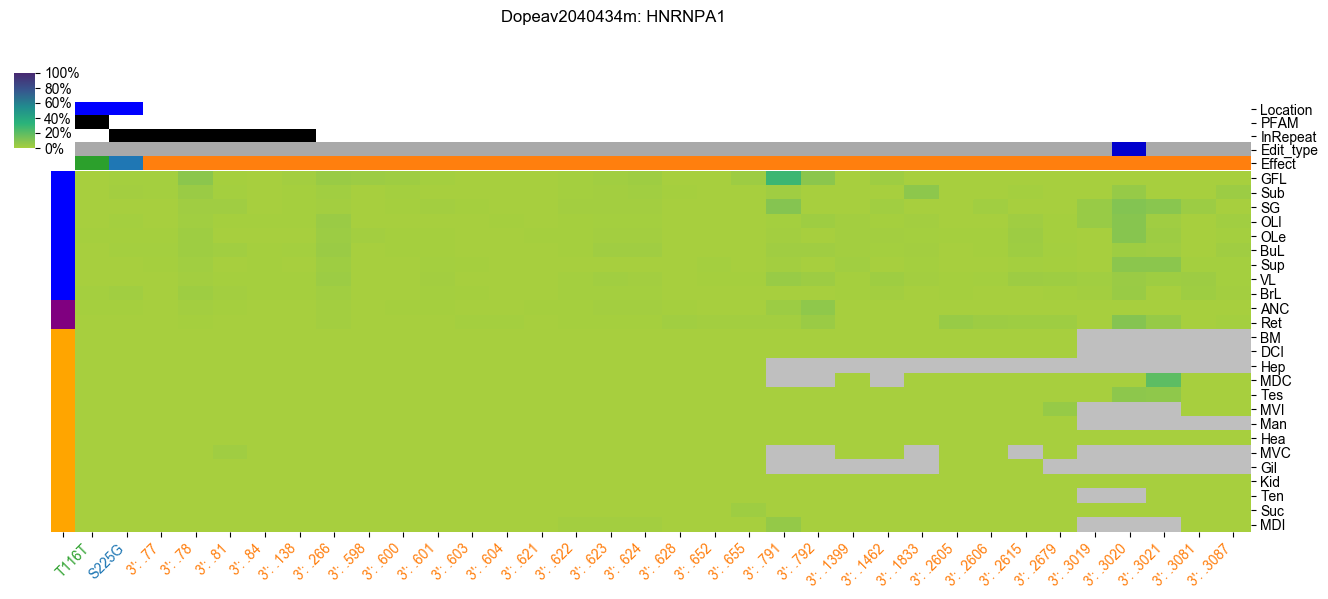

Dopeav2016222m: ADAR - tRNA-specific adenosine deaminase 1


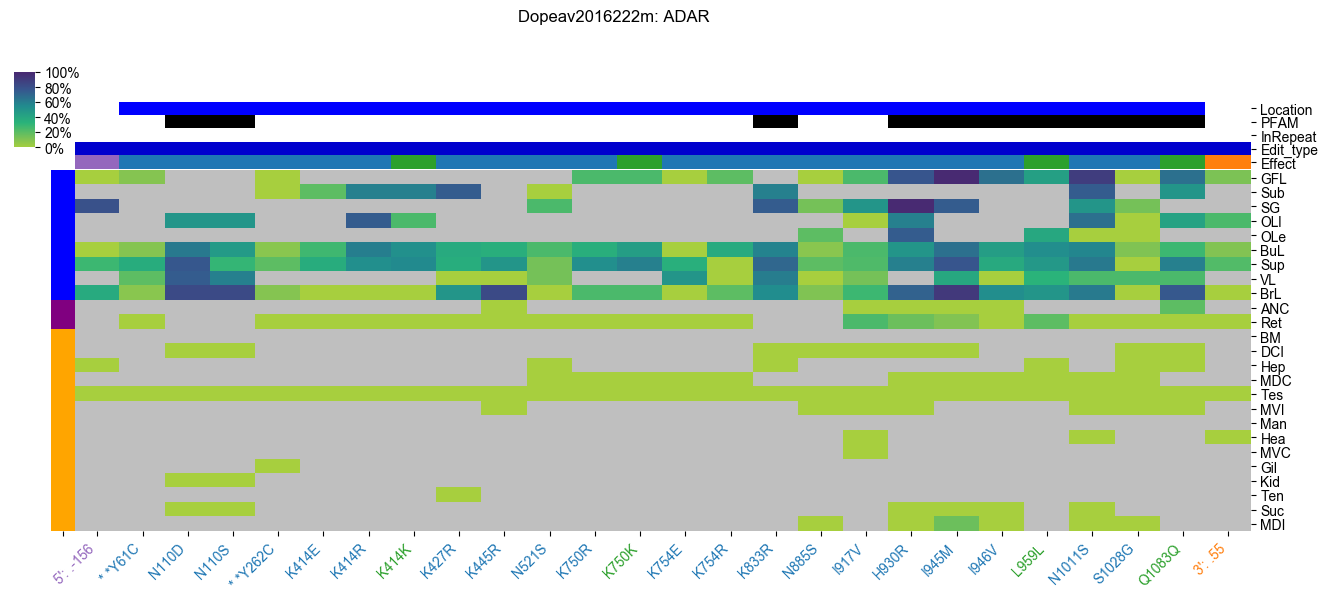

Dopeav2021847m: PTRH2 - 


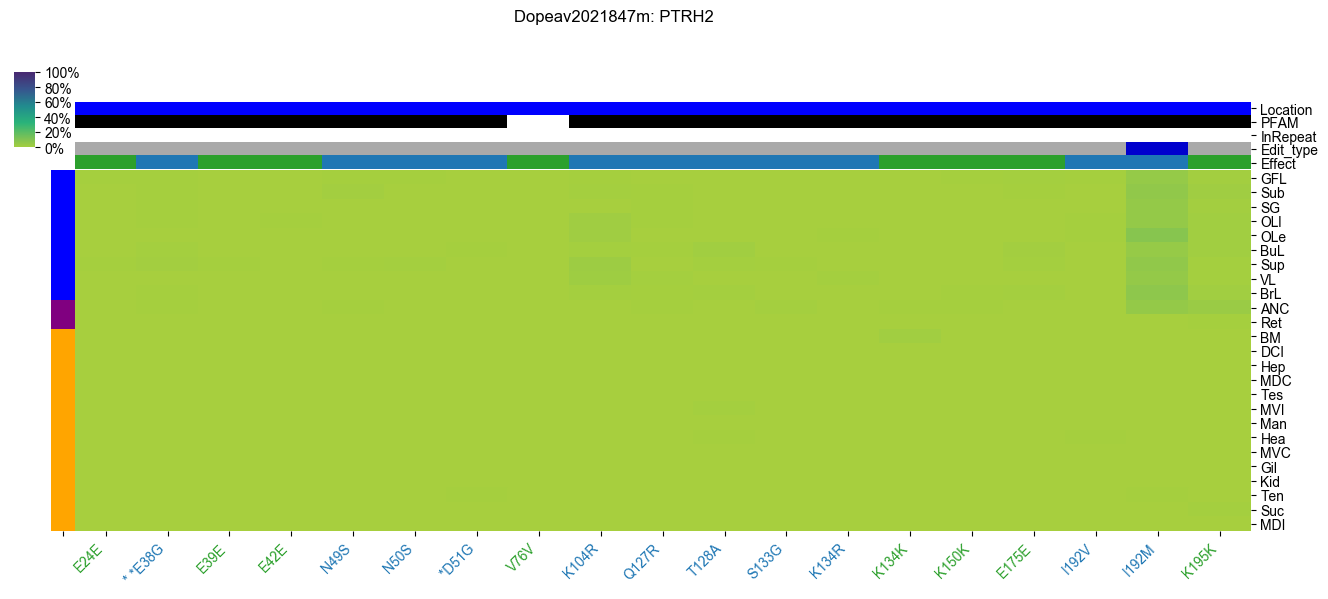

Dopeav2118252m: ADARB1 - tRNA-specific adenosine deaminase 1


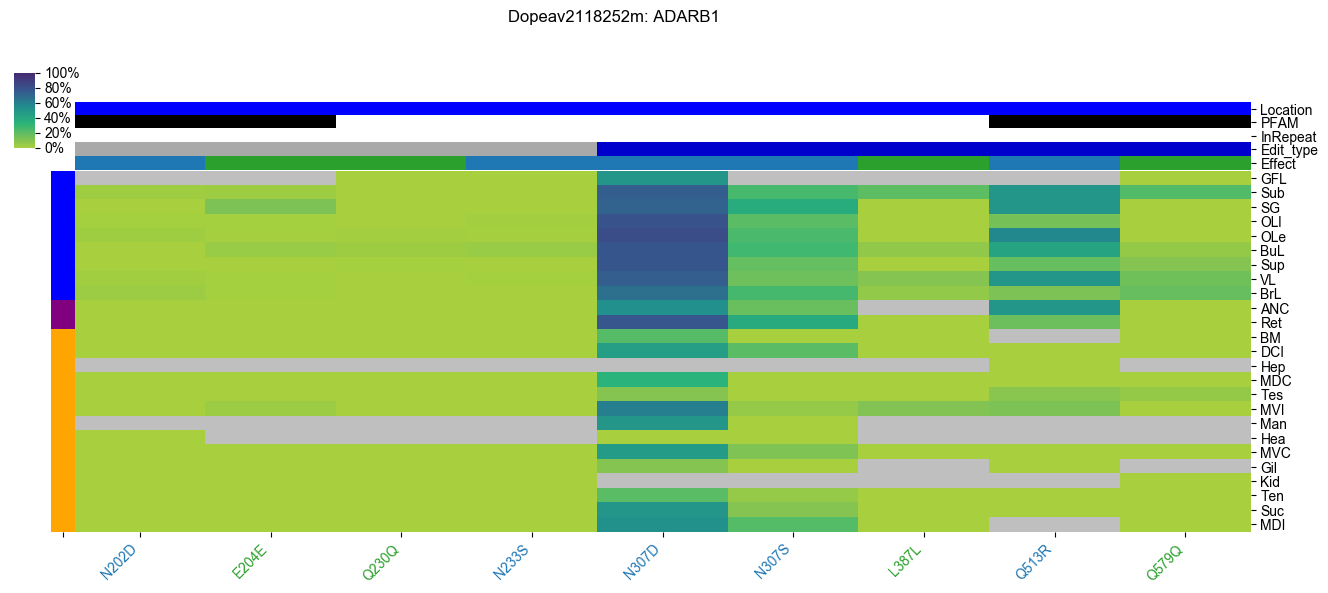

Dopeav2072076m: CELF4 - 


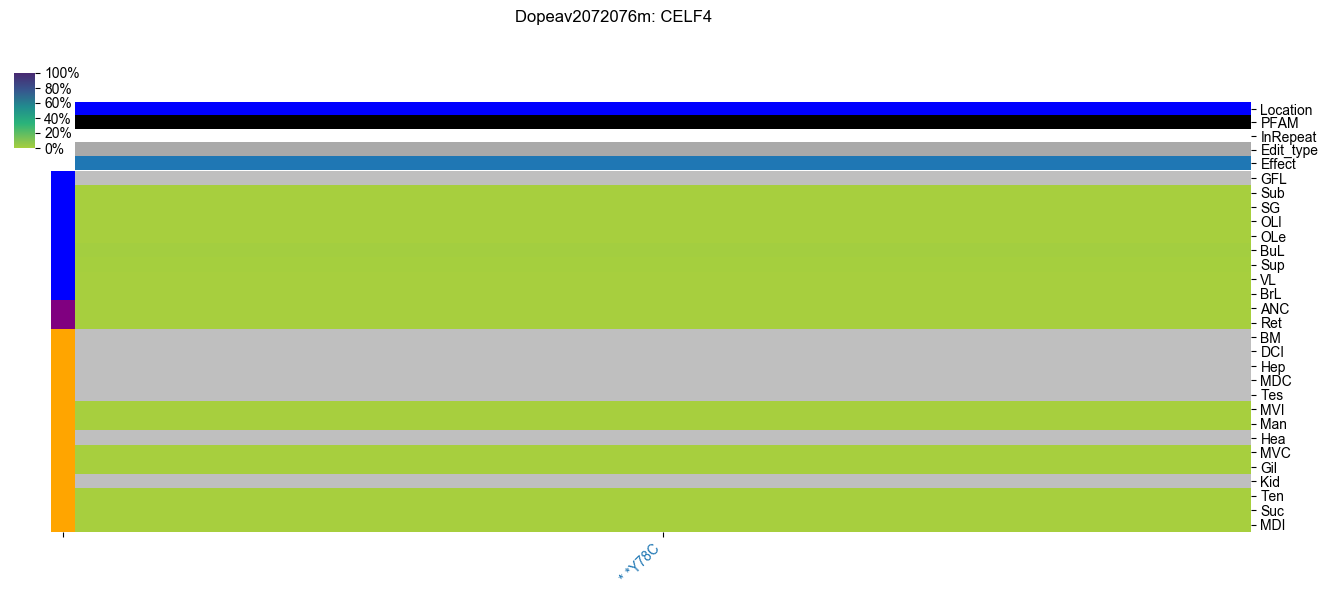

Dopeav2072123m: CELF3 - RNA-binding protein ETR-3 (RRM superfamily)


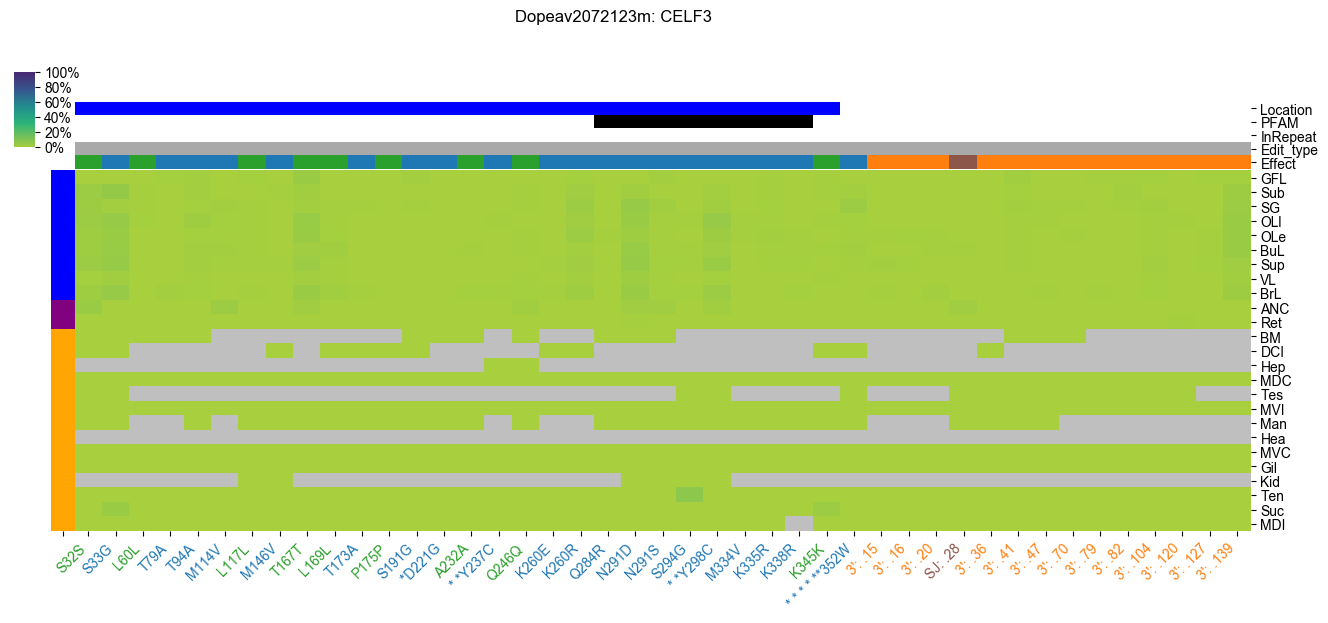

Dopeav2072116m: CELF4 - 


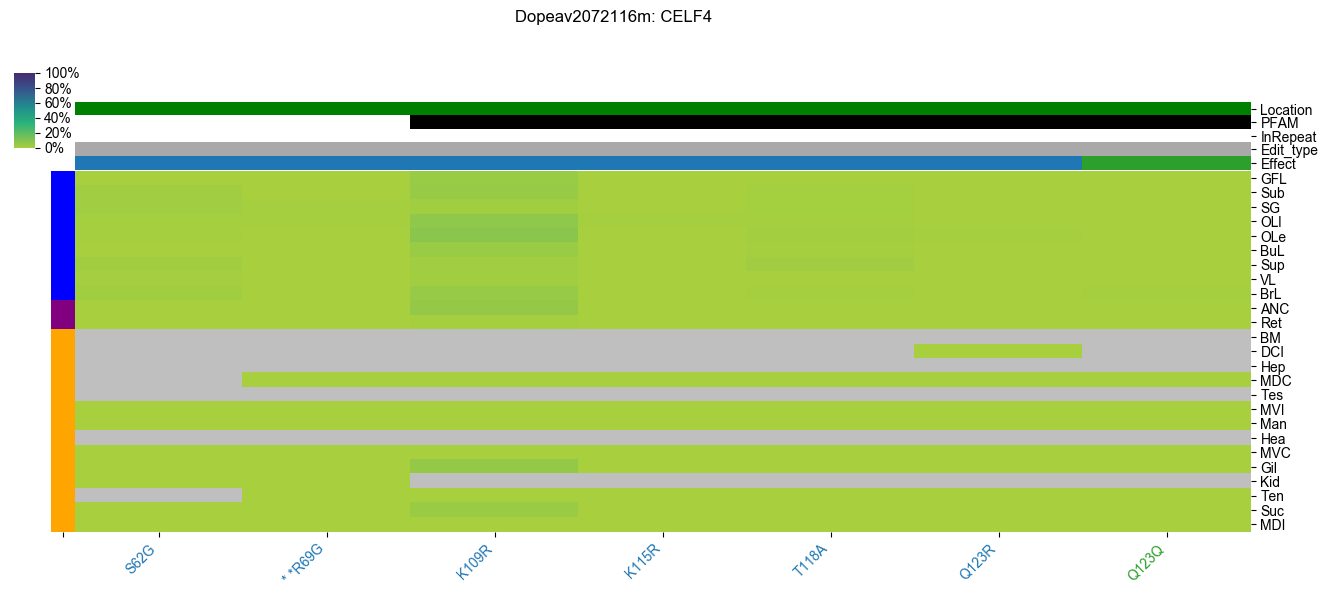

In [133]:
for gene_id in To_rename_dict.keys():
    if gene_id in ADAR_Albertin[(ADAR_Albertin.GeneID==gene_id) & ~(ADAR_Albertin.Effect=='Intron')].GeneID.unique():
        draw_EF_genes_test(gene_id, ADAR_Albertin,Neural_samples[::-1], NotNeu_samples,'','yes')




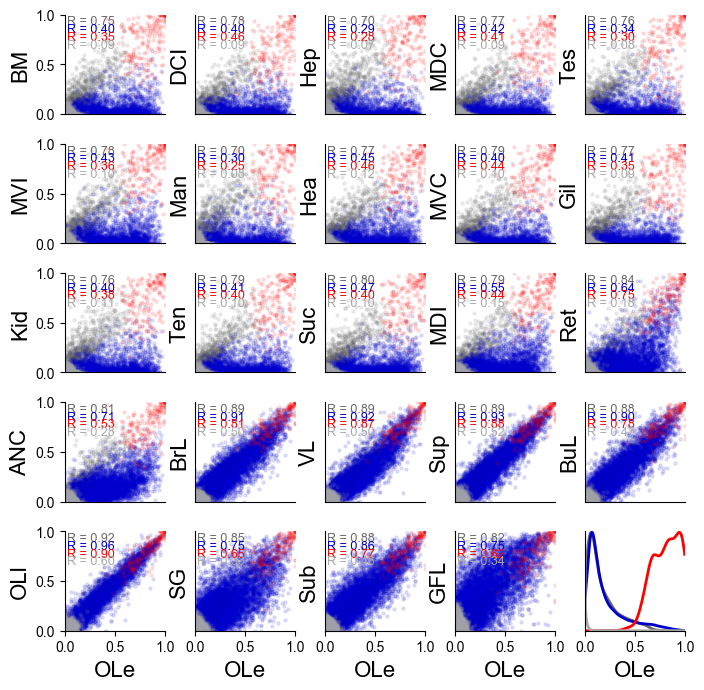

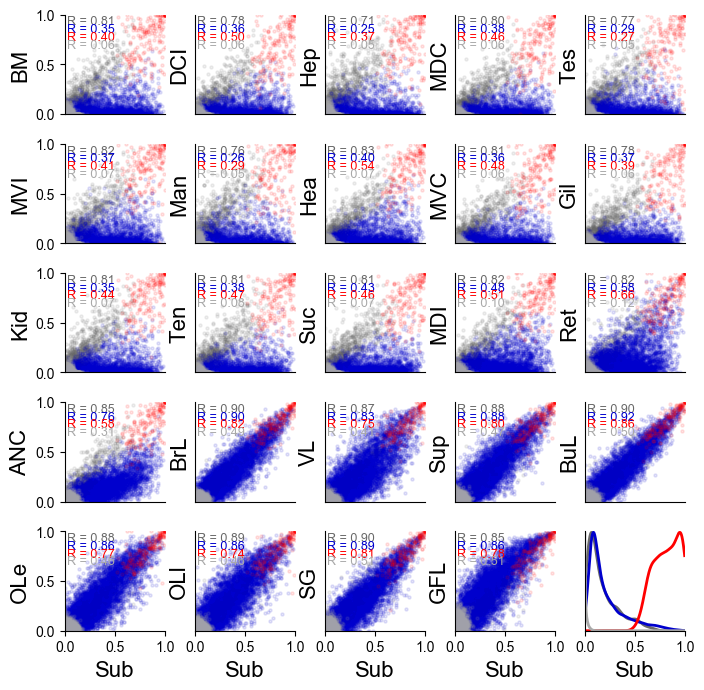

In [55]:
from scipy import stats 

def plot_scatter(sample_1, sample_2, ET, xticks_, yticks_, sample_1_label,Tmp_to_plot, y_text=0.98,  color ='' ):
    if color == '':
        plt.scatter(Tmp_to_plot[sample_1], Tmp_to_plot[sample_2],s=5, alpha=0.1)
        plt.text(0.025,y_text,''.join(('R = ',str(np.corrcoef(Tmp_to_plot[sample_1], Tmp_to_plot[sample_2])[0][1])[:4])))
    else:
        plt.scatter(Tmp_to_plot[sample_1], Tmp_to_plot[sample_2],s=5, alpha=0.1, color=color)
        plt.text(0.025,y_text,''.join(('R = ',str(np.corrcoef(Tmp_to_plot[sample_1], Tmp_to_plot[sample_2])[0][1])[:4])), color=color, fontsize=9)

    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(xticks_)
    plt.yticks(yticks_)
    plt.xlabel(sample_1_label, fontsize=16)
    plt.ylabel(sample_2, fontsize=16)
    return(plt)

def plot_kde(sample_1,ET, sample_1_label, Tmp_to_plot, y_text=0.98,  color='', y_lim_tp=(0,0)):
    if color == '':
        plt.hist(Tmp_to_plot[sample_1].dropna(), label=ET,bins=100,  alpha=0.1)
    else:
        #plt.hist(Tmp_to_plot[sample_1], color=color, label=ET,bins=100,  alpha=0.3)
        kde = stats.gaussian_kde(Tmp_to_plot[sample_1].dropna())
        xx = np.linspace(0, 1, 1000)
        plt.plot(xx, kde(xx)/(max(kde(xx)*1.01)), color=color)

    plt.xlim(0,1)    
    plt.ylim(0,1)
    plt.yticks([])
    plt.xlabel(sample_1_label, fontsize=16)
    #plt.legend(bbox_to_anchor=(-3,-.2), frameon=False, loc=2, ncol=5, fontsize = 12)

    return(plt)
 
def plot_scat_and_kde_wiht_sample_as_ref(sample, To_plot):
    samples_to_show_2 = NotNeu_samples+Neural_samples#['GFL','SG','BuL','BrL','VL','ANC','Ret','Hep','Tes']
    #color_editKind_2_list = [('Ubiquitous Low', 'darkgrey'), ('Ubiquitous Med', 'dimgrey'),('Ubiquitous High', 'black'),('Neural', 'mediumblue')]
    #list(color_editKind_2.items())

    #samples_to_show = Neural_samples + NotNeu_samples
    N = len(samples_to_show_2) # number of subplots you want
    ncols = 5
    nrows = int(np.ceil(len(samples_to_show_2)/float(ncols)))


    figsize =(8,8)
    plt.figure(figsize=figsize)
    
    counter =0
    for sample_1 in [sample]:
#    for sample_1 in [sample]:
        for sample_2 in samples_to_show_2:
            if (sample_1 == sample_2) == False:
                counter  = counter+1
                plt.subplot(ncols, nrows, counter)
                y_init = .90
                if counter  > len(samples_to_show_2) - ncols:
                    #xticks_ = [0,0.25,0.5,.75,1]
                    xticks_ = [0,0.5,1]
                    sample_1_label = sample_1
                else:
                    xticks_ = []
                    sample_1_label= ''
                if np.mod(counter,nrows) ==1:
                    #yticks_ = [0,0.25,0.5,.75,1]
                    yticks_ = [0,0.5,1]
                else:
                    yticks_ = [ ]
                for ET in color_editKind_2.keys():
                    Tmp_to_plot =  EF_Albertin.loc[To_plot[To_plot['Edit_type']==ET].ID.to_list()]
                    plot_scatter(sample_1,sample_2, ET, xticks_,yticks_, sample_1_label,Tmp_to_plot, y_init, color_editKind_2[ET] )
                    y_init= y_init - 0.078
    plt.subplot(ncols, nrows, counter+1)
    
    ylim_tp =(0,600)
    for ET in color_editKind_2.keys():
        Tmp_to_plot =  EF_Albertin.loc[To_plot[To_plot['Edit_type']==ET].ID.to_list()]
        plot_kde(sample_1,ET, sample_1_label, Tmp_to_plot, y_text=500, color=color_editKind_2[ET], y_lim_tp=ylim_tp)
    
    
    return(plt)

##########


samples_to_show_2 = NotNeu_samples+Neural_samples
To_plot = ADAR_Albertin[ADAR_Albertin.ID.isin(To_select_ubiq_expr)]

plot_scat_and_kde_wiht_sample_as_ref('OLe',To_plot)
plt.savefig('Fig8c_AllvsAll_UbiqExpr_OLe.png', bbox_inches='tight', dpi=300)
plt.savefig('Fig8c_AllvsAll_UbiqExpr_OLe.jpg', bbox_inches='tight', dpi=300)
plt.show()
plot_scat_and_kde_wiht_sample_as_ref('Sub',To_plot)
plt.savefig('Fig8c_AllvsAll_UbiqExpr_Sub.png', bbox_inches='tight', dpi=300)
plt.show()



In [184]:
gID = 'Dopeav2078512m'

def obtain_edited_peptides3(gID):
    
    aa_edited = dict()
    for ix  in ADAR_Albertin[(ADAR_Albertin.GeneID==gID) & ~(ADAR_Albertin.GVSp.isna())].sort_values(['Prot_pos','Effect'], ascending=[True,False]).index.to_list():
        pos = ADAR_Albertin.loc[ix].Prot_pos.astype(int)
        aa = ADAR_Albertin.loc[ix].Prot
        score = ADAR_Albertin.loc[ix].B62Score
        WN_ef=np.round(100*ADAR_Albertin.loc[ix].WN_ef,1)
        if WN_ef>=0:
            aa_edited[pos] = aa, score, WN_ef
            
    if (Gene_description[Gene_description.transcriptName==gID].HUGO.isnull().any()) :
        transcrpt_GeneID = gID
    else:
        transcrpt_GeneID = ''.join((Gene_description[Gene_description.transcriptName==gID].HUGO.to_list()[0],'_',gID))
    
    Pep_seq = Gene_description[Gene_description.transcriptName==gID].pep.to_list()[0]
    Edited_Pep_seq = []
    original_seq_dots = []
    original_seq_pena = []
    for i in enumerate(Pep_seq):
        if i[0]+1 in aa_edited.keys():
            Edited_Pep_seq.append(aa_edited[i[0]+1][0][2].lower())#[0]][0])
            original_seq_dots.append(aa_edited[i[0]+1][0][2])#[0]][0])
            if aa_edited[i[0]+1][1] <=0:
                original_seq_pena.append(str(int(abs(aa_edited[i[0]+1][1]))))
            if aa_edited[i[0]+1][1] >0:     
                original_seq_pena.append('.')
        if i[0]+1 not in aa_edited.keys():
            original_seq_dots.append('.')
            Edited_Pep_seq.append(i[1].upper())
            original_seq_pena.append('.')
            
    
    edited_seq = ''.join((Edited_Pep_seq))
    original_seq_dots = ''.join((original_seq_dots))
    original_seq_pena = ''.join((original_seq_pena))
    n_edits = len(aa_edited)
    seq_len = len(Pep_seq)
    edit_prop = np.round(100*n_edits/seq_len,0)
    text_length = ''.join(( str(n_edits),"/",str(seq_len),' = ', str(edit_prop),"% peptide edited"))
    
    
    sequence_all =  dict()
    sequence_all['Original'] = ''.join((">",transcrpt_GeneID,"_genomic\t",text_length,"\n",Pep_seq))
    sequence_all['Edited'] = ''.join((">",transcrpt_GeneID,"_edited\t",text_length,"\n",edited_seq))
    sequence_all['Dots_aa'] = ''.join((">",transcrpt_GeneID,"_changes\t",text_length,"\n",original_seq_dots))
    sequence_all['Dots_penalties'] = ''.join((">",transcrpt_GeneID,"_penalties\t",text_length,"\n",original_seq_pena))
    return(sequence_all)

sequences = obtain_edited_peptides3(gID)
for x in sequences.keys():
    print(sequences[x])

>GRIK2_Dopeav2078512m_genomic	39/852 = 5.0% peptide edited
MSAIEKVNLKNEVLPQTLLIYDVSIVQPQDSFHASKKVCKQLEEGVAAVFGPLSSSSAAHVQSICYALEIPHLQTRWDSRDIKDIDYFSINLYPHYLTLSRVFLDLVVHWNWKRFTILYEDNDGLIRLQEVLNAASKYKFEISVRKLQLWDGKYISQLKEIKEQGENRLIVDCNNNTIYQLLKQALQVTMLSNSYHFIFTTLDLPLIDLEEFRYGGANITAVRLIDSLRPLVSEVTQDWVMEEKRTGNSPIKGYKAEIPTETALMYDAVILFAKGLHQVAGARDINTMSLSCTKQNTWNHGNSLLNYMKTVVFDGLSGKIMFDSNGERSDFSVNVLMLKETGLTKIGTWTTKYGVNMTESPIENKKEIVRKLSNSTLRVVTKLELPYVGNKTHLDGTVHYEGFAIDLLNAIAEQLHFNYTITIVKDGQYGGEDPKTGKWNGMVGELIDQKADLAVAGMSITYKRERVIDFTKPFLNLGITILYKKPHKKPPKLFSFLSPLTSEVWVYIIAAYLVVSFMLYIIARLSPYEWYESGSDELDNQFTVLNSLWFTIGCLMQQGSEVAPRAVSTRIVSGIWWFFTLIMISSYTANLAAFLTIDRLDTTIESVEDLAKQTDVHYGTLKGGSSKAFFEDSDVPIYKQMANFMTSTTPSVYVSSTKQAVTRVLAGKYAYLGESTSIDYQVQRHCDLMQVGGLLDSKGYGIATPRGSPYRDMISEQILRLQERQKISKLYTKWWKEKAESNCDTESKGKQNANELGLQNVGGVFVVLMAGVVAGTIMAIMEFLWKAWRNSRIDKQPFCTEVSQELRVAITCLGSSRKNGKKKSEDARLDNHQLVPLTSGQNSFMSKDMNT*
>GRIK2_Dopeav2078512m_edited	39/852 = 5.0% peptide edited
vSAIEKVNLKNEVLPQTLLmcDVSIVQPQD

In [185]:
gID = 'Dopeav2016222m'

def obtain_edited_peptides3_rec(gID):
    
    aa_edited = dict()
    for ix  in ADAR_Albertin[(ADAR_Albertin.GeneID==gID) &(ADAR_Albertin.Effect=='Rec') & ~(ADAR_Albertin.GVSp.isna())].sort_values(['Prot_pos','Effect'], ascending=[True,False]).index.to_list():
        pos = ADAR_Albertin.loc[ix].Prot_pos.astype(int)
        aa = ADAR_Albertin.loc[ix].Prot
        score = ADAR_Albertin.loc[ix].B62Score
        WN_ef=np.round(100*ADAR_Albertin.loc[ix].WN_ef,1)
        if WN_ef>=0:
            aa_edited[pos] = aa, score, WN_ef
            
    if (Gene_description[Gene_description.transcriptName==gID].HUGO.isnull().any()) :
        transcrpt_GeneID = gID
    else:
        transcrpt_GeneID = ''.join((Gene_description[Gene_description.transcriptName==gID].HUGO.to_list()[0],'_',gID))
    
    Pep_seq = Gene_description[Gene_description.transcriptName==gID].pep.to_list()[0]
    Edited_Pep_seq = []
    original_seq_dots = []
    original_seq_pena = []
    for i in enumerate(Pep_seq):
        if i[0]+1 in aa_edited.keys():
            Edited_Pep_seq.append(aa_edited[i[0]+1][0][2].lower())#[0]][0])
            original_seq_dots.append(aa_edited[i[0]+1][0][2])#[0]][0])
            if aa_edited[i[0]+1][1] <=0:
                original_seq_pena.append(str(int(abs(aa_edited[i[0]+1][1]))))
            if aa_edited[i[0]+1][1] >0:     
                original_seq_pena.append('.')
        if i[0]+1 not in aa_edited.keys():
            original_seq_dots.append('.')
            Edited_Pep_seq.append(i[1].upper())
            original_seq_pena.append('.')
            
    
    edited_seq = ''.join((Edited_Pep_seq))
    original_seq_dots = ''.join((original_seq_dots))
    original_seq_pena = ''.join((original_seq_pena))
    n_edits = len(aa_edited)
    seq_len = len(Pep_seq)
    edit_prop = np.round(100*n_edits/seq_len,0)
    text_length = ''.join(( str(n_edits),"/",str(seq_len),' = ', str(edit_prop),"% peptide edited"))
    
    
    sequence_all =  dict()
    sequence_all['Original'] = ''.join((">",transcrpt_GeneID,"_genomic\t",text_length,"\n",Pep_seq))
    sequence_all['Edited'] = ''.join((">",transcrpt_GeneID,"_edited\t",text_length,"\n",edited_seq))
    sequence_all['Dots_aa'] = ''.join((">",transcrpt_GeneID,"_changes\t",text_length,"\n",original_seq_dots))
    sequence_all['Dots_penalties'] = ''.join((">",transcrpt_GeneID,"_penalties\t",text_length,"\n",original_seq_pena))
    return(sequence_all)

sequences = obtain_edited_peptides3_rec(gID)
for x in sequences.keys():
    print(sequences[x])

>ADAR_Dopeav2016222m_genomic	17/1259 = 1.0% peptide edited
MANSNLSSSMNQNMAHMGGGSLVNGYYKQVPYSGGRSRNASGRSGSRGRGKPAVRSKCFNYFHWSESETSLNVHPEWEERIVNYLAHKTHPVKTMELARLVNVRSRKEVNPTLYSMDRRGLIRKHGMQPPTWVIADPPQSHGGYNQNETHYSSSPGIYQHSPVSRTPQNFYPNNRESYRGHKAPNSNYPRSKRTSYRNDWHNFCSPPSHMYPEGKNESLIYSHSNKDNEMLSMGNASSPNRLRSESCSPDECEALETAIANYPHSGGYGQGYSGHFPVTPEPKQTGKRRRNCDNFGLQQHPSNGTMPMKNSEKIQQKKLEFQDERYYDASYPSYSGNFTMNYANHFDMPVYHPIDREDPKDTPPPSRVSMDLIKKDSKDISSHERISPKRNSNSKGCNSDAHDPQARVISFLDKTMNGSAKSREIAKHTSLSLEDTQKILHSLCKKKIVATIGEDIYIMAKNAASYETEIPAGKNSSSNMNSNMARQFSSGNRQPPAPPHVLLADNGINSGSMKNVYFQGNNAPKQSGSNSSESKSAQSQVGRSPHLPPSPHELLAKDPIFKGDITAPNTNASKDYNQSSSSSSASLSSSTSKNSRWNSNTAATESSRAPNTTSASTSSTTSFAPTPSKSASNSKQTAPSPKQPSPSPKQNTPKSSKSSKSSKQRATSPKQNSTPSSQASSQSNSNTTTTATSSSSKNNKNNNNNNTSVENLQDALKNVSISSPTETTESKTPTLAEIKAAAVAQALADKAAEKGADKSGTDSLAPNLQITSESFAALNKNPVSALMEYAQQRHLPVEFKLLSHRGPSHRPLFKFAVILGKRQFPSMECNSKKDGKKEAADLTLRILIAEGQYQLENTVSALKTIPPAEMTHFDKMAALSHQAFNNIALQIPENLAGRKVIAALVMKRSPTDTGIVISVGTGNRCLTGDHLSLEGNSVNDS

In [58]:
import scipy.stats as stats
Genotypes = pd.read_csv(Genotypes_OpalHbl_ovrp_Dp_file,sep='\t', index_col=0)
Genotypes.head()

Genotype         Ref   Edit_type Effect Effect_y
Dpe01:100717  A/A,A/A  Not-edited  Not-edited    Rec      Rec
Dpe01:100719  A/A,A/A  Not-edited  Not-edited    Syn      Syn
Dpe01:100727  A/A,A/A  Not-edited  Not-edited    Rec      Rec
Dpe01:100738  A/A,A/A  Not-edited  Not-edited    Rec      Rec
Dpe01:100739  A/A,A/A  Not-edited  Not-edited    Rec      Rec

In [59]:
ADAR_Albertin.loc[ADAR_Albertin.Edit_type.isnull(),'Edit_type'] = 'Unclassified'
Genotypes_m = pd.merge(Genotypes,ADAR_Albertin[['Category','ID','Edit_type']].set_index('ID'), left_index=True, right_index=True, how='left')
Genotypes_m = Genotypes_m.fillna('Not-edited')
Genotypes_m.head()

Genotype         Ref Edit_type_x Effect Effect_y    Category  \
Dpe01:100717  A/A,A/A  Not-edited  Not-edited    Rec      Rec  Not-edited   
Dpe01:100719  A/A,A/A  Not-edited  Not-edited    Syn      Syn  Not-edited   
Dpe01:100727  A/A,A/A  Not-edited  Not-edited    Rec      Rec  Not-edited   
Dpe01:100738  A/A,A/A  Not-edited  Not-edited    Rec      Rec  Not-edited   
Dpe01:100739  A/A,A/A  Not-edited  Not-edited    Rec      Rec  Not-edited   

             Edit_type_y  
Dpe01:100717  Not-edited  
Dpe01:100719  Not-edited  
Dpe01:100727  Not-edited  
Dpe01:100738  Not-edited  
Dpe01:100739  Not-edited

In [60]:
All_sties_by_Category = Genotypes_m.groupby(['Genotype','Category']).Effect.value_counts().unstack().loc[["A/A,A/A","T/T,T/T","C/C,C/C","G/G,G/G"]].fillna(0).astype(int)[['Rec','Syn']]
All_sties_by_Category.loc[:,'Rec:Syn'] = All_sties_by_Category.Rec/All_sties_by_Category.Syn 

for genotype_id in All_sties_by_Category.index.to_frame().Genotype.unique():
    df = All_sties_by_Category.loc[[genotype_id]][['Rec','Syn']].droplevel('Genotype')
    chi2, p, dof, ex = stats.chi2_contingency(df, correction=True)
    (chi2, p) = stats.chisquare(df.T, pd.DataFrame(ex).T)#, ddof=dof)
    All_sties_by_Category.loc[[genotype_id],'pval'] = p
All_sties_by_Category

Effect                   Rec      Syn   Rec:Syn          pval
Genotype Category                                            
A/A,A/A  Not-edited  3487181  1292934  2.697107  7.107040e-08
         Not_robust    48206    25824  1.866713  0.000000e+00
         Robust        11643     3683  3.161282  3.233340e-18
C/C,C/C  Not-edited     3912     2974  1.315400  9.563161e-01
         Not_robust       46       29  1.586207  4.324359e-01
         Robust            4        5  0.800000  4.526416e-01
G/G,G/G  Not-edited     8468    14437  0.586548  6.334126e-01
         Not_robust       62      209  0.296651  1.956049e-06
         Robust           28       40  0.700000  4.561733e-01
T/T,T/T  Not-edited     3004     3581  0.838872  9.513634e-01
         Not_robust       30       42  0.714286  5.047971e-01
         Robust            4        4  1.000000  8.018637e-01

In [61]:
Counts_All_sties_by_Category = pd.DataFrame(Genotypes_m.Genotype.value_counts()).loc[["A/A,A/A","T/T,T/T","C/C,C/C","G/G,G/G"]]
(Counts_All_sties_by_Category/Counts_All_sties_by_Category.sum()).Genotype.apply(lambda x: np.round(x,4))

A/A,A/A    0.9925
T/T,T/T    0.0014
C/C,C/C    0.0014
G/G,G/G    0.0047
Name: Genotype, dtype: float64

In [62]:
All_sties_by_ET = Genotypes_m[~(Genotypes_m.Edit_type_y=='Unclassified')].groupby(['Genotype','Edit_type_y']).Effect.value_counts().unstack().loc[["A/A,A/A","T/T,T/T","C/C,C/C","G/G,G/G"]].fillna(0).astype(int)[['Rec','Syn']]
All_sties_by_ET.loc[:,'Rec:Syn'] = All_sties_by_ET.Rec/All_sties_by_ET.Syn 

for genotype_id in All_sties_by_ET.index.to_frame().Genotype.unique():
    df = All_sties_by_ET.loc[[genotype_id]][['Rec','Syn']].droplevel('Genotype')
    chi2, p, dof, ex = stats.chi2_contingency(df, correction=True)
    (chi2, p) = stats.chisquare(df.T, pd.DataFrame(ex).T)#, ddof=dof)
    All_sties_by_ET.loc[[genotype_id],'pval'] = p
All_sties_by_ET

Effect                    Rec      Syn    Rec:Syn          pval
Genotype Edit_type_y                                           
A/A,A/A  Neural         17316     6743   2.567996  2.440579e-03
         Not-edited   3487181  1292934   2.697107  6.886773e-08
         Ubiq-High        124        8  15.500000  5.044782e-08
         Ubiq-Low       41924    22572   1.857345  0.000000e+00
         Ubiq-Med         290      119   2.436975  3.783449e-01
C/C,C/C  Neural             8        9   0.888889  4.156387e-01
         Not-edited      3912     2974   1.315400  9.645847e-01
         Ubiq-Low          41       25   1.640000  3.861307e-01
G/G,G/G  Neural            28       56   0.500000  5.081699e-01
         Not-edited      8468    14437   0.586548  6.273455e-01
         Ubiq-High          2        0        inf  6.392482e-02
         Ubiq-Low          55      185   0.297297  8.030524e-06
         Ubiq-Med           4        8   0.500000  8.025137e-01
T/T,T/T  Neural             6        7   0.857143  9.669434e-01
         Not-edited      3004     3581   0.838872  9.513634e-01
         Ubiq-Low          27       39   0.692308  4.459756e-01
         Ubiq-Med           1        0        inf  2.745488e-01

In [63]:
Robust_byET = Genotypes_m[(Genotypes_m.Category=='Robust') & ~(Genotypes_m.Edit_type_y=='Unclassified')].groupby(['Genotype','Edit_type_y']).Effect.value_counts().unstack().loc[["A/A,A/A","T/T,T/T","C/C,C/C","G/G,G/G"]].fillna(0).astype(int)[['Rec','Syn']]
Robust_byET.loc[:,'Rec:Syn'] = Robust_byET.Rec/Robust_byET.Syn 



for genotype_id in Robust_byET.index.to_frame().Genotype.unique():
    df = Robust_byET.loc[[genotype_id]][['Rec','Syn']].droplevel('Genotype')
    chi2, p, dof, ex = stats.chi2_contingency(df, correction=True)
    (chi2, p) = stats.chisquare(df.T, pd.DataFrame(ex).T)#, ddof=dof)
    Robust_byET.loc[[genotype_id],'pval'] = p
Robust_byET

Effect                  Rec   Syn    Rec:Syn      pval
Genotype Edit_type_y                                  
A/A,A/A  Neural       10883  3420   3.182164  0.704939
         Ubiq-High      124     8  15.500000  0.000001
         Ubiq-Low       289   135   2.140741  0.000173
         Ubiq-Med       233    87   2.678161  0.188576
C/C,C/C  Neural           4     4   1.000000  0.751830
         Ubiq-Low         0     1   0.000000  0.371093
G/G,G/G  Neural          22    28   0.785714  0.593611
         Ubiq-High        2     0        inf  0.085192
         Ubiq-Low         1     5   0.200000  0.237942
         Ubiq-Med         2     7   0.285714  0.268905
T/T,T/T  Neural           3     3   1.000000  1.000000
         Ubiq-Low         0     1   0.000000  0.317311
         Ubiq-Med         1     0        inf  0.317311

In [64]:
Counts_Robust_sties_by_ET = pd.DataFrame(Genotypes_m[(Genotypes_m.Category=='Robust') & ~(Genotypes_m.Edit_type_y=='Unclassified')].Genotype.value_counts()).loc[["A/A,A/A","T/T,T/T","C/C,C/C","G/G,G/G"]]
(Counts_Robust_sties_by_ET/Counts_Robust_sties_by_ET.sum()).Genotype.apply(lambda x: np.round(x,4))

A/A,A/A    0.9945
T/T,T/T    0.0005
C/C,C/C    0.0006
G/G,G/G    0.0044
Name: Genotype, dtype: float64

In [65]:
Genotypes_by_Edit_type_Rec = Genotypes[Genotypes['Effect']=='Rec'].groupby('Edit_type')['Genotype'].value_counts().unstack().fillna(0).T
Genotypes_by_Edit_type_Syn = Genotypes[Genotypes['Effect']=='Syn'].groupby('Edit_type')['Genotype'].value_counts().unstack().fillna(0).T

1827.102861094546 1.3263907588545594e-204 332


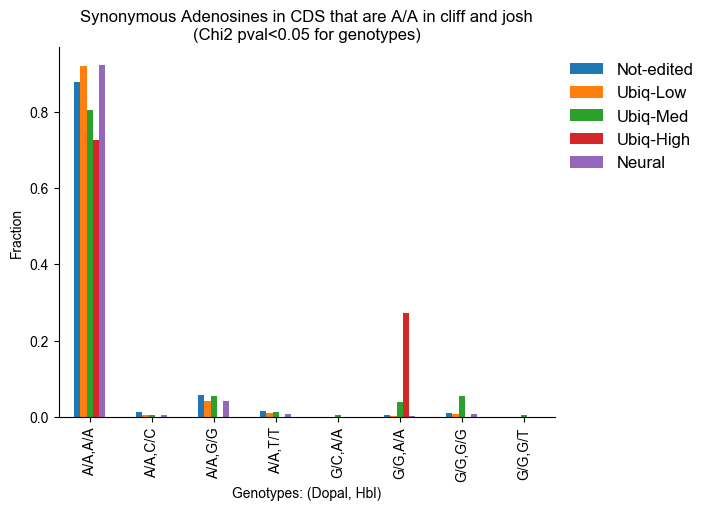

p_val
A/A,A/A   2.435123e-13
A/A,C/C   8.190071e-28
A/A,G/G   1.479868e-28
A/A,T/T   1.738551e-19
A/C,A/A   1.890680e-03
C/C,C/C   5.660987e-03
G/C,A/A  1.320838e-155
G/G,A/A   9.995522e-38
G/G,G/G   2.612652e-09
G/G,G/T   2.990079e-63
T/T,T/T   7.553744e-03

In [66]:
chi2, p, dof, ex = stats.chi2_contingency(Genotypes_by_Edit_type_Syn, correction=True)
print (chi2, p, dof)
(chi2, p) = stats.chisquare(Genotypes_by_Edit_type_Syn.T, pd.DataFrame(ex).T)#, ddof=dof)

Dif_btwn_gt = pd.DataFrame(p,index=Genotypes_by_Edit_type_Syn.index.to_list()).rename(columns={0:'p_val'})

(Genotypes_by_Edit_type_Syn/Genotypes_by_Edit_type_Syn.sum()).loc[Dif_btwn_gt[Dif_btwn_gt['p_val']<0.05/84].index.to_list()][['Not-edited','Ubiq-Low','Ubiq-Med','Ubiq-High',  'Neural']].plot(kind='bar')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.title('Synonymous Adenosines in CDS that are A/A in cliff and josh\n(Chi2 pval<0.05 for genotypes)')
plt.xlabel('Genotypes: (Dopal, Hbl)')
plt.ylabel('Fraction')
#plt.savefig('Fig_4E__Syn_Dopal_Hbl.png', bbox_inches='tight', dpi=900)
#plt.savefig('Fig_4E__Syn_Dopal_Hbl.pdf', bbox_inches='tight')#, dpi=300)
plt.show()

Dif_btwn_gt[Dif_btwn_gt['p_val']<0.01]

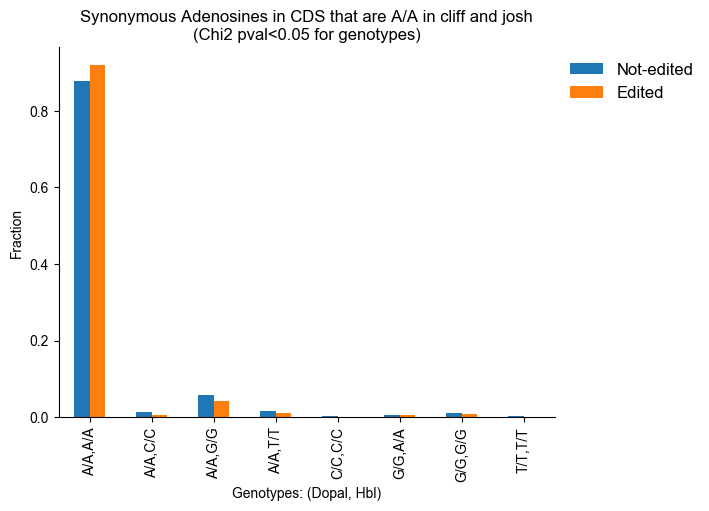

Not-edited    Edited      Fold  Fold_rev
Genotype                                          
A/A,A/A     0.877385  0.919172  1.047627  0.954538
A/A,C/C     0.012912  0.005557  0.430392  2.323461
A/A,G/G     0.057500  0.041772  0.726467  1.376526
A/A,T/T     0.016481  0.009522  0.577758  1.730829
C/C,C/C     0.002018  0.001061  0.525988  1.901185
G/G,A/A     0.006678  0.004183  0.626474  1.596235
G/G,G/G     0.009796  0.007774  0.793524  1.260201
T/T,T/T     0.002430  0.001436  0.591005  1.692033

In [67]:
#Make dataframe with genotype combinatiosn discriminating Edited vs Non-edited sites.
Genotypes_by_Edit_type_Syn_2 =  pd.DataFrame()
Genotypes_by_Edit_type_Syn_2['Not-edited']=Genotypes_by_Edit_type_Syn['Not-edited']
Genotypes_by_Edit_type_Syn_2['Edited'] = Genotypes_by_Edit_type_Syn[['Ubiq-Low','Ubiq-Med','Ubiq-High',  'Neural']].T.sum()

chi2, p, dof, ex = stats.chi2_contingency(Genotypes_by_Edit_type_Syn_2, correction=True)
(chi2, p) = stats.chisquare(Genotypes_by_Edit_type_Syn_2.T, pd.DataFrame(ex).T)#, ddof=8)
Dif_btwn_gt = pd.DataFrame(p,index=Genotypes_by_Edit_type_Syn_2.index.to_list())
Dif_btwn_gt = Dif_btwn_gt.rename(columns={0:'p_val'})


#Make plot of proportions:
Genotypes_by_Edit_type_Syn_2_prop=(Genotypes_by_Edit_type_Syn_2/Genotypes_by_Edit_type_Syn_2.sum())


Genotypes_by_Edit_type_Syn_2_prop.loc[Dif_btwn_gt[Dif_btwn_gt['p_val']<0.05/84].index.to_list()].plot(kind='bar')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.title('Synonymous Adenosines in CDS that are A/A in cliff and josh\n(Chi2 pval<0.05 for genotypes)')
plt.xlabel('Genotypes: (Dopal, Hbl)')
plt.ylabel('Fraction')
#plt.savefig('Fig_4E__Syn_Dopal_Hbl_agg.png', bbox_inches='tight', dpi=900)
#plt.savefig('Fig_4E__Syn_Dopal_Hbl_agg.pdf', bbox_inches='tight')#, dpi=300)
plt.show()


Genotypes_by_Edit_type_Syn_2_prop['Fold']=Genotypes_by_Edit_type_Syn_2_prop['Edited']/Genotypes_by_Edit_type_Syn_2_prop['Not-edited']
Genotypes_by_Edit_type_Syn_2_prop['Fold_rev']=Genotypes_by_Edit_type_Syn_2_prop['Not-edited']/Genotypes_by_Edit_type_Syn_2_prop['Edited']
Genotypes_by_Edit_type_Syn_2_prop.loc[Dif_btwn_gt[Dif_btwn_gt['p_val']<0.05/84].index.to_list()].sort_index()

In [68]:
Genotypes_by_Edit_type_Syn_2_pval = pd.merge(Genotypes_by_Edit_type_Syn_2, Dif_btwn_gt,left_index=True, right_index=True)
Genotypes_by_Edit_type_Syn_2_pval[Genotypes_by_Edit_type_Syn_2_pval.p_val<0.05/84]

#Edited sites are slighlty more (4.76%, pval<1e-15) conserved than non-edited Adenosines on CDSs. Supporting that selection is acting on edited sites to preserve the edited site.

Not-edited   Edited         p_val
Genotype                                   
A/A,A/A    1292999.0  29442.0  2.905131e-15
A/A,C/C      19028.0    178.0  9.307705e-31
A/A,G/G      84738.0   1338.0  2.365804e-31
A/A,T/T      24288.0    305.0  5.358444e-22
C/C,C/C       2974.0     34.0  1.509995e-04
G/G,A/A       9841.0    134.0  5.761237e-08
G/G,G/G      14437.0    249.0  2.873990e-04
T/T,T/T       3581.0     46.0  3.366472e-04

In [69]:
chi2, p, dof, ex = stats.chi2_contingency(Genotypes_by_Edit_type_Syn_2, correction=True)
(chi2, p) = stats.chisquare(Genotypes_by_Edit_type_Syn_2, pd.DataFrame(ex))#, ddof=8)
print (p)
#Positive selection is detected in Adenosines in CDs that are Edited compared to thoses that are non-edited (Chi-square pval<1e-73).



[1.00000000e+00 6.95884145e-73]


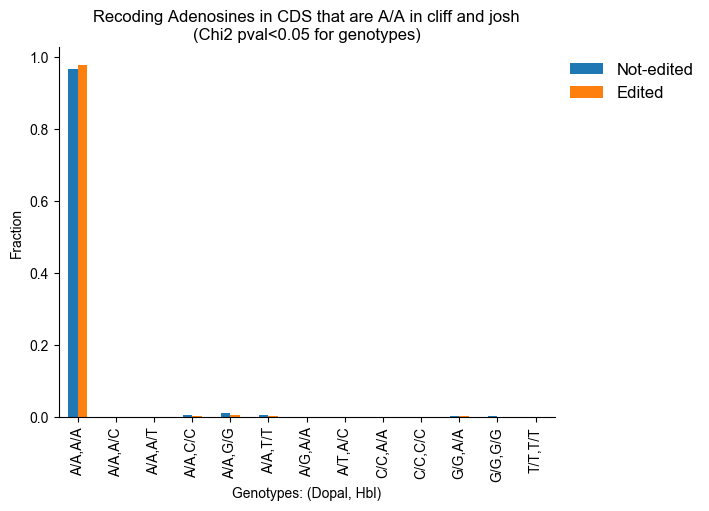

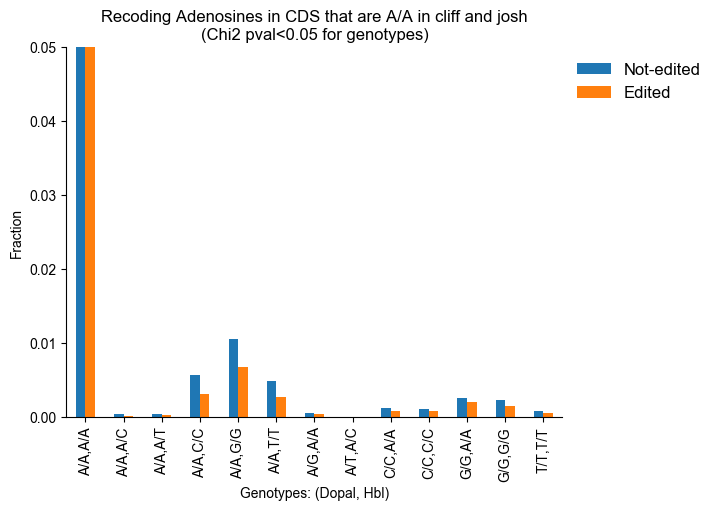

Not-edited    Edited       Fold  Fold_rev
Genotype                                           
A/A,A/A     0.966101  0.978175   1.012497  0.987657
A/A,A/C     0.000429  0.000197   0.458250  2.182214
A/A,A/T     0.000457  0.000262   0.574318  1.741196
A/A,C/C     0.005693  0.003181   0.558756  1.789691
A/A,G/G     0.010591  0.006821   0.644100  1.552553
A/A,T/T     0.004835  0.002706   0.559586  1.787035
A/G,A/A     0.000603  0.000394   0.652538  1.532477
A/T,A/C     0.000001  0.000016  14.797663  0.067578
C/C,A/A     0.001239  0.000869   0.701656  1.425200
C/C,C/C     0.001084  0.000803   0.741207  1.349151
G/G,A/A     0.002630  0.002099   0.798188  1.252837
G/G,G/G     0.002346  0.001459   0.622030  1.607641
T/T,T/T     0.000832  0.000558   0.669934  1.492684

In [71]:
#Make dataframe with genotype combinatiosn discriminating Edited vs Non-edited sites.
Genotypes_by_Edit_type_Rec_2 =  pd.DataFrame()
Genotypes_by_Edit_type_Rec_2['Not-edited']=Genotypes_by_Edit_type_Rec['Not-edited']
Genotypes_by_Edit_type_Rec_2['Edited'] = Genotypes_by_Edit_type_Rec[['Ubiq-Low','Ubiq-Med','Ubiq-High',  'Neural']].T.sum()

chi2, p, dof, ex = stats.chi2_contingency(Genotypes_by_Edit_type_Rec_2, correction=True)
(chi2, p) = stats.chisquare(Genotypes_by_Edit_type_Rec_2.T, pd.DataFrame(ex).T)#, ddof=8)
Dif_btwn_gt = pd.DataFrame(p,index=Genotypes_by_Edit_type_Rec_2.index.to_list())
Dif_btwn_gt = Dif_btwn_gt.rename(columns={0:'p_val'})


#Make plot of proportions:
Genotypes_by_Edit_type_Rec_2_prop=(Genotypes_by_Edit_type_Rec_2/Genotypes_by_Edit_type_Rec_2.sum())


Genotypes_by_Edit_type_Rec_2_prop.loc[Dif_btwn_gt[Dif_btwn_gt['p_val']<0.05].index.to_list()].plot(kind='bar')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.title('Recoding Adenosines in CDS that are A/A in cliff and josh\n(Chi2 pval<0.05 for genotypes)')
plt.xlabel('Genotypes: (Dopal, Hbl)')
plt.ylabel('Fraction')
#plt.savefig('Fig_4E__Rec_Dopal_Hbl_agg_zoomOut.png', bbox_inches='tight', dpi=900)
#plt.savefig('Fig_4E__Rec_Dopal_Hbl_agg_zoomOut.pdf', bbox_inches='tight')#, dpi=300)
plt.show()


Genotypes_by_Edit_type_Rec_2_prop.loc[Dif_btwn_gt[Dif_btwn_gt['p_val']<0.05].index.to_list()].plot(kind='bar')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.title('Recoding Adenosines in CDS that are A/A in cliff and josh\n(Chi2 pval<0.05 for genotypes)')
plt.xlabel('Genotypes: (Dopal, Hbl)')
plt.ylabel('Fraction')
plt.ylim(0,0.05)
#plt.savefig('Fig_4E__Rec_Dopal_Hbl_agg_zooIn.png', bbox_inches='tight', dpi=900)
#plt.savefig('Fig_4E__Rec_Dopal_Hbl_agg_zooIn.pdf', bbox_inches='tight')#, dpi=300)


plt.show()



Genotypes_by_Edit_type_Rec_2_prop['Fold']=Genotypes_by_Edit_type_Rec_2_prop['Edited']/Genotypes_by_Edit_type_Rec_2_prop['Not-edited']
Genotypes_by_Edit_type_Rec_2_prop['Fold_rev']=Genotypes_by_Edit_type_Rec_2_prop['Not-edited']/Genotypes_by_Edit_type_Rec_2_prop['Edited']
Genotypes_by_Edit_type_Rec_2_prop.loc[Dif_btwn_gt[Dif_btwn_gt['p_val']<0.05].index.to_list()].sort_index()

## Sepia

In [73]:
Genotypes_allA_sepia = pd.read_csv('../Edited_vs_Non_edited_DpalHbl_allAs_sepia.gt.tab',sep='\t')


Genotypes_by_Edit_type_Rec = Genotypes_allA_sepia[Genotypes_allA_sepia['Effect']=='Rec'].groupby('Edit_type')['sepia'].value_counts().unstack().fillna(0).T
Genotypes_by_Edit_type_Syn = Genotypes_allA_sepia[Genotypes_allA_sepia['Effect']=='Syn'].groupby('Edit_type')['sepia'].value_counts().unstack().fillna(0).T

154.43667132424298 4.1680259890508074e-13 48


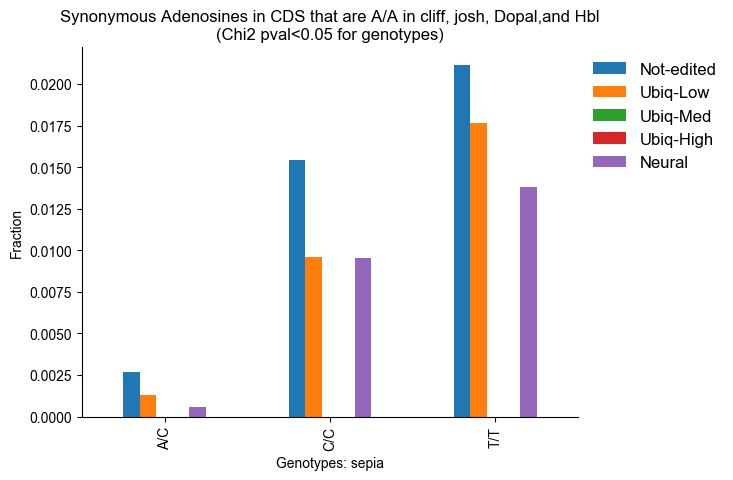

p_val
A/C  1.823009e-04
A/G  8.284649e-04
C/C  5.912582e-11
T/T  3.066263e-05

In [74]:
chi2, p, dof, ex = stats.chi2_contingency(Genotypes_by_Edit_type_Syn, correction=True)
print (chi2, p, dof)
(chi2, p) = stats.chisquare(Genotypes_by_Edit_type_Syn.T, pd.DataFrame(ex).T)#, ddof=dof)

Dif_btwn_gt = pd.DataFrame(p,index=Genotypes_by_Edit_type_Syn.index.to_list()).rename(columns={0:'p_val'})

(Genotypes_by_Edit_type_Syn/Genotypes_by_Edit_type_Syn.sum()).loc[Dif_btwn_gt[Dif_btwn_gt['p_val']<0.05/84].index.to_list()][['Not-edited','Ubiq-Low','Ubiq-Med','Ubiq-High',  'Neural']].plot(kind='bar')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.title('Synonymous Adenosines in CDS that are A/A in cliff, josh, Dopal,and Hbl\n(Chi2 pval<0.05 for genotypes)')
plt.xlabel('Genotypes: sepia')
plt.ylabel('Fraction')
#plt.savefig('Fig_4E__Syn_Sepia_zoomIn.png', bbox_inches='tight', dpi=900)
#plt.savefig('Fig_4E__Syn_Sepia_zoomIn.pdf', bbox_inches='tight')#, dpi=300)


plt.show()

Dif_btwn_gt[Dif_btwn_gt['p_val']<0.01]

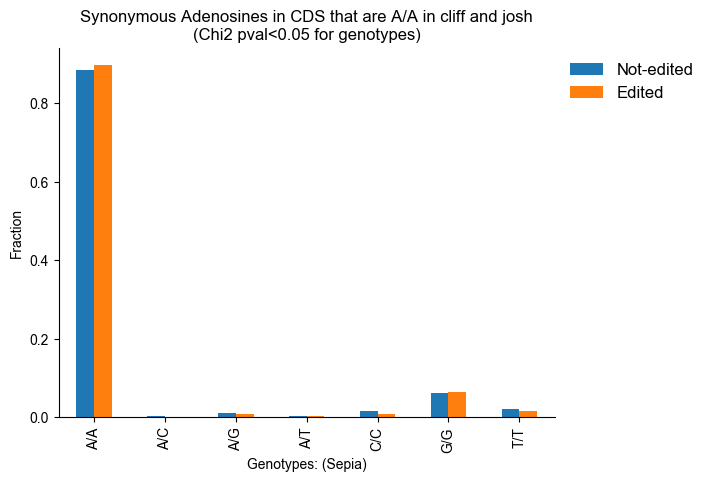

Not-edited    Edited      Fold  Fold_rev
sepia                                          
A/A      0.884628  0.897122  1.014124  0.986073
A/C      0.002682  0.001128  0.420467  2.378309
A/G      0.010625  0.007853  0.739066  1.353060
A/T      0.003546  0.002339  0.659684  1.515877
C/C      0.015432  0.009523  0.617119  1.620433
G/G      0.061809  0.065244  1.055575  0.947351
T/T      0.021165  0.016708  0.789412  1.266766

In [75]:
#Make dataframe with genotype combinatiosn discriminating Edited vs Non-edited sites.
Genotypes_by_Edit_type_Syn_2 =  pd.DataFrame()
Genotypes_by_Edit_type_Syn_2['Not-edited']=Genotypes_by_Edit_type_Syn['Not-edited']
Genotypes_by_Edit_type_Syn_2['Edited'] = Genotypes_by_Edit_type_Syn[['Ubiq-Low','Ubiq-Med','Ubiq-High',  'Neural']].T.sum()

chi2, p, dof, ex = stats.chi2_contingency(Genotypes_by_Edit_type_Syn_2, correction=True)
(chi2, p) = stats.chisquare(Genotypes_by_Edit_type_Syn_2.T, pd.DataFrame(ex).T)#, ddof=8)
Dif_btwn_gt = pd.DataFrame(p,index=Genotypes_by_Edit_type_Syn_2.index.to_list())
Dif_btwn_gt = Dif_btwn_gt.rename(columns={0:'p_val'})


#Make plot of proportions:
Genotypes_by_Edit_type_Syn_2_prop=(Genotypes_by_Edit_type_Syn_2/Genotypes_by_Edit_type_Syn_2.sum())


Genotypes_by_Edit_type_Syn_2_prop.loc[Dif_btwn_gt[Dif_btwn_gt['p_val']<0.05].index.to_list()].plot(kind='bar')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.title('Synonymous Adenosines in CDS that are A/A in cliff and josh\n(Chi2 pval<0.05 for genotypes)')
plt.xlabel('Genotypes: (Sepia)')
plt.ylabel('Fraction')
#plt.savefig('Fig_4E__Syn_Sepia_agg_zoomOut.png', bbox_inches='tight', dpi=900)
#plt.savefig('Fig_4E__Syn_Sepia_agg_zoomOut.pdf', bbox_inches='tight')#, dpi=300)

plt.show()


Genotypes_by_Edit_type_Syn_2_prop['Fold']=Genotypes_by_Edit_type_Syn_2_prop['Edited']/Genotypes_by_Edit_type_Syn_2_prop['Not-edited']
Genotypes_by_Edit_type_Syn_2_prop['Fold_rev']=Genotypes_by_Edit_type_Syn_2_prop['Not-edited']/Genotypes_by_Edit_type_Syn_2_prop['Edited']
Genotypes_by_Edit_type_Syn_2_prop.loc[Dif_btwn_gt[Dif_btwn_gt['p_val']<0.05].index.to_list()].sort_index()

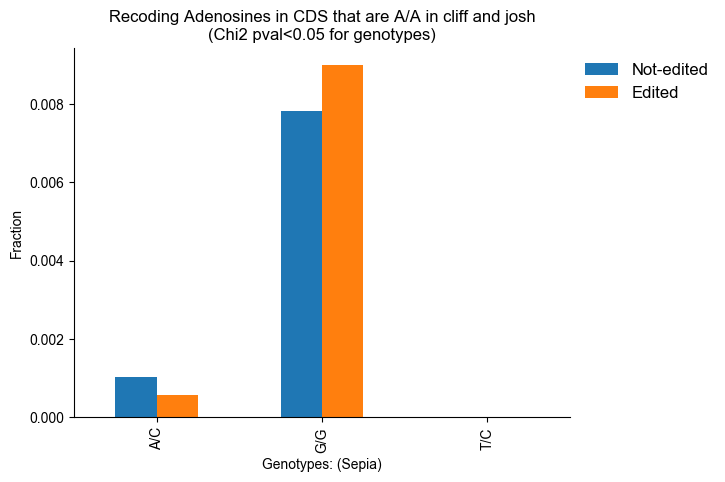

Not-edited    Edited      Fold  Fold_rev
sepia                                          
A/C      0.001039  0.000574  0.553080  1.808057
G/G      0.007830  0.008986  1.147676  0.871326
T/C      0.000003  0.000021  6.414035  0.155908

In [76]:
#Make dataframe with genotype combinatiosn discriminating Edited vs Non-edited sites.
Genotypes_by_Edit_type_Rec_2 =  pd.DataFrame()
Genotypes_by_Edit_type_Rec_2['Not-edited']=Genotypes_by_Edit_type_Rec['Not-edited']
Genotypes_by_Edit_type_Rec_2['Edited']    =Genotypes_by_Edit_type_Rec[['Ubiq-Low','Ubiq-Med','Ubiq-High',  'Neural']].T.sum()

chi2, p, dof, ex = stats.chi2_contingency(Genotypes_by_Edit_type_Rec_2, correction=True)
(chi2, p) = stats.chisquare(Genotypes_by_Edit_type_Rec_2.T, pd.DataFrame(ex).T)#, ddof=8)
Dif_btwn_gt = pd.DataFrame(p,index=Genotypes_by_Edit_type_Rec_2.index.to_list())
Dif_btwn_gt = Dif_btwn_gt.rename(columns={0:'p_val'})


#Make plot of proportions:
Genotypes_by_Edit_type_Rec_2_prop=(Genotypes_by_Edit_type_Rec_2/Genotypes_by_Edit_type_Rec_2.sum())


Genotypes_by_Edit_type_Rec_2_prop.loc[Dif_btwn_gt[Dif_btwn_gt['p_val']<0.05].index.to_list()].plot(kind='bar')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.title('Recoding Adenosines in CDS that are A/A in cliff and josh\n(Chi2 pval<0.05 for genotypes)')
plt.xlabel('Genotypes: (Sepia)')
plt.ylabel('Fraction')
#plt.savefig('Fig_4E__Rec_Sepia_agg_zoomOut.png', bbox_inches='tight', dpi=900)
#plt.savefig('Fig_4E__Rec_Sepia_agg_zoomOut.pdf', bbox_inches='tight')#, dpi=300)

plt.show()


Genotypes_by_Edit_type_Rec_2_prop['Fold']=Genotypes_by_Edit_type_Rec_2_prop['Edited']/Genotypes_by_Edit_type_Rec_2_prop['Not-edited']
Genotypes_by_Edit_type_Rec_2_prop['Fold_rev']=Genotypes_by_Edit_type_Rec_2_prop['Not-edited']/Genotypes_by_Edit_type_Rec_2_prop['Edited']
Genotypes_by_Edit_type_Rec_2_prop.loc[Dif_btwn_gt[Dif_btwn_gt['p_val']<0.05].index.to_list()].sort_index()